### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
sns.set()
from functools import reduce
from numpy import mean
from numpy import std
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.cluster import KMeans, AgglomerativeClustering
from xgboost import XGBClassifier
from sklearn.svm import SVC  
from sklearn.linear_model import Lasso, ElasticNet
from operator import itemgetter
from itertools import product
from sklearn.metrics import accuracy_score, make_scorer, precision_score, recall_score, f1_score, roc_curve, auc, silhouette_score
from mrmr import mrmr_classif
from yellowbrick.cluster import SilhouetteVisualizer

%matplotlib inline 

### Read diabetes file and convert to dataframe 

In [2]:
# Define filepath
filepath = 'D:\FYP\Merged_abundance_species_D.xlsx'

# Load Excel file using Pandas with `sheet_name=None`
df_first = pd.read_excel(filepath, sheet_name='First')
df_second = pd.read_excel(filepath, sheet_name='Second')
df_third = pd.read_excel(filepath, sheet_name='Third')
df_fourth = pd.read_excel(filepath, sheet_name='Fourth')
df_fifth = pd.read_excel(filepath, sheet_name='Fifth')
df_sixth = pd.read_excel(filepath, sheet_name='Sixth')
df_seventh = pd.read_excel(filepath, sheet_name='Seventh')

# Preview
df_first.head(5)

body_site  SRR1778451d  SRR1778454d  SRR1778456d  \
0               Bacteroides_caccae     22.20384      2.41857      0.53348   
1                Phocaeicola_dorei     13.38680      0.00000      1.78776   
2  Ruthenibacterium_lactatiformans      8.77166      0.05257      0.02502   
3             Ruminococcus_torques      6.97158      0.20878      0.01473   
4            Bacteroides_stercoris      5.34026     12.59911      0.88870   

   SRR341663d  SRR341666d  SRR341685d  SRR341700d  SRR341725d  SRR413556d  \
0     0.00293     0.06965     1.87127     0.40095     0.00364     0.24959   
1    18.02465     0.15120     3.37103     2.16329    16.66221     0.00000   
2     0.08182     0.01096     0.02320     0.00000     0.06363     0.00000   
3     0.52422     0.76816     0.32991     0.21744     0.31802     0.03404   
4    13.13054     0.59907     8.14250     0.01088     2.63578     0.00000   

   SRR413615d  
0     3.62311  
1     0.87098  
2     0.24460  
3     0.90843  
4     7.67505

In [3]:
# Get the shape of all sheets
print("First :", df_first.shape)
print("Second :", df_second.shape)
print("Third :", df_third.shape)
print("Fourth :", df_fourth.shape)
print("Fifth :", df_fifth.shape)
print("Sixth :", df_sixth.shape)
print("Seventh :", df_seventh.shape)

First : (1290, 11)
Second : (1559, 11)
Third : (1415, 11)
Fourth : (1339, 11)
Fifth : (1283, 11)
Sixth : (1527, 11)
Seventh : (1160, 11)


In [4]:
# concatenate all the sheets 
# df_T2D_ori --> ORIGINAL DATASET WITH ALL ROWS AND COLUMNS
dfs = [df_first,df_second,df_third,df_fourth,df_fifth,df_sixth,df_seventh]
df_T2D_ori = pd.concat(dfs)
print("df_T2D :", df_T2D_ori.shape)
df_T2D_ori.head()

df_T2D : (9573, 71)


body_site  SRR1778451d  SRR1778454d  SRR1778456d  \
0               Bacteroides_caccae     22.20384      2.41857      0.53348   
1                Phocaeicola_dorei     13.38680      0.00000      1.78776   
2  Ruthenibacterium_lactatiformans      8.77166      0.05257      0.02502   
3             Ruminococcus_torques      6.97158      0.20878      0.01473   
4            Bacteroides_stercoris      5.34026     12.59911      0.88870   

   SRR341663d  SRR341666d  SRR341685d  SRR341700d  SRR341725d  SRR413556d  \
0     0.00293     0.06965     1.87127     0.40095     0.00364     0.24959   
1    18.02465     0.15120     3.37103     2.16329    16.66221     0.00000   
2     0.08182     0.01096     0.02320     0.00000     0.06363     0.00000   
3     0.52422     0.76816     0.32991     0.21744     0.31802     0.03404   
4    13.13054     0.59907     8.14250     0.01088     2.63578     0.00000   

   ...  SRR18845028d  SRR18845030d  SRR18845046d  SRR18845047d  SRR18845120d  \
0  ...           NaN           NaN           NaN           NaN           NaN   
1  ...           NaN           NaN           NaN           NaN           NaN   
2  ...           NaN           NaN           NaN           NaN           NaN   
3  ...           NaN           NaN           NaN           NaN           NaN   
4  ...           NaN           NaN           NaN           NaN           NaN   

   SRR18845127d  SRR2912789d  SRR413581d  SRR413589d  SRR413596d  
0           NaN          NaN         NaN         NaN         NaN  
1           NaN          NaN         NaN         NaN         NaN  
2           NaN          NaN         NaN         NaN         NaN  
3           NaN          NaN         NaN         NaN         NaN  
4           NaN          NaN         NaN         NaN         NaN  

[5 rows x 71 columns]

In [5]:
# convert all NaN to 0s
# df_convert --> dataframe of converted NaN to 0 
df_convert = df_T2D_ori.replace(np.nan, 0)
# get number of NaN values
print("Sum of NaN : ", df_convert.isnull().sum().sum())
df_convert.head()

Sum of NaN :  0


body_site  SRR1778451d  SRR1778454d  SRR1778456d  \
0               Bacteroides_caccae     22.20384      2.41857      0.53348   
1                Phocaeicola_dorei     13.38680      0.00000      1.78776   
2  Ruthenibacterium_lactatiformans      8.77166      0.05257      0.02502   
3             Ruminococcus_torques      6.97158      0.20878      0.01473   
4            Bacteroides_stercoris      5.34026     12.59911      0.88870   

   SRR341663d  SRR341666d  SRR341685d  SRR341700d  SRR341725d  SRR413556d  \
0     0.00293     0.06965     1.87127     0.40095     0.00364     0.24959   
1    18.02465     0.15120     3.37103     2.16329    16.66221     0.00000   
2     0.08182     0.01096     0.02320     0.00000     0.06363     0.00000   
3     0.52422     0.76816     0.32991     0.21744     0.31802     0.03404   
4    13.13054     0.59907     8.14250     0.01088     2.63578     0.00000   

   ...  SRR18845028d  SRR18845030d  SRR18845046d  SRR18845047d  SRR18845120d  \
0  ...           0.0           0.0           0.0           0.0           0.0   
1  ...           0.0           0.0           0.0           0.0           0.0   
2  ...           0.0           0.0           0.0           0.0           0.0   
3  ...           0.0           0.0           0.0           0.0           0.0   
4  ...           0.0           0.0           0.0           0.0           0.0   

   SRR18845127d  SRR2912789d  SRR413581d  SRR413589d  SRR413596d  
0           0.0          0.0         0.0         0.0         0.0  
1           0.0          0.0         0.0         0.0         0.0  
2           0.0          0.0         0.0         0.0         0.0  
3           0.0          0.0         0.0         0.0         0.0  
4           0.0          0.0         0.0         0.0         0.0  

[5 rows x 71 columns]

In [6]:
# drop dupliate rows and keep the first row
# df_dropD --> dataframe with duplicates of row dropped
df_dropD = df_convert.drop_duplicates()
# convert column name to 1 for classification
df_dropD.columns.values[1::] = ["1"]
df_dropD.shape

(9573, 71)

In [7]:
# set the species as index
# df_tranposed --> tranposed dataframe
df_tranposed = df_dropD.set_index('body_site')
#transposing 
df_tranposed = df_tranposed.transpose()
df_tranposed.head()

body_site  Bacteroides_caccae  Phocaeicola_dorei  \
1                    22.20384           13.38680   
1                     2.41857            0.00000   
1                     0.53348            1.78776   
1                     0.00293           18.02465   
1                     0.06965            0.15120   

body_site  Ruthenibacterium_lactatiformans  Ruminococcus_torques  \
1                                  8.77166               6.97158   
1                                  0.05257               0.20878   
1                                  0.02502               0.01473   
1                                  0.08182               0.52422   
1                                  0.01096               0.76816   

body_site  Bacteroides_stercoris  Parabacteroides_merdae  Escherichia_coli  \
1                        5.34026                 4.03416           3.09670   
1                       12.59911                 0.08135           0.07551   
1                        0.88870                 0.03893           0.16322   
1                       13.13054                 0.00000           0.75182   
1                        0.59907                 0.29396           0.00768   

body_site  Phascolarctobacterium_faecium  Clostridium_symbiosum  \
1                                3.03010                2.94102   
1                                3.68943                0.00000   
1                                0.06395                0.00000   
1                                1.67737                0.09199   
1                                0.00000                0.00000   

body_site  Faecalimonas_umbilicata  ...  \
1                          2.46709  ...   
1                          0.00000  ...   
1                          0.00000  ...   
1                          0.04891  ...   
1                          0.00000  ...   

body_site  Acidaminococcaceae_unclassified_SGB5785|t__SGB5785  \
1                                                        0.0    
1                                                        0.0    
1                                                        0.0    
1                                                        0.0    
1                                                        0.0    

body_site  Eggerthellaceae_unclassified_SGB14332|t__SGB14332  \
1                                                        0.0   
1                                                        0.0   
1                                                        0.0   
1                                                        0.0   
1                                                        0.0   

body_site  GGB6010_SGB8637|t__SGB8637  Clostridia_bacterium|t__SGB6350  \
1                                 0.0                              0.0   
1                                 0.0                              0.0   
1                                 0.0                              0.0   
1                                 0.0                              0.0   
1                                 0.0                              0.0   

body_site  Faecalitalea_cylindroides|t__SGB6790  \
1                                           0.0   
1                                           0.0   
1                                           0.0   
1                                           0.0   
1                                           0.0   

body_site  Faecalibacillus_faecis|t__SGB6750  GGB4599_SGB6362|t__SGB6362  \
1                                        0.0                         0.0   
1                                        0.0                         0.0   
1                                        0.0                         0.0   
1                                        0.0                         0.0   
1                                        0.0                         0.0   

body_site  Erysipelotrichaceae_bacterium|t__SGB4027  \
1                                               0.0   
1                                               0.0 

In [8]:
# https://datascience.stackexchange.com/questions/47023/pandas-merge-column-duplicate-and-sum-value
# merge duplicate column and sum values --> why i can do that?
# I concatenate all the sheets so the rows will keep on adding 
# blanks are filled with 0, so it wouldnt chnage the value
# df_T2D --> final dataset
df_T2D = df_tranposed.groupby(by=df_tranposed.columns, axis=1).sum()
df_T2D.shape

(70, 2665)

In [9]:
df_T2D.head()

body_site  Absicoccus_porci  Absicoccus_porci|t__SGB6818  \
1                       0.0                          0.0   
1                       0.0                          0.0   
1                       0.0                          0.0   
1                       0.0                          0.0   
1                       0.0                          0.0   

body_site  Acidaminococcaceae_bacterium  \
1                               0.00032   
1                               0.00151   
1                               0.00000   
1                               0.00155   
1                               0.00000   

body_site  Acidaminococcaceae_bacterium|t__SGB5789  \
1                                              0.0   
1                                              0.0   
1                                              0.0   
1                                              0.0   
1                                              0.0   

body_site  Acidaminococcaceae_bacterium|t__SGB5790  \
1                                          0.00032   
1                                          0.00151   
1                                          0.00000   
1                                          0.00155   
1                                          0.00000   

body_site  Acidaminococcaceae_unclassified_SGB5785  \
1                                              0.0   
1                                              0.0   
1                                              0.0   
1                                              0.0   
1                                              0.0   

body_site  Acidaminococcaceae_unclassified_SGB5785|t__SGB5785  \
1                                                        0.0    
1                                                        0.0    
1                                                        0.0    
1                                                        0.0    
1                                                        0.0    

body_site  Acidaminococcus_fermentans  Acidaminococcus_fermentans|t__SGB5743  \
1                             0.00000                                    0.0   
1                             0.00000                                    0.0   
1                             0.00000                                    0.0   
1                             0.00000                                    0.0   
1                             1.12297                                    0.0   

body_site  Acidaminococcus_fermentans|t__SGB5744  ...  \
1                                        0.00000  ...   
1                                        0.00000  ...   
1                                        0.00000  ...   
1                                        0.00000  ...   
1                                        1.12297  ...   

body_site  Veillonellaceae_bacterium  Veillonellaceae_bacterium|t__SGB6925  \
1                                0.0                                   0.0   
1                                0.0                                   0.0   
1                                0.0                                   0.0   
1                                0.0                                   0.0   
1                                0.0                                   0.0   

body_site  Victivallis_vadensis  Victivallis_vadensis|t__SGB9202  \
1                       0.00000                          0.00000   
1                       0.00000                          0.00000   
1                       0.00297                          0.00297   
1                       0.00000                          0.00000   
1                       0.00000                          0.00000   

body_site  Weissella_cibaria  Weissella_cibaria|t__SGB7114  Weissella_confusa  \
1                        0.0                           0.0                0.0   
1                        0.0                           0.0                0.0   
1                        0.0                           0.0           

In [22]:
df_T2D.to_csv('df_T2D.csv')

### Read healthy file and convert to dataframe 

In [10]:
# Define filepath
filepath = 'D:\FYP\Merged_abundance_species_H.xlsx'

# Load Excel file using Pandas with `sheet_name=None`
df_first = pd.read_excel(filepath, sheet_name='First')
df_second = pd.read_excel(filepath, sheet_name='Second')
df_third = pd.read_excel(filepath, sheet_name='Third')
df_fourth = pd.read_excel(filepath, sheet_name='Fourth')
df_fifth = pd.read_excel(filepath, sheet_name='Fifth')
df_sixth = pd.read_excel(filepath, sheet_name='Sixth')
df_seventh = pd.read_excel(filepath, sheet_name='Seventh')
df_eighth = pd.read_excel(filepath, sheet_name='Eighth')

# Preview
df_first.head(5)


body_site  SRR14291150d  SRR14291151d  SRR14291152d  \
0  Bacteroides_cellulosilyticus      18.60051      17.20937       7.06138   
1            Bacteroides_faecis      10.55020       3.47546       6.60903   
2          Phocaeicola_vulgatus       9.06499       2.10031       3.18053   
3           Eubacterium_rectale       5.22744       7.01090       3.99328   
4             Phocaeicola_dorei       5.11111       6.48962       7.57169   

   SRR14291153d  SRR14291154d  SRR14291155d  SRR14291157d  SRR14291158d  \
0      18.16592      19.99929      11.39672      11.28170       0.65627   
1       9.40725       3.12679       1.27695       0.06691       0.00000   
2       1.23001       0.20254       0.05381       0.01709       0.00000   
3       2.32306       2.87885       7.14584       1.52566       2.33559   
4      16.61204      18.48076      27.14424      19.29572      15.56528   

   SRR14291159d  SRR14291160d  
0       0.00000       0.50790  
1       0.00000       0.68922  
2       0.00000       4.93430  
3       0.86579       0.52591  
4      15.47851       0.56460

In [11]:
print("First :", df_first.shape)
print("Second :", df_second.shape)
print("Third :", df_third.shape)
print("Fourth :", df_fourth.shape)
print("Fifth :", df_fifth.shape)
print("Sixth :", df_sixth.shape)
print("Seventh :", df_seventh.shape)
print("Eighth :", df_eighth.shape)

First : (457, 11)
Second : (1223, 11)
Third : (786, 11)
Fourth : (956, 11)
Fifth : (1725, 11)
Sixth : (1814, 11)
Seventh : (949, 11)
Eighth : (1184, 13)


In [12]:
# concatenate all the sheets 
# df_h_ori --> ORIGINAL DATASET WITH ALL ROWS AND COLUMNS
dfs = [df_first,df_second,df_third,df_fourth,df_fifth,df_sixth,df_seventh, df_eighth]
df_h_ori = pd.concat(dfs)
print("df_h_ori :", df_h_ori.shape)
df_h_ori.head()

df_h_ori : (9094, 83)


body_site  SRR14291150d  SRR14291151d  SRR14291152d  \
0  Bacteroides_cellulosilyticus      18.60051      17.20937       7.06138   
1            Bacteroides_faecis      10.55020       3.47546       6.60903   
2          Phocaeicola_vulgatus       9.06499       2.10031       3.18053   
3           Eubacterium_rectale       5.22744       7.01090       3.99328   
4             Phocaeicola_dorei       5.11111       6.48962       7.57169   

   SRR14291153d  SRR14291154d  SRR14291155d  SRR14291157d  SRR14291158d  \
0      18.16592      19.99929      11.39672      11.28170       0.65627   
1       9.40725       3.12679       1.27695       0.06691       0.00000   
2       1.23001       0.20254       0.05381       0.01709       0.00000   
3       2.32306       2.87885       7.14584       1.52566       2.33559   
4      16.61204      18.48076      27.14424      19.29572      15.56528   

   SRR14291159d  ...  ERR527171d  ERR527186d  ERR527191d  ERR527206d  \
0       0.00000  ...         NaN         NaN         NaN         NaN   
1       0.00000  ...         NaN         NaN         NaN         NaN   
2       0.00000  ...         NaN         NaN         NaN         NaN   
3       0.86579  ...         NaN         NaN         NaN         NaN   
4      15.47851  ...         NaN         NaN         NaN         NaN   

   ERR527215d  ERR528300d  ERR528307d  ERR528335d  ERR528739d  ERR532378d  
0         NaN         NaN         NaN         NaN         NaN         NaN  
1         NaN         NaN         NaN         NaN         NaN         NaN  
2         NaN         NaN         NaN         NaN         NaN         NaN  
3         NaN         NaN         NaN         NaN         NaN         NaN  
4         NaN         NaN         NaN         NaN         NaN         NaN  

[5 rows x 83 columns]

In [13]:
# convert all NaN to 0s
# df_convert_h --> dataframe of converted NaN to 0 
df_convert_h = df_h_ori.replace(np.nan, 0)
# get number of NaN values
print("Sum of NaN : ", df_convert_h.isnull().sum().sum())
df_convert_h.head()

Sum of NaN :  0


body_site  SRR14291150d  SRR14291151d  SRR14291152d  \
0  Bacteroides_cellulosilyticus      18.60051      17.20937       7.06138   
1            Bacteroides_faecis      10.55020       3.47546       6.60903   
2          Phocaeicola_vulgatus       9.06499       2.10031       3.18053   
3           Eubacterium_rectale       5.22744       7.01090       3.99328   
4             Phocaeicola_dorei       5.11111       6.48962       7.57169   

   SRR14291153d  SRR14291154d  SRR14291155d  SRR14291157d  SRR14291158d  \
0      18.16592      19.99929      11.39672      11.28170       0.65627   
1       9.40725       3.12679       1.27695       0.06691       0.00000   
2       1.23001       0.20254       0.05381       0.01709       0.00000   
3       2.32306       2.87885       7.14584       1.52566       2.33559   
4      16.61204      18.48076      27.14424      19.29572      15.56528   

   SRR14291159d  ...  ERR527171d  ERR527186d  ERR527191d  ERR527206d  \
0       0.00000  ...         0.0         0.0         0.0         0.0   
1       0.00000  ...         0.0         0.0         0.0         0.0   
2       0.00000  ...         0.0         0.0         0.0         0.0   
3       0.86579  ...         0.0         0.0         0.0         0.0   
4      15.47851  ...         0.0         0.0         0.0         0.0   

   ERR527215d  ERR528300d  ERR528307d  ERR528335d  ERR528739d  ERR532378d  
0         0.0         0.0         0.0         0.0         0.0         0.0  
1         0.0         0.0         0.0         0.0         0.0         0.0  
2         0.0         0.0         0.0         0.0         0.0         0.0  
3         0.0         0.0         0.0         0.0         0.0         0.0  
4         0.0         0.0         0.0         0.0         0.0         0.0  

[5 rows x 83 columns]

In [14]:
# drop dupliate rows and keep the first row
# df_dropD_h --> dataframe with duplicates of row dropped
df_dropD_h = df_convert_h.drop_duplicates()
# convert column name to 1 for classification
df_dropD_h.columns.values[1::] = ["0"]
df_dropD_h.shape

(9027, 83)

In [15]:
# set the species as index
# df_tranposed_h --> tranposed dataframe
df_tranposed_h = df_dropD_h.set_index('body_site')
#transposing 
df_tranposed_h = df_tranposed_h.transpose()
df_tranposed_h.head()

body_site  Bacteroides_cellulosilyticus  Bacteroides_faecis  \
0                              18.60051            10.55020   
0                              17.20937             3.47546   
0                               7.06138             6.60903   
0                              18.16592             9.40725   
0                              19.99929             3.12679   

body_site  Phocaeicola_vulgatus  Eubacterium_rectale  Phocaeicola_dorei  \
0                       9.06499              5.22744            5.11111   
0                       2.10031              7.01090            6.48962   
0                       3.18053              3.99328            7.57169   
0                       1.23001              2.32306           16.61204   
0                       0.20254              2.87885           18.48076   

body_site  Bacteroides_ovatus  Ruminococcus_bromii  Coprococcus_eutactus  \
0                     5.07750              3.99757               2.52089   
0                     5.16640              4.76655               2.91244   
0                     2.27636              3.37551               1.09130   
0                     2.65159              3.15151               0.67878   
0                     3.67753              3.40766               1.51262   

body_site  Faecalibacterium_prausnitzii  Alistipes_putredinis  ...  \
0                               2.19702               2.11874  ...   
0                               2.86088               1.98171  ...   
0                               1.30621               3.96419  ...   
0                               2.34709               3.27259  ...   
0                               1.83727               2.57382  ...   

body_site  Nanosynsacchari_sp_TM7_ANC_38_39_G1_1|t__SGB19882  \
0                                                        0.0   
0                                                        0.0   
0                                                        0.0   
0                                                        0.0   
0                                                        0.0   

body_site  sedentarius|t__SGB17151  delbrueckii  SGB42794  sinensis  \
0                              0.0          0.0       0.0       0.0   
0                              0.0          0.0       0.0       0.0   
0                              0.0          0.0       0.0       0.0   
0                              0.0          0.0       0.0       0.0   
0                              0.0          0.0       0.0       0.0   

body_site  _Megasphaera_elsdenii  delbrueckii|t__SGB7020  \
0                            0.0                     0.0   
0                            0.0                     0.0   
0                            0.0                     0.0   
0                            0.0                     0.0   
0                            0.0                     0.0   

body_site  SGB42794|t__SGB42794  sinensis|t__SGB8030  \
0                           0.0                  0.0   
0                           0.0                  0.0   
0                           0.0                  0.0   
0                           0.0                  0.0   
0                           0.0                  0.0   

body_site  _Megasphaera_elsdenii|t__SGB5862  
0                                       0.0  
0                                       0.0  
0                                       0.0  
0                                       0.0  
0                                       0.0  

[5 rows x 9027 columns]

In [16]:
# df_h --> final dataset
df_H = df_tranposed_h.groupby(by=df_tranposed_h.columns, axis=1).sum()
df_H.shape

(82, 4152)

In [21]:
df_H.to_csv('df_H.csv')

### Combining healthy and diabetes dataste

In [17]:
# append
# df_combined --> dataframe that combines both healthy and diabetes dataset
dfs = [df_T2D, df_H]
df_combined = pd.concat(dfs)
print("df_combined :", df_combined.shape)
df_combined.head()

df_combined : (152, 5833)


body_site  Absicoccus_porci  Absicoccus_porci|t__SGB6818  \
1                       0.0                          0.0   
1                       0.0                          0.0   
1                       0.0                          0.0   
1                       0.0                          0.0   
1                       0.0                          0.0   

body_site  Acidaminococcaceae_bacterium  \
1                               0.00032   
1                               0.00151   
1                               0.00000   
1                               0.00155   
1                               0.00000   

body_site  Acidaminococcaceae_bacterium|t__SGB5789  \
1                                              0.0   
1                                              0.0   
1                                              0.0   
1                                              0.0   
1                                              0.0   

body_site  Acidaminococcaceae_bacterium|t__SGB5790  \
1                                          0.00032   
1                                          0.00151   
1                                          0.00000   
1                                          0.00155   
1                                          0.00000   

body_site  Acidaminococcaceae_unclassified_SGB5785  \
1                                              0.0   
1                                              0.0   
1                                              0.0   
1                                              0.0   
1                                              0.0   

body_site  Acidaminococcaceae_unclassified_SGB5785|t__SGB5785  \
1                                                        0.0    
1                                                        0.0    
1                                                        0.0    
1                                                        0.0    
1                                                        0.0    

body_site  Acidaminococcus_fermentans  Acidaminococcus_fermentans|t__SGB5743  \
1                             0.00000                                    0.0   
1                             0.00000                                    0.0   
1                             0.00000                                    0.0   
1                             0.00000                                    0.0   
1                             1.12297                                    0.0   

body_site  Acidaminococcus_fermentans|t__SGB5744  ...  vadensis  \
1                                        0.00000  ...       NaN   
1                                        0.00000  ...       NaN   
1                                        0.00000  ...       NaN   
1                                        0.00000  ...       NaN   
1                                        1.12297  ...       NaN   

body_site  vadensis|t__SGB9202  vanvlietii  vanvlietii|t__SGB63325  veronii  \
1                          NaN         NaN                     NaN      NaN   
1                          NaN         NaN                     NaN      NaN   
1                          NaN         NaN                     NaN      NaN   
1                          NaN         NaN                     NaN      NaN   
1                          NaN         NaN                     NaN      NaN   

body_site  veronii|t__SGB9947_group  virosa  virosa|t__SGB1784  xylanisolvens  \
1                               NaN     NaN                NaN            NaN   
1                               NaN     NaN                NaN            NaN   
1                               NaN     NaN                NaN            NaN   
1                               NaN     NaN                NaN            NaN   
1                               NaN     NaN                NaN            NaN   

body_site  xylanisolvens|t__SGB1867  
1                               NaN  
1                               NaN  
1                               NaN  
1               

In [18]:
# convert all NaN to 0s
df_combined = df_combined.replace(np.nan, 0)
print("Sum of NaN : ", df_combined.isnull().sum().sum())
df_combined.head()


Sum of NaN :  0


body_site  Absicoccus_porci  Absicoccus_porci|t__SGB6818  \
1                       0.0                          0.0   
1                       0.0                          0.0   
1                       0.0                          0.0   
1                       0.0                          0.0   
1                       0.0                          0.0   

body_site  Acidaminococcaceae_bacterium  \
1                               0.00032   
1                               0.00151   
1                               0.00000   
1                               0.00155   
1                               0.00000   

body_site  Acidaminococcaceae_bacterium|t__SGB5789  \
1                                              0.0   
1                                              0.0   
1                                              0.0   
1                                              0.0   
1                                              0.0   

body_site  Acidaminococcaceae_bacterium|t__SGB5790  \
1                                          0.00032   
1                                          0.00151   
1                                          0.00000   
1                                          0.00155   
1                                          0.00000   

body_site  Acidaminococcaceae_unclassified_SGB5785  \
1                                              0.0   
1                                              0.0   
1                                              0.0   
1                                              0.0   
1                                              0.0   

body_site  Acidaminococcaceae_unclassified_SGB5785|t__SGB5785  \
1                                                        0.0    
1                                                        0.0    
1                                                        0.0    
1                                                        0.0    
1                                                        0.0    

body_site  Acidaminococcus_fermentans  Acidaminococcus_fermentans|t__SGB5743  \
1                             0.00000                                    0.0   
1                             0.00000                                    0.0   
1                             0.00000                                    0.0   
1                             0.00000                                    0.0   
1                             1.12297                                    0.0   

body_site  Acidaminococcus_fermentans|t__SGB5744  ...  vadensis  \
1                                        0.00000  ...       0.0   
1                                        0.00000  ...       0.0   
1                                        0.00000  ...       0.0   
1                                        0.00000  ...       0.0   
1                                        1.12297  ...       0.0   

body_site  vadensis|t__SGB9202  vanvlietii  vanvlietii|t__SGB63325  veronii  \
1                          0.0         0.0                     0.0      0.0   
1                          0.0         0.0                     0.0      0.0   
1                          0.0         0.0                     0.0      0.0   
1                          0.0         0.0                     0.0      0.0   
1                          0.0         0.0                     0.0      0.0   

body_site  veronii|t__SGB9947_group  virosa  virosa|t__SGB1784  xylanisolvens  \
1                               0.0     0.0                0.0            0.0   
1                               0.0     0.0                0.0            0.0   
1                               0.0     0.0                0.0            0.0   
1                               0.0     0.0                0.0            0.0   
1                               0.0     0.0                0.0            0.0   

body_site  xylanisolvens|t__SGB1867  
1                               0.0  
1                               0.0  
1                               0.0  
1               

In [19]:
# drop any duplication
df_combined = df_combined.drop_duplicates()
df_combined.shape

(151, 5833)

In [ ]:
df_combined.to_csv('df_combined.csv')

### Split data to training and testing set 

In [3]:
# Define filepath
filepath = 'D:\FYP\df_combined.csv'
df_combined = pd.read_csv(filepath)

# Preview
df_combined.head()

Unnamed: 0  Absicoccus_porci  Absicoccus_porci|t__SGB6818  \
0           1               0.0                          0.0   
1           1               0.0                          0.0   
2           1               0.0                          0.0   
3           1               0.0                          0.0   
4           1               0.0                          0.0   

   Acidaminococcaceae_bacterium  Acidaminococcaceae_bacterium|t__SGB5789  \
0                       0.00032                                      0.0   
1                       0.00151                                      0.0   
2                       0.00000                                      0.0   
3                       0.00155                                      0.0   
4                       0.00000                                      0.0   

   Acidaminococcaceae_bacterium|t__SGB5790  \
0                                  0.00032   
1                                  0.00151   
2                                  0.00000   
3                                  0.00155   
4                                  0.00000   

   Acidaminococcaceae_unclassified_SGB5785  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   Acidaminococcaceae_unclassified_SGB5785|t__SGB5785  \
0                                                0.0    
1                                                0.0    
2                                                0.0    
3                                                0.0    
4                                                0.0    

   Acidaminococcus_fermentans  Acidaminococcus_fermentans|t__SGB5743  ...  \
0                     0.00000                                    0.0  ...   
1                     0.00000                                    0.0  ...   
2                     0.00000                                    0.0  ...   
3                     0.00000                                    0.0  ...   
4                     1.12297                                    0.0  ...   

   vadensis  vadensis|t__SGB9202  vanvlietii  vanvlietii|t__SGB63325  veronii  \
0       0.0                  0.0         0.0                     0.0      0.0   
1       0.0                  0.0         0.0                     0.0      0.0   
2       0.0                  0.0         0.0                     0.0      0.0   
3       0.0                  0.0         0.0                     0.0      0.0   
4       0.0                  0.0         0.0                     0.0      0.0   

   veronii|t__SGB9947_group  virosa  virosa|t__SGB1784  xylanisolvens  \
0                       0.0     0.0                0.0            0.0   
1                       0.0     0.0                0.0            0.0   
2                       0.0     0.0                0.0            0.0   
3                       0.0     0.0                0.0            0.0   
4                       0.0     0.0                0.0            0.0   

   xylanisolvens|t__SGB1867  
0                       0.0  
1                       0.0  
2                       0.0  
3                       0.0  
4                       0.0  

[5 rows x 5834 columns]

In [4]:
# rename first column to label
df_combined.rename(columns={"Unnamed: 0": "Label"}, inplace=True)
df_combined.head()

Label  Absicoccus_porci  Absicoccus_porci|t__SGB6818  \
0      1               0.0                          0.0   
1      1               0.0                          0.0   
2      1               0.0                          0.0   
3      1               0.0                          0.0   
4      1               0.0                          0.0   

   Acidaminococcaceae_bacterium  Acidaminococcaceae_bacterium|t__SGB5789  \
0                       0.00032                                      0.0   
1                       0.00151                                      0.0   
2                       0.00000                                      0.0   
3                       0.00155                                      0.0   
4                       0.00000                                      0.0   

   Acidaminococcaceae_bacterium|t__SGB5790  \
0                                  0.00032   
1                                  0.00151   
2                                  0.00000   
3                                  0.00155   
4                                  0.00000   

   Acidaminococcaceae_unclassified_SGB5785  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   Acidaminococcaceae_unclassified_SGB5785|t__SGB5785  \
0                                                0.0    
1                                                0.0    
2                                                0.0    
3                                                0.0    
4                                                0.0    

   Acidaminococcus_fermentans  Acidaminococcus_fermentans|t__SGB5743  ...  \
0                     0.00000                                    0.0  ...   
1                     0.00000                                    0.0  ...   
2                     0.00000                                    0.0  ...   
3                     0.00000                                    0.0  ...   
4                     1.12297                                    0.0  ...   

   vadensis  vadensis|t__SGB9202  vanvlietii  vanvlietii|t__SGB63325  veronii  \
0       0.0                  0.0         0.0                     0.0      0.0   
1       0.0                  0.0         0.0                     0.0      0.0   
2       0.0                  0.0         0.0                     0.0      0.0   
3       0.0                  0.0         0.0                     0.0      0.0   
4       0.0                  0.0         0.0                     0.0      0.0   

   veronii|t__SGB9947_group  virosa  virosa|t__SGB1784  xylanisolvens  \
0                       0.0     0.0                0.0            0.0   
1                       0.0     0.0                0.0            0.0   
2                       0.0     0.0                0.0            0.0   
3                       0.0     0.0                0.0            0.0   
4                       0.0     0.0                0.0            0.0   

   xylanisolvens|t__SGB1867  
0                       0.0  
1                       0.0  
2                       0.0  
3                       0.0  
4                       0.0  

[5 rows x 5834 columns]

In [5]:
# shuffle data, frac=1 --> return the whole dataframe and reset index
# random_state to reproduce data
df = df_combined.sample(frac=1, random_state=42)
df.head()

Label  Absicoccus_porci  Absicoccus_porci|t__SGB6818  \
76       0               0.0                          0.0   
18       1               0.0                          0.0   
82       0               0.0                          0.0   
81       0               0.0                          0.0   
143      0               0.0                          0.0   

     Acidaminococcaceae_bacterium  Acidaminococcaceae_bacterium|t__SGB5789  \
76                            0.0                                      0.0   
18                            0.0                                      0.0   
82                            0.0                                      0.0   
81                            0.0                                      0.0   
143                           0.0                                      0.0   

     Acidaminococcaceae_bacterium|t__SGB5790  \
76                                       0.0   
18                                       0.0   
82                                       0.0   
81                                       0.0   
143                                      0.0   

     Acidaminococcaceae_unclassified_SGB5785  \
76                                       0.0   
18                                       0.0   
82                                       0.0   
81                                       0.0   
143                                      0.0   

     Acidaminococcaceae_unclassified_SGB5785|t__SGB5785  \
76                                                 0.0    
18                                                 0.0    
82                                                 0.0    
81                                                 0.0    
143                                                0.0    

     Acidaminococcus_fermentans  Acidaminococcus_fermentans|t__SGB5743  ...  \
76                          0.0                                    0.0  ...   
18                          0.0                                    0.0  ...   
82                          0.0                                    0.0  ...   
81                          0.0                                    0.0  ...   
143                         0.0                                    0.0  ...   

     vadensis  vadensis|t__SGB9202  vanvlietii  vanvlietii|t__SGB63325  \
76        0.0                  0.0         0.0                     0.0   
18        0.0                  0.0         0.0                     0.0   
82        0.0                  0.0         0.0                     0.0   
81        0.0                  0.0         0.0                     0.0   
143       0.0                  0.0         0.0                     0.0   

     veronii  veronii|t__SGB9947_group  virosa  virosa|t__SGB1784  \
76       0.0                       0.0     0.0                0.0   
18       0.0                       0.0     0.0                0.0   
82       0.0                       0.0     0.0                0.0   
81       0.0                       0.0     0.0                0.0   
143      0.0                       0.0     0.0                0.0   

     xylanisolvens  xylanisolvens|t__SGB1867  
76         0.00000                   0.00000  
18         0.00000                   0.00000  
82         0.00000                   0.00000  
81         0.00000                   0.00000  
143        0.51001                   0.51001  

[5 rows x 5834 columns]

In [6]:
# check the shape of X and y
X = df.drop(['Label'],axis=1)
y = df['Label']
print("X : ", X.shape)
print("y : ", y.shape)

X :  (151, 5833)
y :  (151,)


In [7]:
# training --> 70, testing --> 30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("X_train : ", X_train.shape)
print("y_train : ", y_train.shape)
print("X_test : ", X_test.shape)
print("y_test : ", y_test.shape)

X_train :  (105, 5833)
y_train :  (105,)
X_test :  (46, 5833)
y_test :  (46,)


### SMOTE Analysis

0    59
1    46
Name: Label, dtype: int64


Text(0.5, 1.02, 'Total Number of Data per Label')

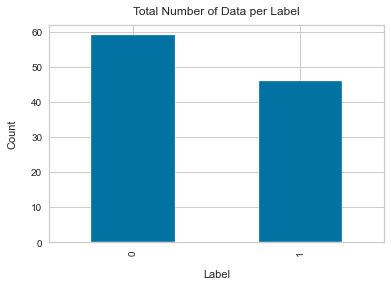

In [8]:
# bar graph to show the number of data per labels
print(y_train.value_counts())
y_train.value_counts().plot(kind='bar')
plt.xlabel("Label", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Total Number of Data per Label", y=1.02)

In [9]:
#https://www.kaggle.com/code/qianchao/smote-with-imbalance-data
# X_train_b --> balanced
print("Before Oversampling, counts of label '1' : {}".format(sum(y_train==1)))
print("Before Oversampling, counts of label '0' : {} \n".format(sum(y_train==0)))

# smote analysis
sm = SMOTE(random_state=42)
X_train_b, y_train_b = sm.fit_resample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_b.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_b.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_b==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_b==0)))


Before Oversampling, counts of label '1' : 46
Before Oversampling, counts of label '0' : 59 

After OverSampling, the shape of train_X: (118, 5833)
After OverSampling, the shape of train_y: (118,) 

After OverSampling, counts of label '1': 59
After OverSampling, counts of label '0': 59


In [10]:
a = np.array(y_train_b)
a = pd.DataFrame(a)
print(a.value_counts())

0    59
1    59
dtype: int64


0    59
1    59
dtype: int64


Text(0.5, 1.02, 'Total Number of Data per Label')

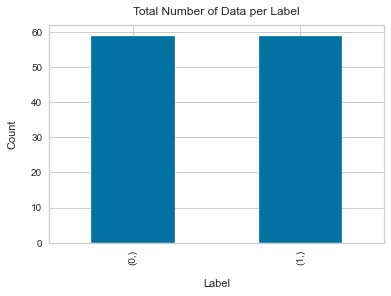

In [11]:
# bar graph to show the number of data per labels
print(a.value_counts())
a.value_counts().plot(kind='bar')
plt.xlabel("Label", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Total Number of Data per Label", y=1.02)

### Classification Models Function

In [12]:
#https://www.kaggle.com/code/mnpathak1/model-comparison-with-roc-curves-and-more

# without cross validation
def trainModels(X_train, y_train, X_test, y_test):
        acc = []
        precision = []
        recall = []
        specificity = []
        f1 = []
        fpr_list = []
        tpr_list = []
        roc_auc = []
        classifiers = ['SVM', 'AdaBoost', 'Random Forest', 'XGBoost']
        models=[SVC(kernel='rbf', verbose=True, random_state=42, probability=True), 
                AdaBoostClassifier(random_state=42),
                RandomForestClassifier(n_estimators=100,random_state=42, verbose=True),
                XGBClassifier(random_state=42)] 
        for i in models :
            model = i
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test) 
            y_pred_prob = model.predict_proba(X_test)[:,1]
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
            acc.append(accuracy_score(y_pred, y_test))
            precision.append(precision_score(y_pred, y_test))
            recall.append(recall_score(y_test, y_pred, pos_label=1))
            specificity.append(recall_score(y_test,y_pred, pos_label=0))
            f1.append(f1_score(y_test, y_pred))
            fpr_list.append(fpr)
            tpr_list.append(tpr)
            roc_auc.append(auc(fpr,tpr))

        # plot the auc-roc curve
        plt.figure(figsize=[5,5])
        plt.plot([0,1],[0,1], 'k--')
        plt.plot(fpr_list[0],tpr_list[0], label = str(classifiers[0]) + '(area =%0.03f)'% roc_auc[0])
        plt.plot(fpr_list[1],tpr_list[1], label = str(classifiers[1]) + '(area =%0.03f)'% roc_auc[1])
        plt.plot(fpr_list[2],tpr_list[2], label = str(classifiers[2]) + '(area =%0.03f)'% roc_auc[2])
        plt.plot(fpr_list[3],tpr_list[3], label = str(classifiers[3]) + '(area =%0.03f)'% roc_auc[3])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curves from the investigated models')
        plt.legend(loc='best')
        plt.show()
            
        models_df = pd.DataFrame(list(zip(acc,precision, recall,specificity, f1)), index=classifiers)
        models_df.columns=['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1']

        # plot bar graph
        models_df_t = models_df.transpose()
        models_df_t.plot(figsize=(6,6),kind='bar')
        plt.legend(bbox_to_anchor=(1.0, 1.0), title='Labels')
        plt.title('Performance of Classification Models')
        plt.ylabel('Score')
        plt.xlabel('Evaluation Metrics')
        return models_df

# with cross validation
def trainModelsCV(X_train, y_train):
    kfold = KFold(n_splits=10)
    acc = []
    precision = []
    recall = []
    specificity_list = []
    f1 = []
    classifiers = ['SVM', 'AdaBoost', 'Random Forest', 'XGBoost']
    models=[SVC(kernel='rbf', verbose=True, random_state=42), 
            AdaBoostClassifier(random_state=42),
            RandomForestClassifier(n_estimators=100,random_state=42),
            XGBClassifier(random_state=42)] 
    
    for i in models :
        model = i
        specificity = make_scorer(recall_score, pos_label=0)
        acc.append(cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy').mean())
        precision.append(cross_val_score(model, X_train, y_train, cv=kfold, scoring='precision').mean())
        recall.append(cross_val_score(model, X_train, y_train, cv=kfold, scoring='recall').mean())
        specificity_list.append(cross_val_score(model, X_train, y_train, cv=kfold, scoring=specificity).mean())
        f1.append(cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1').mean())
    models_df = pd.DataFrame(list(zip(acc,precision, recall, specificity_list, f1)), index=classifiers)
    models_df.columns=['Accuracy Mean', 'Precision Mean', 'Recall Mean', 'Specificity Mean','F1 Mean']

    # plot bar graph
    models_df_t = models_df.transpose()
    models_df_t.plot(figsize=(6,6),kind='bar')
    plt.legend(bbox_to_anchor=(1.0, 1.0), title='Labels')
    plt.title('Performance of Classification Models')
    plt.ylabel('Score')
    plt.xlabel('Evaluation Metrics')
    
    return models_df

### Pairwise Function

https://towardsdatascience.com/how-to-use-pairwise-correlation-for-robust-feature-selection-20a60ef7d10

In [13]:
def correlation_matrix(df: pd.DataFrame):
    matrix = df.corr()
    cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    fig, ax = plt.subplots(figsize=(16,12))
    _ = sns.heatmap(matrix, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap, ax=ax)

In [14]:
# function to drop highly related columns
def drop_cols(df, threshold):
    matrix = df.corr().abs()
    mask = np.triu(np.ones_like(matrix,dtype=bool))
    reduced_matrix = matrix.mask(mask)
    cols = [c for c in reduced_matrix.columns if any(reduced_matrix[c] > threshold)]
    return cols

### Top Features Function

In [15]:
def topFeatures(df, X_train, X_test, i):
    # get the top 20 features
    # sort the df values
    feat_selection_list = ['mRMR', 'Select K Best', 'Lasso-Based Feature Selection', 'ElasticNet Feature Selection', 'Random Forest Feature Importance']
    df_descending = df.sort_values(by='Score', ascending=False)
    df_feat = df_descending[:20].copy()
    print('DF shape :', df_feat.shape)
    print(df_feat)

    # top 20 features in bar graph
    df_feat.plot(kind='barh', 
                  x='Features',
                  y='Score',
                  title='Top 20 Feature Scores Using '+ str(feat_selection_list[i]),
                  figsize=(10,10))

    # make the features as index
    df_feat = df_feat.set_index(df_feat.columns[0])

    # get top features list name 
    feat_names = df_feat.index
    col_list = list(feat_names)

    # drop the columns that are not in the list 
    X_train_drop = X_train.drop(columns=[col for col in X_train if col not in col_list])
    X_test_drop = X_test.drop(columns=[col for col in X_test if col not in col_list])
    print('X train shape :', X_train_drop.shape)
    print('X test shape :', X_test_drop.shape)

    return df_feat, X_train_drop, X_test_drop

### Classification without Feature Selection

[LibSVM]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


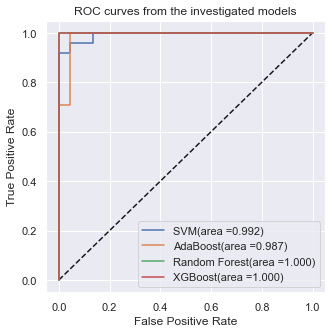

Accuracy  Precision    Recall  Specificity        F1
SVM            0.934783   0.875000  0.875000     1.000000  0.933333
AdaBoost       0.978261   1.000000  1.000000     0.954545  0.979592
Random Forest  0.978261   0.958333  0.958333     1.000000  0.978723
XGBoost        0.978261   1.000000  1.000000     0.954545  0.979592

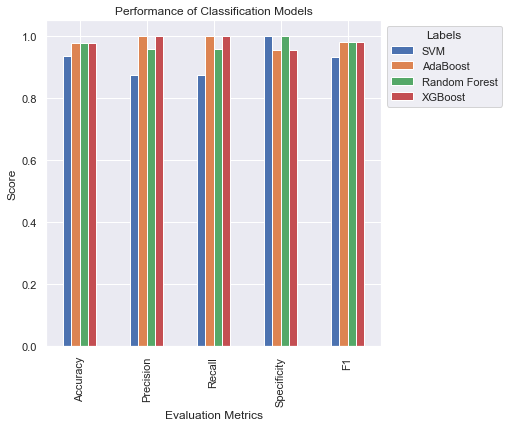

In [42]:
trainModels(X_train_b,y_train_b,X_test,y_test)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

Accuracy Mean  Precision Mean  Recall Mean  Specificity Mean  \
SVM                 0.915152        0.874484     0.970833          0.765873   
AdaBoost            0.940909        0.944048     0.941667          0.847222   
Random Forest       0.957576        0.945833     0.967500          0.847222   
XGBoost             0.949242        0.952222     0.950833          0.844048   

                F1 Mean  
SVM            0.912678  
AdaBoost       0.936623  
Random Forest  0.953012  
XGBoost        0.949269

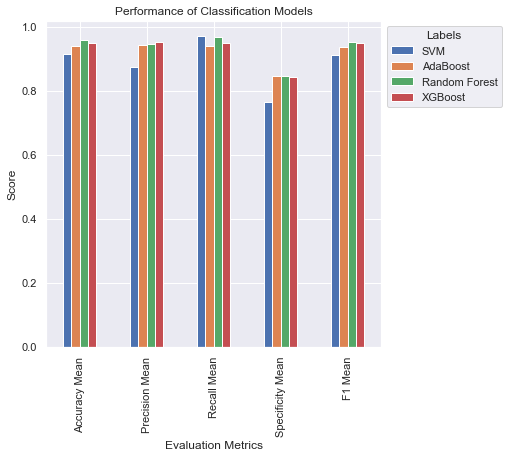

In [44]:
trainModelsCV(X_train_b,y_train_b)

### Feature Selection
mRMR, sKb, Lasso-based feature selection, Elastic-net feature selection, Random Forest feature selection 


#### Select K Best

In [16]:
# use select k best to select the features with the best chi-squared
chi2_features = SelectKBest(chi2, k=500) 
feat = chi2_features.fit(X_train_b,y_train_b)

In [17]:
# get the scores and features
dfScores = pd.DataFrame(feat.scores_)
dfColumns = pd.DataFrame(X_train.columns)
dfFeatureScores_skb = pd.concat([dfColumns,dfScores],axis=1)
dfFeatureScores_skb.columns = ['Features','Score']
print('dfFeatureScores. :' ,dfFeatureScores_skb.shape)
dfFeatureScores_skb.head()

dfFeatureScores. : (5833, 2)


Features     Score
0                         Absicoccus_porci  0.087760
1              Absicoccus_porci|t__SGB6818  0.087760
2             Acidaminococcaceae_bacterium  1.985302
3  Acidaminococcaceae_bacterium|t__SGB5789  0.000350
4  Acidaminococcaceae_bacterium|t__SGB5790  1.984962

DF shape : (20, 2)
                                    Features       Score
5792                            unclassified  537.935310
5820             unclassified|g__Phocaeicola  467.932390
5038                   _Phocaeicola_vulgatus  244.979120
5039        _Phocaeicola_vulgatus|t__SGB1814  244.979120
1101            Faecalibacterium_prausnitzii  210.798798
5821                               uniformis  183.704210
5822              uniformis|t__SGB1836_group  183.704210
5681                              putredinis  145.261770
5682                   putredinis|t__SGB2318  145.261770
3756        _Cutibacterium_acnes|t__SGB16955  139.695620
3755                    _Cutibacterium_acnes  139.695620
5614                                   mitis  134.427480
5616                        mitis|t__SGB8163  134.303110
2319         Phocaeicola_vulgatus|t__SGB1814  130.195456
2318                    Phocaeicola_vulgatus  130.195456
5035  _Phocaeicola_plebeius|t__SGB1903_group  115.507470
5034        

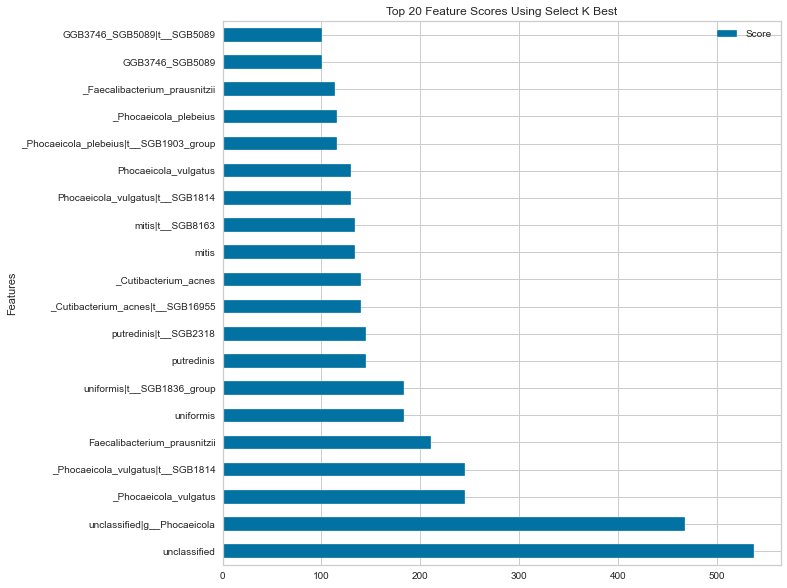

In [18]:
df_skb_20, X_train_skb, X_test_skb = topFeatures(dfFeatureScores_skb, X_train_b, X_test, 1)

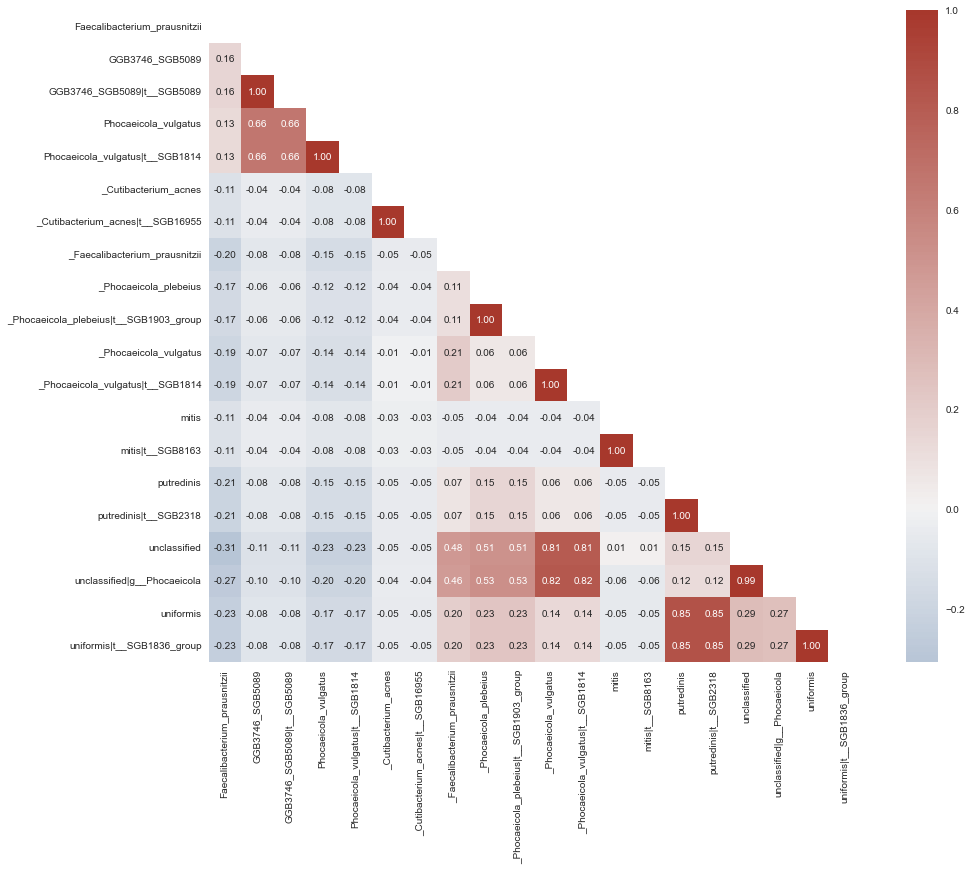

In [19]:
# pairwise correlation 
correlation_matrix(X_train_skb)

In [20]:
# drop highly related cols
cols = drop_cols(X_train_skb,.9)
cols

['GGB3746_SGB5089',
 'Phocaeicola_vulgatus',
 '_Cutibacterium_acnes',
 '_Phocaeicola_plebeius',
 '_Phocaeicola_vulgatus',
 'mitis',
 'putredinis',
 'unclassified',
 'uniformis']

In [21]:
# drop the columns that are highly related
X_train_skb = X_train_skb.drop(cols, axis=1)
X_test_skb = X_test_skb.drop(cols, axis=1)
print('X train shape :', X_train_skb.shape)
print('X test shape :', X_test_skb.shape)

X train shape : (118, 11)
X test shape : (46, 11)


[LibSVM]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


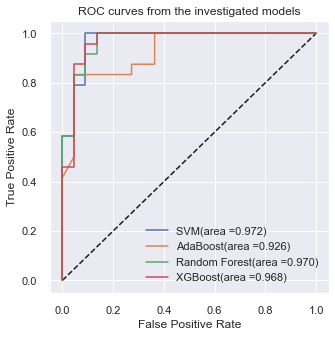

Accuracy  Precision    Recall  Specificity        F1
SVM            0.956522   1.000000  1.000000     0.909091  0.960000
AdaBoost       0.869565   0.791667  0.791667     0.954545  0.863636
Random Forest  0.891304   0.875000  0.875000     0.909091  0.893617
XGBoost        0.891304   0.833333  0.833333     0.954545  0.888889

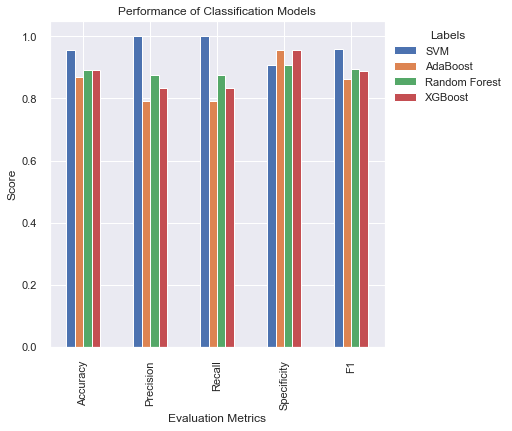

In [95]:
trainModels(X_train_skb,y_train_b, X_test_skb, y_test)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

Accuracy Mean  Precision Mean  Recall Mean  Specificity Mean  \
SVM                 0.789394        0.726667     0.942500          0.567460   
AdaBoost            0.881818        0.854762     0.897500          0.740873   
Random Forest       0.881061        0.825833     0.967500          0.698810   
XGBoost             0.863636        0.811310     0.914167          0.698810   

                F1 Mean  
SVM            0.800762  
AdaBoost       0.864674  
Random Forest  0.881879  
XGBoost        0.854874

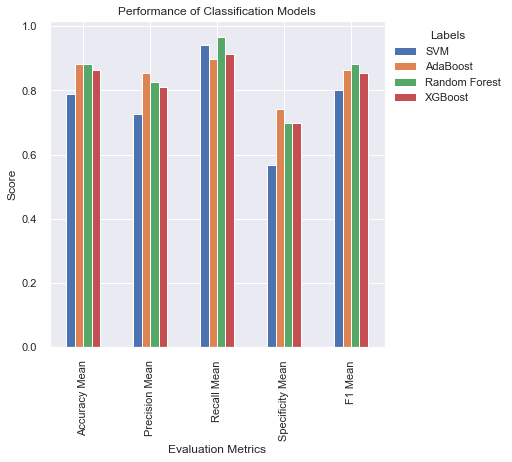

In [96]:
trainModelsCV(X_train_skb,y_train_b)

#### Random Forest Feature Selection

https://www.blog.trainindata.com/feature-selection-machine-learning-with-python/
https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection

In [22]:
# https://www.kaggle.com/code/prashant111/random-forest-classifier-feature-importance

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_b, y_train_b)

RandomForestClassifier(random_state=42)

In [23]:
# get the scores and features
dfScores = pd.DataFrame(rf.feature_importances_)
dfColumns = pd.DataFrame(X_train_b.columns)
dfFeatureScores_RF = pd.concat([dfColumns,dfScores],axis=1)
dfFeatureScores_RF.columns = ['Features','Score']
print('dfFeatureScores. :' ,dfFeatureScores_RF.shape)
dfFeatureScores_RF.head()

dfFeatureScores. : (5833, 2)


Features  Score
0                         Absicoccus_porci    0.0
1              Absicoccus_porci|t__SGB6818    0.0
2             Acidaminococcaceae_bacterium    0.0
3  Acidaminococcaceae_bacterium|t__SGB5789    0.0
4  Acidaminococcaceae_bacterium|t__SGB5790    0.0

DF shape : (20, 2)
                                               Features     Score
1049                                   Escherichia_coli  0.037797
50                      Agathobaculum_butyriciproducens  0.029278
51    Agathobaculum_butyriciproducens|t__SGB14993_group  0.020703
737                            Clostridiaceae_bacterium  0.019707
792                       Clostridium_fessum|t__SGB4705  0.018204
1050                       Escherichia_coli|t__SGB10068  0.016916
330                      Blautia_obeum|t__SGB4811_group  0.016573
348                                    Blautia_wexlerae  0.016287
1016             Enterocloster_bolteae|t__SGB4758_group  0.016244
949                                   Dorea_longicatena  0.013396
244                       Bacteroides_ovatus|t__SGB1871  0.013165
326                                Blautia_massiliensis  0.011948
791                                  Clostridium_fessum  0.011678
270              Bacteroides_uniformis|t__SGB1836_group  

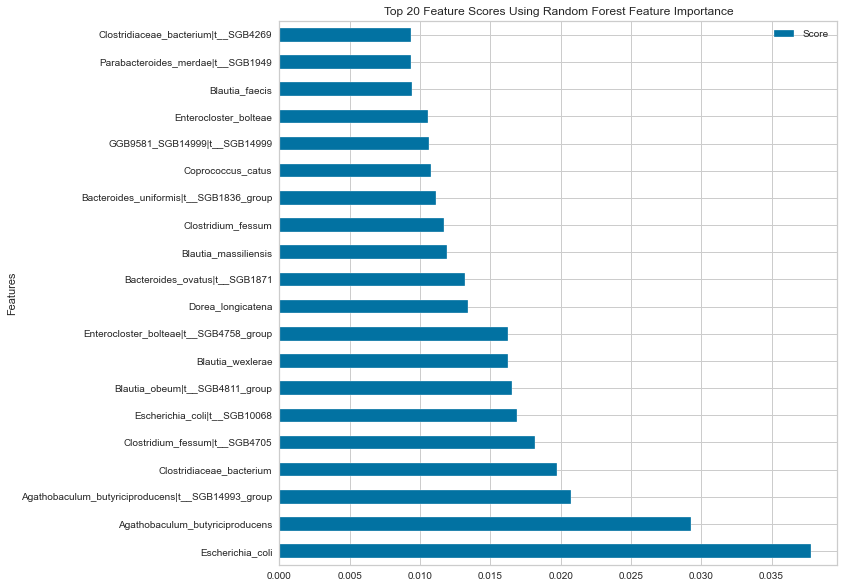

In [24]:
df_RF_20, X_train_rf, X_test_rf = topFeatures(dfFeatureScores_RF, X_train_b, X_test, 4)

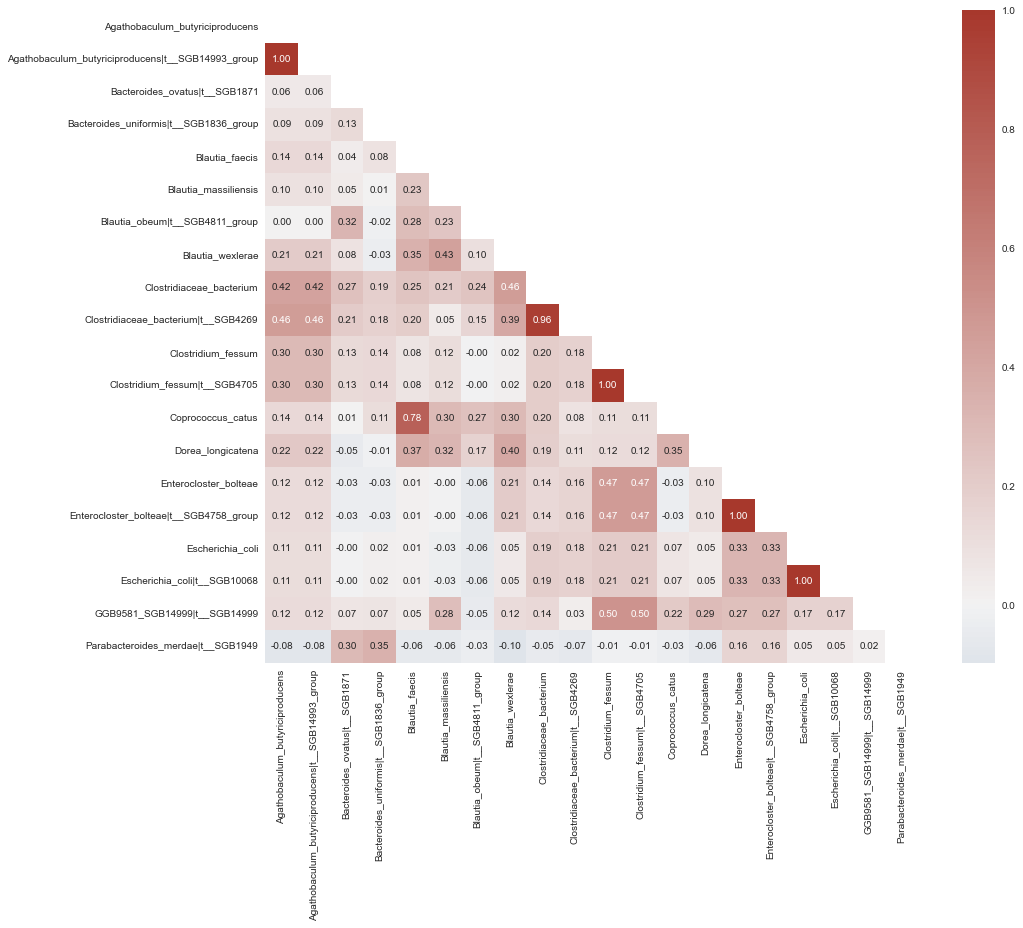

In [25]:
# pairwise correlation 
correlation_matrix(X_train_rf)

In [26]:
# drop highly related cols
cols = drop_cols(X_train_rf,.9)
cols

['Agathobaculum_butyriciproducens',
 'Clostridiaceae_bacterium',
 'Clostridium_fessum',
 'Enterocloster_bolteae',
 'Escherichia_coli']

In [27]:
# drop the columns that are highly related
X_train_rf = X_train_rf.drop(cols, axis=1)
X_test_rf = X_test_rf.drop(cols, axis=1)
print('X train shape :', X_train_rf.shape)
print('X test shape :', X_test_rf.shape)

X train shape : (118, 15)
X test shape : (46, 15)


[LibSVM]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


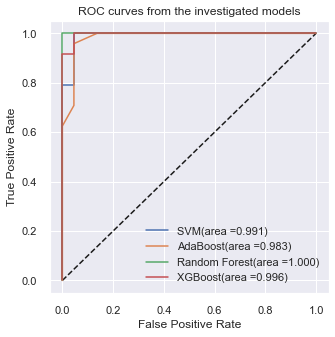

Accuracy  Precision    Recall  Specificity        F1
SVM            0.913043   0.875000  0.875000     0.954545  0.913043
AdaBoost       0.934783   0.916667  0.916667     0.954545  0.936170
Random Forest  0.978261   0.958333  0.958333     1.000000  0.978723
XGBoost        0.956522   0.958333  0.958333     0.954545  0.958333

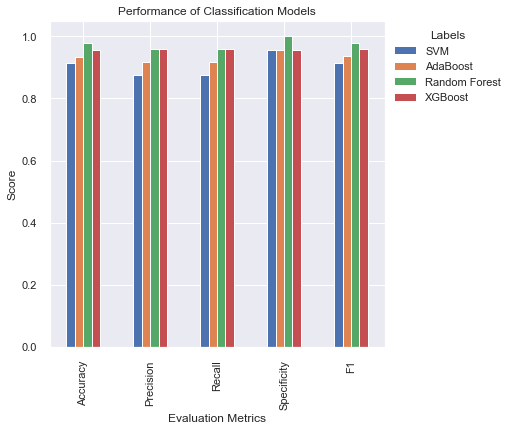

In [21]:
trainModels(X_train_rf,y_train_b, X_test_rf, y_test)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

Accuracy Mean  Precision Mean  Recall Mean  Specificity Mean  \
SVM                 0.889394        0.891111     0.845152          0.796825   
AdaBoost            0.965909        0.966667     0.966667          0.869048   
Random Forest       0.982576        0.983333     0.983333          0.883333   
XGBoost             0.966667        0.968889     0.963333          0.860714   

                F1 Mean  
SVM            0.847196  
AdaBoost       0.961818  
Random Forest  0.981818  
XGBoost        0.965027

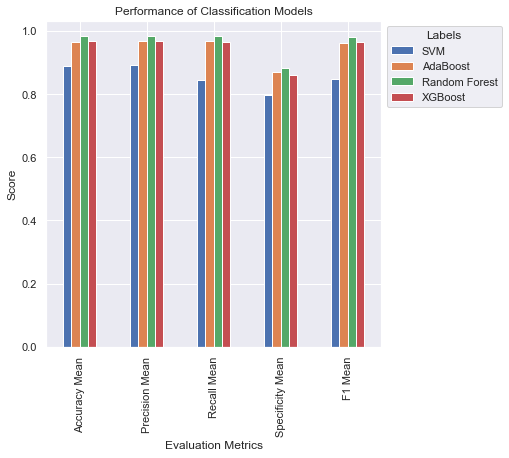

In [67]:
trainModelsCV(X_train_rf,y_train_b)

#### mRMR
https://towardsdatascience.com/mrmr-explained-exactly-how-you-wished-someone-explained-to-you-9cf4ed27458b

In [28]:
# select top 20 features using mRMR
mRMR_features = mrmr_classif(X=X_train_b, y=y_train_b, K=20)
mRMR_features

100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


['Faecalibacterium_prausnitzii',
 'Massilioclostridium_coli',
 'Romboutsia_timonensis',
 'Bacteroides_gallinarum',
 'Clostridiales_bacterium|t__SGB15158',
 'Bilophila_wadsworthia',
 'Lachnospiraceae_bacterium',
 'Clostridium_fessum',
 'Faecalibacterium_prausnitzii|t__SGB15342',
 'Bilophila_wadsworthia|t__SGB15452',
 'Ruminococcaceae_bacterium|t__SGB4181',
 'Dorea_formicigenerans',
 'Faecalibacterium_prausnitzii|t__SGB15316_group',
 'Clostridia_unclassified_SGB4121',
 'unclassified',
 'Clostridium_fessum|t__SGB4705',
 'Parabacteroides_distasonis',
 'Faecalibacterium_prausnitzii|t__SGB15318_group',
 'Dorea_formicigenerans|t__SGB4575',
 'Parabacteroides_distasonis|t__SGB1934']

In [29]:
dfFeatures_mRMR = pd.DataFrame(mRMR_features)
dfFeatures_mRMR.columns = ['Features']
dfFeatures_mRMR.head()

Features
0         Faecalibacterium_prausnitzii
1             Massilioclostridium_coli
2                Romboutsia_timonensis
3               Bacteroides_gallinarum
4  Clostridiales_bacterium|t__SGB15158

In [30]:
# make the features as index
df_mRMR_20 = dfFeatures_mRMR.set_index(dfFeatures_mRMR.columns[0])

# get top 10  names
feat_names = df_mRMR_20.index
col_list = list(feat_names)

# drop the columns that are not in the list 
X_train_mRMR = X_train_b.drop(columns=[col for col in X_train_b if col not in col_list])
X_test_mRMR = X_test.drop(columns=[col for col in X_test if col not in col_list])
print('X train shape :', X_train_mRMR.shape)
print('X test shape :', X_test_mRMR.shape)

X train shape : (118, 20)
X test shape : (46, 20)


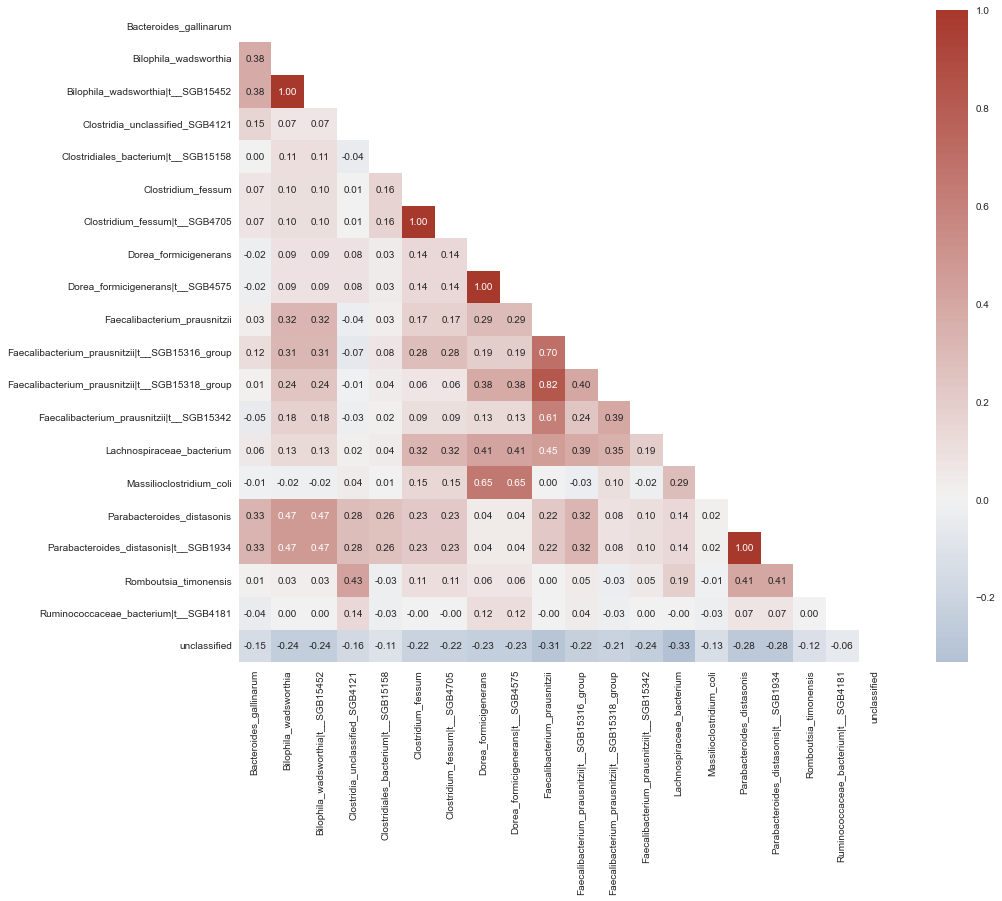

In [31]:
# pairwise correlation 
correlation_matrix(X_train_mRMR)

In [32]:
# drop highly related cols
cols = drop_cols(X_train_mRMR,.9)
cols

['Bilophila_wadsworthia',
 'Clostridium_fessum',
 'Dorea_formicigenerans',
 'Parabacteroides_distasonis']

In [33]:
# drop the columns that are highly related
X_train_mRMR = X_train_mRMR.drop(cols, axis=1)
X_test_mRMR = X_test_mRMR.drop(cols, axis=1)
print('X train shape :', X_train_mRMR.shape)
print('X test shape :', X_test_mRMR.shape)

X train shape : (118, 16)
X test shape : (46, 16)


[LibSVM]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


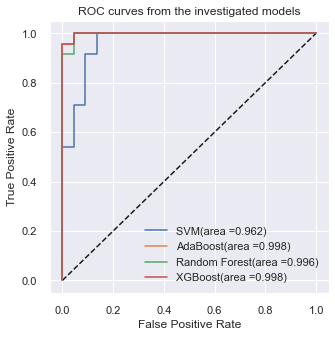

Accuracy  Precision    Recall  Specificity        F1
SVM            0.826087   0.750000  0.750000     0.909091  0.818182
AdaBoost       0.956522   0.958333  0.958333     0.954545  0.958333
Random Forest  0.956522   0.916667  0.916667     1.000000  0.956522
XGBoost        0.934783   0.875000  0.875000     1.000000  0.933333

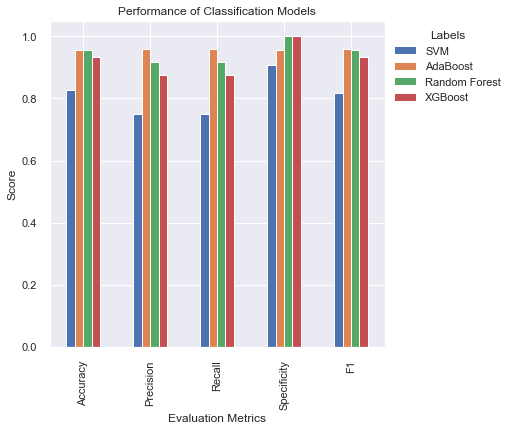

In [103]:
trainModels(X_train_mRMR,y_train_b, X_test_mRMR, y_test)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

Accuracy Mean  Precision Mean  Recall Mean  Specificity Mean  \
SVM                 0.839394        0.884762     0.793409          0.794444   
AdaBoost            0.915152        0.944643     0.889167          0.816667   
Random Forest       0.931818        0.958929     0.930000          0.841667   
XGBoost             0.931818        0.944643     0.942500          0.816667   

                F1 Mean  
SVM            0.823479  
AdaBoost       0.905833  
Random Forest  0.936645  
XGBoost        0.939722

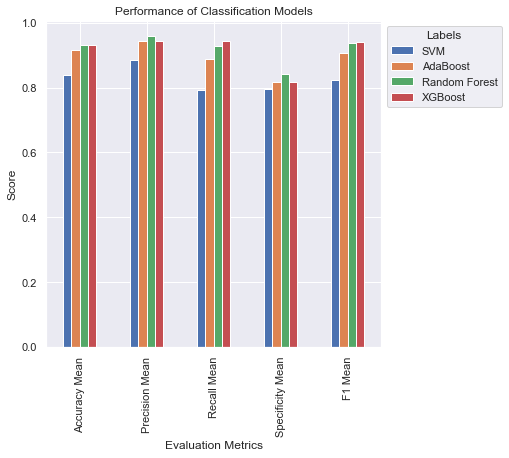

In [76]:
trainModelsCV(X_train_mRMR,y_train_b)

#### Lasso-based 
https://towardsdatascience.com/feature-selection-in-machine-learning-using-lasso-regression-7809c7c2771a

In [34]:
# lasso have to scale data
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])

In [35]:
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

In [36]:
search.fit(X_train_b,y_train_b)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END .................model__alpha=0.1;, score=-0.080 total time=   0.1s
[CV 2/5] END .................model__alpha=0.1;, score=-0.092 total time=   0.1s
[CV 3/5] END .................model__alpha=0.1;, score=-0.141 total time=   0.1s
[CV 4/5] END .................model__alpha=0.1;, score=-1.224 total time=   0.1s
[CV 5/5] END .................model__alpha=0.1;, score=-0.122 total time=   0.1s
[CV 1/5] END .................model__alpha=0.2;, score=-0.195 total time=   0.1s
[CV 2/5] END .................model__alpha=0.2;, score=-0.180 total time=   0.0s
[CV 3/5] END .................model__alpha=0.2;, score=-0.174 total time=   0.0s
[CV 4/5] END .................model__alpha=0.2;, score=-0.223 total time=   0.0s
[CV 5/5] END .................model__alpha=0.2;, score=-0.193 total time=   0.1s
[CV 1/5] END .model__alpha=0.30000000000000004;, score=-0.266 total time=   0.1s
[CV 2/5] END .model__alpha=0.30000000000000004;

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             scoring='neg_mean_squared_error', verbose=3)

In [37]:
search.best_params_

{'model__alpha': 0.2}

In [38]:
coefficients = search.best_estimator_.named_steps['model'].coef_

In [39]:
importance = np.abs(coefficients)
importance

array([0., 0., 0., ..., 0., 0., 0.])

In [40]:
dfScores_Lasso = pd.DataFrame(importance)
dfColumns_Lasso = pd.DataFrame(X_train_b.columns)
dfFeatureScores_Lasso = pd.concat([dfColumns_Lasso,dfScores_Lasso],axis=1)
dfFeatureScores_Lasso.columns = ['Features','Score']
print('dfFeatureScores_Lasso :' ,dfFeatureScores_Lasso.shape)
dfFeatureScores_Lasso.head()

dfFeatureScores_Lasso : (5833, 2)


Features  Score
0                         Absicoccus_porci    0.0
1              Absicoccus_porci|t__SGB6818    0.0
2             Acidaminococcaceae_bacterium    0.0
3  Acidaminococcaceae_bacterium|t__SGB5789    0.0
4  Acidaminococcaceae_bacterium|t__SGB5790    0.0

In [41]:
# features taht are not equal to 0
df_Lasso = dfFeatureScores_Lasso[dfFeatureScores_Lasso['Score'] != 0]
df_Lasso

Features         Score
299                   Bilophila_wadsworthia  3.212664e-02
300       Bilophila_wadsworthia|t__SGB15452  2.107542e-16
1101           Faecalibacterium_prausnitzii  7.098994e-02
1926              Lachnospiraceae_bacterium  3.737206e-02
2239             Parabacteroides_distasonis  5.321328e-03
2240  Parabacteroides_distasonis|t__SGB1934  1.806465e-16

DF shape : (6, 2)
                                   Features         Score
1101           Faecalibacterium_prausnitzii  7.098994e-02
1926              Lachnospiraceae_bacterium  3.737206e-02
299                   Bilophila_wadsworthia  3.212664e-02
2239             Parabacteroides_distasonis  5.321328e-03
300       Bilophila_wadsworthia|t__SGB15452  2.107542e-16
2240  Parabacteroides_distasonis|t__SGB1934  1.806465e-16
X train shape : (118, 6)
X test shape : (46, 6)


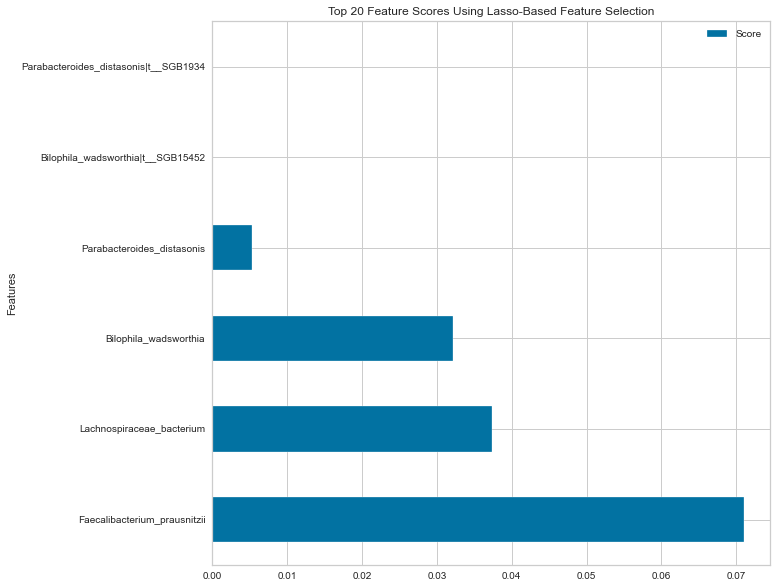

In [42]:
df_Lasso, X_train_Lasso, X_test_Lasso = topFeatures(df_Lasso, X_train_b, X_test, 2)

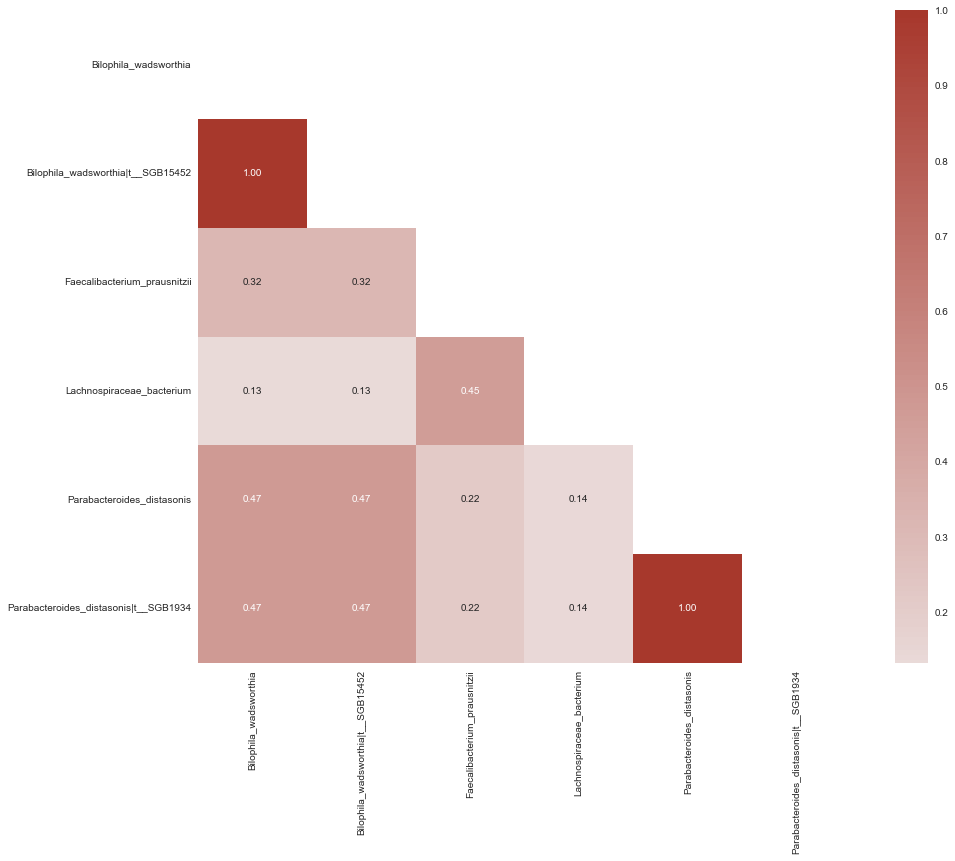

In [43]:
correlation_matrix(X_train_Lasso)

In [44]:
# drop highly related cols
cols = drop_cols(X_train_Lasso,0.9)
cols

['Bilophila_wadsworthia', 'Parabacteroides_distasonis']

In [45]:
# drop the columns that are highly related
X_train_Lasso = X_train_Lasso.drop(cols, axis=1)
X_test_Lasso = X_test_Lasso.drop(cols, axis=1)
print('X train shape :', X_train_Lasso.shape)
print('X test shape :', X_test_Lasso.shape)

X train shape : (118, 4)
X test shape : (46, 4)


[LibSVM]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


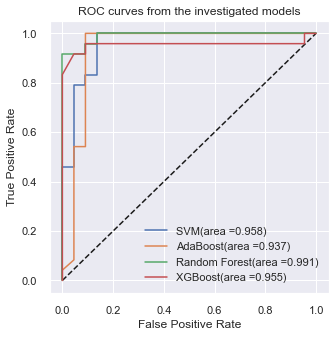

Accuracy  Precision    Recall  Specificity        F1
SVM            0.869565   0.833333  0.833333     0.909091  0.869565
AdaBoost       0.891304   0.875000  0.875000     0.909091  0.893617
Random Forest  0.934783   0.875000  0.875000     1.000000  0.933333
XGBoost        0.891304   0.791667  0.791667     1.000000  0.883721

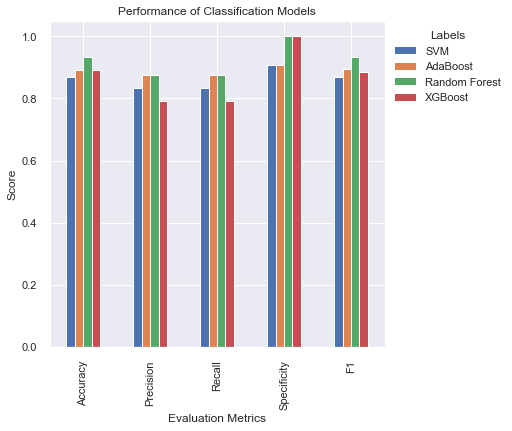

In [116]:
trainModels(X_train_Lasso, y_train_b, X_test_Lasso, y_test)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

Accuracy Mean  Precision Mean  Recall Mean  Specificity Mean  \
SVM                 0.856061        0.869643       0.8475          0.752778   
AdaBoost            0.931818        0.943651       0.9350          0.827381   
Random Forest       0.923485        0.919643       0.9425          0.805556   
XGBoost             0.923485        0.927976       0.9425          0.802381   

                F1 Mean  
SVM            0.846642  
AdaBoost       0.929074  
Random Forest  0.925437  
XGBoost        0.930631

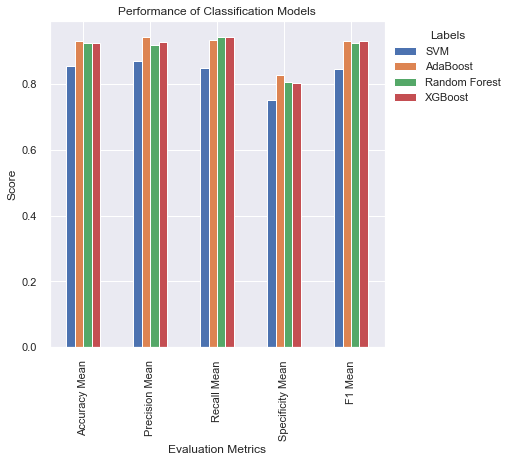

In [384]:
trainModelsCV(X_train_Lasso, y_train_b)

#### Elastic Net
https://www.kaggle.com/code/cast42/feature-selection-and-elastic-net/notebook

In [46]:
pipeline = Pipeline([
                     ('model',ElasticNet())
])

In [47]:
search = GridSearchCV(pipeline, 
                      {'model__alpha':np.arange(0.1,10,0.1),
                       'model__l1_ratio':[1.5, 1.1, 1, 0.9, 0.8, 0.7, 0.5]}, cv=2,
                        scoring='neg_mean_squared_error', verbose=3)

In [48]:
search.fit(X_train_b,y_train_b)

Fitting 2 folds for each of 693 candidates, totalling 1386 fits
[CV 1/2] END model__alpha=0.1, model__l1_ratio=1.5;, score=nan total time=   0.0s
[CV 2/2] END model__alpha=0.1, model__l1_ratio=1.5;, score=nan total time=   0.0s
[CV 1/2] END model__alpha=0.1, model__l1_ratio=1.1;, score=nan total time=   0.0s
[CV 2/2] END model__alpha=0.1, model__l1_ratio=1.1;, score=nan total time=   0.0s
[CV 1/2] END model__alpha=0.1, model__l1_ratio=1;, score=-0.156 total time=   0.0s
[CV 2/2] END model__alpha=0.1, model__l1_ratio=1;, score=-0.267 total time=   0.1s
[CV 1/2] END model__alpha=0.1, model__l1_ratio=0.9;, score=-0.159 total time=   0.3s
[CV 2/2] END model__alpha=0.1, model__l1_ratio=0.9;, score=-0.269 total time=   0.3s
[CV 1/2] END model__alpha=0.1, model__l1_ratio=0.8;, score=-0.163 total time=   0.3s
[CV 2/2] END model__alpha=0.1, model__l1_ratio=0.8;, score=-0.273 total time=   0.2s
[CV 1/2] END model__alpha=0.1, model__l1_ratio=0.7;, score=-0.168 total time=   0.2s
[CV 2/2] END mode

GridSearchCV(cv=2, estimator=Pipeline(steps=[('model', ElasticNet())]),
             param_grid={'model__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9]),
                         'model__l1_ratio': [1.5, 1.1, 1, 0.9, 0.8, 0.7, 0.5]},
             scoring='neg_mean_squared_error', verbose=3)

In [49]:
search.best_params_

{'model__alpha': 0.4, 'model__l1_ratio': 0.9}

In [50]:
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)
importance

array([0., 0., 0., ..., 0., 0., 0.])

In [51]:
dfScores_EN = pd.DataFrame(importance)
dfColumns_EN = pd.DataFrame(X_train_b.columns)
dfFeatureScores_EN = pd.concat([dfColumns_EN,dfScores_EN],axis=1)
dfFeatureScores_EN.columns = ['Features','Score']
print('dfFeatureScores_EN :' ,dfFeatureScores_EN.shape)
dfFeatureScores_EN.head()

dfFeatureScores_EN : (5833, 2)


Features  Score
0                         Absicoccus_porci    0.0
1              Absicoccus_porci|t__SGB6818    0.0
2             Acidaminococcaceae_bacterium    0.0
3  Acidaminococcaceae_bacterium|t__SGB5789    0.0
4  Acidaminococcaceae_bacterium|t__SGB5790    0.0

In [52]:
# features taht are not equal to 0
df_EN = dfFeatureScores_EN[dfFeatureScores_EN['Score'] != 0]
df_EN

Features     Score
269                    Bacteroides_uniformis  0.000221
270   Bacteroides_uniformis|t__SGB1836_group  0.000054
1101            Faecalibacterium_prausnitzii  0.040893
2318                    Phocaeicola_vulgatus  0.003812
2319         Phocaeicola_vulgatus|t__SGB1814  0.000357
3755                    _Cutibacterium_acnes  0.002808
3756        _Cutibacterium_acnes|t__SGB16955  0.000306
5455                               crispatus  0.000359
5456                    crispatus|t__SGB7045  0.000023
5614                                   mitis  0.001630
5792                            unclassified  0.013612
5821                               uniformis  0.002851
5822              uniformis|t__SGB1836_group  0.000723

DF shape : (13, 2)
                                    Features     Score
1101            Faecalibacterium_prausnitzii  0.040893
5792                            unclassified  0.013612
2318                    Phocaeicola_vulgatus  0.003812
5821                               uniformis  0.002851
3755                    _Cutibacterium_acnes  0.002808
5614                                   mitis  0.001630
5822              uniformis|t__SGB1836_group  0.000723
5455                               crispatus  0.000359
2319         Phocaeicola_vulgatus|t__SGB1814  0.000357
3756        _Cutibacterium_acnes|t__SGB16955  0.000306
269                    Bacteroides_uniformis  0.000221
270   Bacteroides_uniformis|t__SGB1836_group  0.000054
5456                    crispatus|t__SGB7045  0.000023
X train shape : (118, 13)
X test shape : (46, 13)


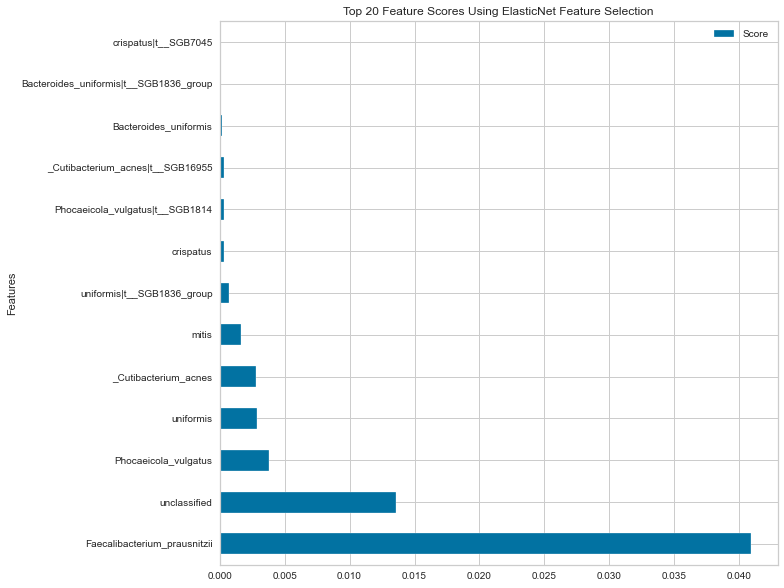

In [53]:
df_EN, X_train_EN, X_test_EN = topFeatures(df_EN, X_train_b, X_test, 3)

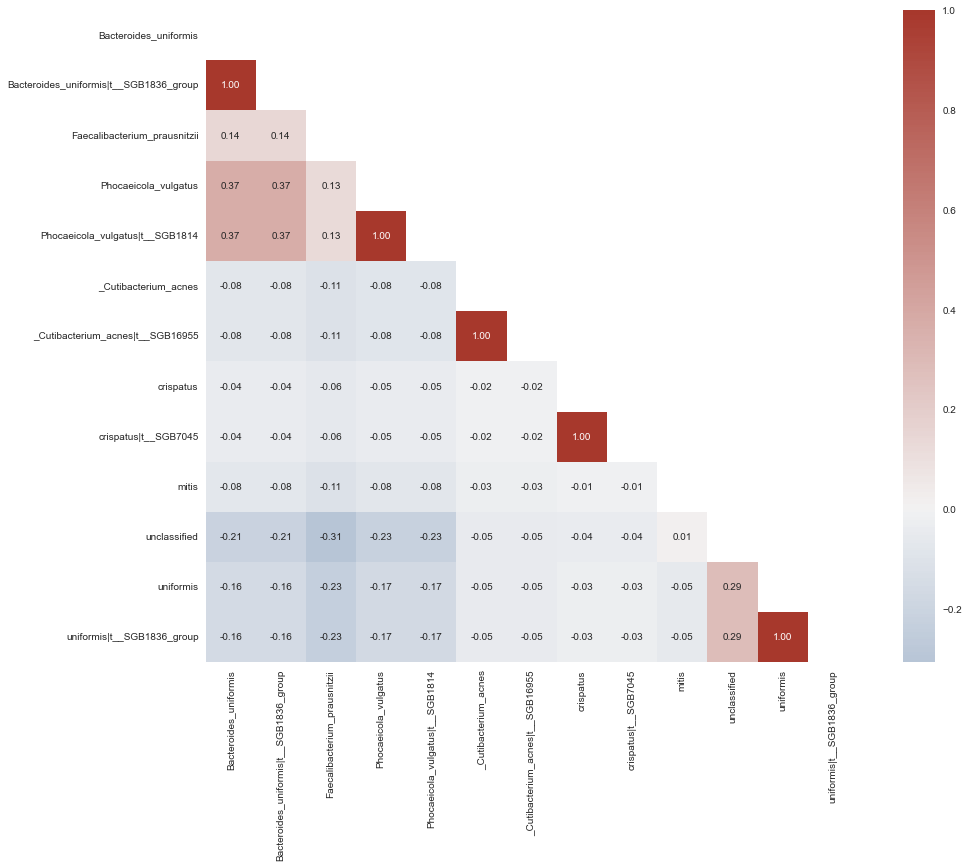

In [54]:
correlation_matrix(X_train_EN)

In [55]:
# drop highly related cols
cols = drop_cols(X_train_EN,0.9)
cols

['Bacteroides_uniformis',
 'Phocaeicola_vulgatus',
 '_Cutibacterium_acnes',
 'crispatus',
 'uniformis']

In [56]:
# drop the columns that are highly related
X_train_EN = X_train_EN.drop(cols, axis=1)
X_test_EN = X_test_EN.drop(cols, axis=1)
print('X train shape :', X_train_EN.shape)
print('X test shape :', X_test_EN.shape)

X train shape : (118, 8)
X test shape : (46, 8)


[LibSVM]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


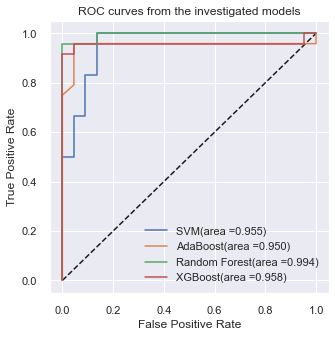

Accuracy  Precision    Recall  Specificity        F1
SVM            0.891304   0.916667  0.916667     0.863636  0.897959
AdaBoost       0.891304   0.833333  0.833333     0.954545  0.888889
Random Forest  0.913043   0.833333  0.833333     1.000000  0.909091
XGBoost        0.891304   0.791667  0.791667     1.000000  0.883721

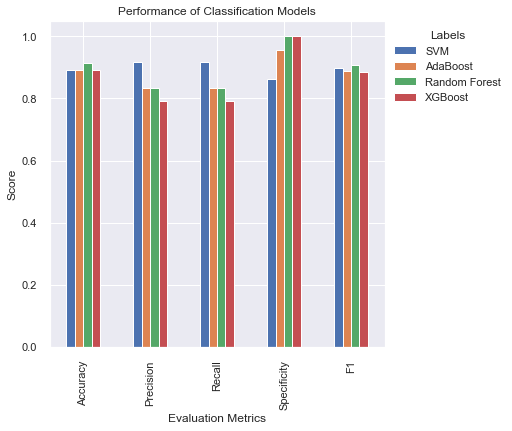

In [128]:
trainModels(X_train_EN, y_train_b, X_test_EN, y_test)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

Accuracy Mean  Precision Mean  Recall Mean  Specificity Mean  \
SVM                 0.856061        0.836310     0.917500          0.723810   
AdaBoost            0.915152        0.904603     0.905000          0.807937   
Random Forest       0.924242        0.899722     0.950833          0.796825   
XGBoost             0.932576        0.909722     0.937500          0.807937   

                F1 Mean  
SVM            0.858150  
AdaBoost       0.902602  
Random Forest  0.918436  
XGBoost        0.921012

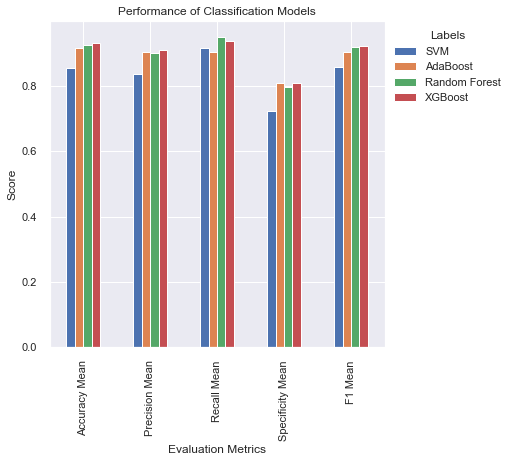

In [397]:
trainModelsCV(X_train_EN, y_train_b)

#### Intersection of Features

In [101]:
# save df as csv
X_train_EN.to_csv('X_train_EN.csv')
X_test_EN.to_csv('X_test_EN.csv')
X_train_Lasso.to_csv('X_train_Lasso.csv')
X_test_Lasso.to_csv('X_test_Lasso.csv')
X_train_rf.to_csv('X_train_rf.csv')
X_test_rf.to_csv('X_test_rf.csv')
X_train_mRMR.to_csv('X_train_mRMR.csv')
X_test_mRMR.to_csv('X_test_mRMR.csv')
X_train_skb.to_csv('X_train_skb.csv')
X_test_skb.to_csv('X_test_skb.csv')

In [66]:
#convert the columns to list
EN = X_train_EN.columns
Lasso = X_train_Lasso.columns
rf = X_train_rf.columns
mrmr = X_train_mRMR.columns
skb = X_train_skb.columns

In [92]:
print('EN :', EN)
print('Lasso :', Lasso)
print('RF :', rf)
print('mRMR :', mrmr)
print('skb :', skb)

EN : Index(['Bacteroides_uniformis|t__SGB1836_group',
       'Faecalibacterium_prausnitzii', 'Phocaeicola_vulgatus|t__SGB1814',
       '_Cutibacterium_acnes|t__SGB16955', 'crispatus|t__SGB7045', 'mitis',
       'unclassified', 'uniformis|t__SGB1836_group'],
      dtype='object')
Lasso : Index(['Bilophila_wadsworthia|t__SGB15452', 'Faecalibacterium_prausnitzii',
       'Lachnospiraceae_bacterium', 'Parabacteroides_distasonis|t__SGB1934'],
      dtype='object')
RF : Index(['Agathobaculum_butyriciproducens|t__SGB14993_group',
       'Bacteroides_ovatus|t__SGB1871',
       'Bacteroides_uniformis|t__SGB1836_group', 'Blautia_faecis',
       'Blautia_massiliensis', 'Blautia_obeum|t__SGB4811_group',
       'Blautia_wexlerae', 'Clostridiaceae_bacterium|t__SGB4269',
       'Clostridium_fessum|t__SGB4705', 'Coprococcus_catus',
       'Dorea_longicatena', 'Enterocloster_bolteae|t__SGB4758_group',
       'Escherichia_coli|t__SGB10068', 'GGB9581_SGB14999|t__SGB14999',
       'Parabacteroides_merdae|

In [70]:
# common elements for all
feat = list(set(EN). intersection(Lasso, rf, mrmr, skb))
print('All :' , feat)

[]


In [90]:
# EN with three methods 

# without skb
feat = list(set(EN). intersection(Lasso, rf, mrmr))
print('EN without SKB :' , feat)

# without mrmr
feat = list(set(EN). intersection(Lasso, rf, skb))
print('EN without mrmr :' , feat)

# without rf
feat = list(set(EN). intersection(Lasso, mrmr, skb))
print('EN without rf :' , feat)

# without Lasso
feat = list(set(EN). intersection(rf, mrmr, skb))
print('EN without lasso :' , feat)

###################################################
# SKB with three methods 
print('\n')

# without en
feat = list(set(skb). intersection(Lasso, rf, mrmr))
print('SKB without EN :' , feat)

# without mrmr
feat = list(set(skb). intersection(Lasso, rf, EN))
print('SKB without mrmr :' , feat)

# without rf
feat = list(set(skb). intersection(Lasso, mrmr, EN))
print('SKB without rf :' , feat)

# without Lasso
feat = list(set(skb). intersection(rf, mrmr, EN))
print('SKB without lasso :' , feat)

###################################################
# MRMR with three methods 
print('\n')

# without en
feat = list(set(skb). intersection(Lasso, rf, mrmr))
print('MRMRwithout EN :' , feat)

# without skb
feat = list(set(mrmr). intersection(Lasso, rf, EN))
print('MRMR without SKB :' , feat)

# without rf
feat = list(set(skb). intersection(Lasso, mrmr, EN))
print('MRMR without rf :' , feat)

# without Lasso
feat = list(set(skb). intersection(rf, mrmr, EN))
print('MRMR without lasso :' , feat)

###################################################
# RF with three methods 
print('\n')

# without en
feat = list(set(skb). intersection(Lasso, rf, mrmr))
print('RF without EN :' , feat)

# without skb
feat = list(set(mrmr). intersection(Lasso, rf, EN))
print('RF without SKB :' , feat)

# without mrmr
feat = list(set(skb). intersection(Lasso, rf, EN))
print('RF without MRMR :' , feat)

# without Lasso
feat = list(set(skb). intersection(rf, mrmr, EN))
print('RF without lasso :' , feat)

###################################################
# Lasso with three methods 
print('\n')

# without en
feat = list(set(skb). intersection(Lasso, rf, mrmr))
print('Lasso without EN :' , feat)

# without skb
feat = list(set(mrmr). intersection(Lasso, rf, EN))
print('Lasso without SKB :' , feat)

# without mrmr
feat = list(set(skb). intersection(Lasso, rf, EN))
print('Lasso without MRMR :' , feat)

# without rf
feat = list(set(skb). intersection(Lasso, mrmr, EN))
print('Lasso without lasso :' , feat)



EN without SKB : []
EN without mrmr : []
EN without rf : ['Faecalibacterium_prausnitzii']
EN without lasso : []


SKB without EN : []
SKB without mrmr : []
SKB without rf : ['Faecalibacterium_prausnitzii']
SKB without lasso : []


MRMRwithout EN : []
MRMR without SKB : []
MRMR without rf : ['Faecalibacterium_prausnitzii']
MRMR without lasso : []


RF without EN : []
RF without SKB : []
RF without MRMR : []
RF without lasso : []


Lasso without EN : []
Lasso without SKB : []
Lasso without MRMR : []
Lasso without lasso : ['Faecalibacterium_prausnitzii']


In [97]:
# EN with two methods 

# EN with Lasso, skb
feat = list(set(EN).intersection(Lasso,skb))
print('EN with Lasso | SKB :' , feat)

# EN with Lasso, mRMR
feat = list(set(EN).intersection(Lasso, mrmr))
print('EN with Lasso | mRMR :' , feat)

# EN with Lasso, RF
feat = list(set(EN).intersection(Lasso, rf))
print('EN with Lasso | rf :' , feat)

# EN with skb, RF
feat = list(set(EN).intersection(rf))
print('EN with SKB | rf :' , feat)

# EN with skb, mrmr
feat = list(set(EN).intersection(rf))
print('EN with SKB | mrmr :' , feat)

# EN with mrm, rf
feat = list(set(EN).intersection(rf))
print('EN with rf | mrmr :' , feat)

###################################################
# rf with two methods

# rf with Lasso, skb
feat = list(set(rf).intersection(Lasso,skb))
print('RF with Lasso | SKB :' , feat)

# rf with Lasso, mRMR
feat = list(set(rf).intersection(Lasso, mrmr))
print('RF with Lasso | mRMR :' , feat)

# EN with skb, mrmr
feat = list(set(rf).intersection(rf))
print('RF with SKB | mrmr :' , feat)

###################################################
# skb with two methods

# skb with Lasso, mRMR
feat = list(set(skb).intersection(Lasso, mrmr))
print('SKB with Lasso | mRMR :' , feat)


EN with Lasso | SKB : ['Faecalibacterium_prausnitzii']
EN with Lasso | mRMR : ['Faecalibacterium_prausnitzii']
EN with Lasso | rf : []
EN with SKB | rf : ['Bacteroides_uniformis|t__SGB1836_group']
EN with SKB | mrmr : ['Bacteroides_uniformis|t__SGB1836_group']
EN with rf | mrmr : ['Bacteroides_uniformis|t__SGB1836_group']
RF with Lasso | SKB : []
RF with Lasso | mRMR : []
RF with SKB | mrmr : ['Blautia_wexlerae', 'Bacteroides_uniformis|t__SGB1836_group', 'Coprococcus_catus', 'Blautia_obeum|t__SGB4811_group', 'Escherichia_coli|t__SGB10068', 'Blautia_faecis', 'GGB9581_SGB14999|t__SGB14999', 'Dorea_longicatena', 'Agathobaculum_butyriciproducens|t__SGB14993_group', 'Enterocloster_bolteae|t__SGB4758_group', 'Blautia_massiliensis', 'Clostridium_fessum|t__SGB4705', 'Bacteroides_ovatus|t__SGB1871', 'Clostridiaceae_bacterium|t__SGB4269', 'Parabacteroides_merdae|t__SGB1949']
SKB with Lasso | mRMR : ['Faecalibacterium_prausnitzii']


In [96]:
# EN with one method

# EN with Lasso
feat = list(set(EN).intersection(Lasso))
print('EN with Lasso :' , feat)

# EN with skb
feat = list(set(EN).intersection(skb))
print('EN with skb :' , feat)

# EN with mrmr
feat = list(set(EN).intersection(mrmr))
print('EN with mRMR :' , feat)

# EN with rf
feat = list(set(EN).intersection(rf))
print('EN with rf :' , feat)

###################################################
# rf with one method
print('\n')

# rf with Lasso
feat = list(set(rf).intersection(Lasso))
print('RF with Lasso :' , feat)

# rf with skb
feat = list(set(rf).intersection(skb))
print('RF with skb :' , feat)

# rf with mrmr
feat = list(set(rf).intersection(mrmr))
print('RF with mRMR :' , feat)

###################################################
# MRMR with one method
print('\n')

# mrmr with Lasso
feat = list(set(mrmr).intersection(Lasso))
print('mRMR with Lasso :' , feat)

# mrmr with skb
feat = list(set(mrmr).intersection(skb))
print('mRMR with skb :' , feat)

###################################################
# skb with one method
print('\n')

# skb with Lasso
feat = list(set(skb).intersection(Lasso))
print('SKB with Lasso :' , feat)


EN with Lasso : ['Faecalibacterium_prausnitzii']
EN with skb : ['Faecalibacterium_prausnitzii', 'Phocaeicola_vulgatus|t__SGB1814', 'uniformis|t__SGB1836_group', '_Cutibacterium_acnes|t__SGB16955']
EN with mRMR : ['Faecalibacterium_prausnitzii', 'unclassified']
EN with rf : ['Bacteroides_uniformis|t__SGB1836_group']


RF with Lasso : []
RF with skb : []
RF with mRMR : ['Clostridium_fessum|t__SGB4705']


mRMR with Lasso : ['Faecalibacterium_prausnitzii', 'Parabacteroides_distasonis|t__SGB1934', 'Lachnospiraceae_bacterium', 'Bilophila_wadsworthia|t__SGB15452']
mRMR with skb : ['Faecalibacterium_prausnitzii']


SKB with Lasso : ['Faecalibacterium_prausnitzii']


### Unsupervised Learning

In [130]:
### function to get cols names to list
unionList = []
def getColNames(df):
    cols = df.columns.values.tolist()
    for i in range(len(cols)) :
        unionList.append(cols[i])

getColNames(X_train_EN)
getColNames(X_train_Lasso)
getColNames(X_train_rf)
getColNames(X_train_mRMR)
getColNames(X_train_skb)
print('Total Number of Features :', len(unionList))
print(unionList)

Total Number of Features : 54


In [167]:
singleList = []

def getColNames(df):
    del singleList[:]
    cols = df.columns.values.tolist()
    for i in range(len(cols)) :
        singleList.append(cols[i])

In [131]:
# drop cols taht are not in the list 
def dropCol(list) :
    df_diabetes = pd.read_csv(r'D:\FYP\df_T2D.csv')
    df_healthy = pd.read_csv(r'D:\FYP\df_H.csv')
    df_d = df_diabetes.drop(columns=[col for col in df_diabetes if col not in list])
    df_h = df_healthy.drop(columns=[col for col in df_healthy if col not in list])
    print('Diabetes df shape :', df_d.shape)
    print('Healthy df shape :', df_h.shape)
    return df_d,df_h

#### K-Means Function
https://www.kaggle.com/code/shrutimechlearn/step-by-step-kmeans-explained-in-detail 

visualizer --> https://www.kaggle.com/code/residentmario/ml-visualization-with-yellowbrick-3
https://towardsdatascience.com/silhouette-method-better-than-elbow-method-to-find-optimal-clusters-378d62ff6891

In [133]:
# elbow plot
def elbowAndSilhouette(df):
    wcss = []
    silhouette = []
    cluster_range = [2,3,4,5,6,7,8,9]
    #fig, ax = plt.subplots(2, 2, figsize=(15,8))
    for i in cluster_range:
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        cluster_labels = kmeans.labels_
        silhouette.append(silhouette_score(df, cluster_labels))
        #print('For cluster {0}, silhouette score is {1}'.format(i,silhouette))

        #plot silhouette visualizer
        visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
        visualizer.fit(df)
        visualizer.poof()

    # plot elbow graph
    plt.figure(figsize=(6,6))
    sns.lineplot(range(2,10), wcss, marker='o', color='red')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.show()

    # plot silhouette graph
    plt.plot(cluster_range, silhouette,'bx-')
    plt.title('Silhouette Analysis')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.show()


# FUNCTION to sum the features for each cluster
# df_d, y_kmeans, total number of clusters
def stackedBar(df, y_kmeans, n):
    df_d_cluster = df.copy()
    sum_cols = pd.DataFrame(index=df_d_cluster.columns)
    df_d_cluster['Cluster'] = y_kmeans
    
    for i in range(n):
        df_cluster = df_d_cluster[df_d_cluster['Cluster'] == i].copy()
        df_cluster.drop(['Cluster'], axis=1)
        sum_cols[str(i)] = df_cluster.sum(axis=0) 
    sum_cols_t = sum_cols.transpose()
    sum_cols_t['Cluster'] = sum_cols_t.index

    dict = {}
    for i in range(n):
        dict['df_{0}'.format(i)] = sum_cols.nlargest(5, str(i)) 

    # plot stacked graph

    plt.rcParams["figure.figsize"] = (15,10)
    sum_cols_t.plot.bar(x='Cluster',stacked=True,rot=15, title="Species in the Clusters")
    plt.legend(bbox_to_anchor=(1.0, 1.0), title='Species')
    plt.show(block=True)
    return dict


#### Hierarchical Clustering Function

https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/

In [132]:
def hierarchicalFirst(df):
    df_scaled_d = normalize(df)
    df_scaled_d = pd.DataFrame(df_scaled_d, columns=df.columns)

    # plot dendogram
    plt.figure(1, figsize = (16 ,8))
    dendrogram = sch.dendrogram(sch.linkage(df_scaled_d, method  = "ward"))
    plt.title('Dendrogram')
    plt.xlabel('Species')
    plt.ylabel('Euclidean distances')
    plt.show()
    return df_scaled_d

def hierarchicalSecond(df,y):
    # plot dendogram with threshold
    plt.figure(1, figsize = (16 ,8))
    dendrogram = sch.dendrogram(sch.linkage(df, method  = "ward"))
    plt.title('Dendrogram')
    plt.xlabel('Species')
    plt.ylabel('Euclidean distances')
    plt.axhline(y=y, color='r', linestyle='--') # to show the threshold, can be removed
    plt.show()

def agglomerative(df, n):
    cluster = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
    predict = cluster.fit_predict(df)
    labels = cluster.labels_
    return predict, labels

#### Union

##### Diabetes

In [134]:
df_d,df_h = dropCol(unionList)

Diabetes df shape : (70, 31)
Healthy df shape : (82, 41)


Kmeans

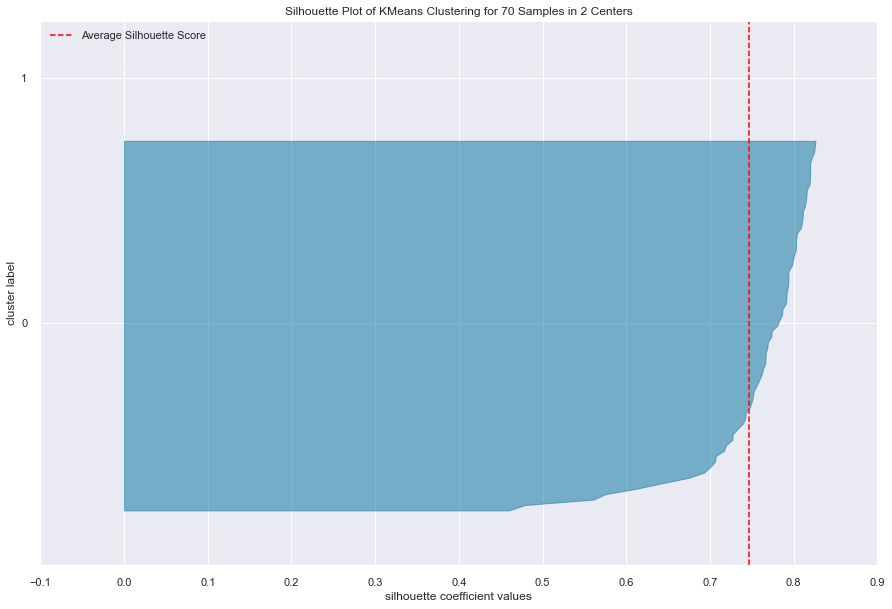

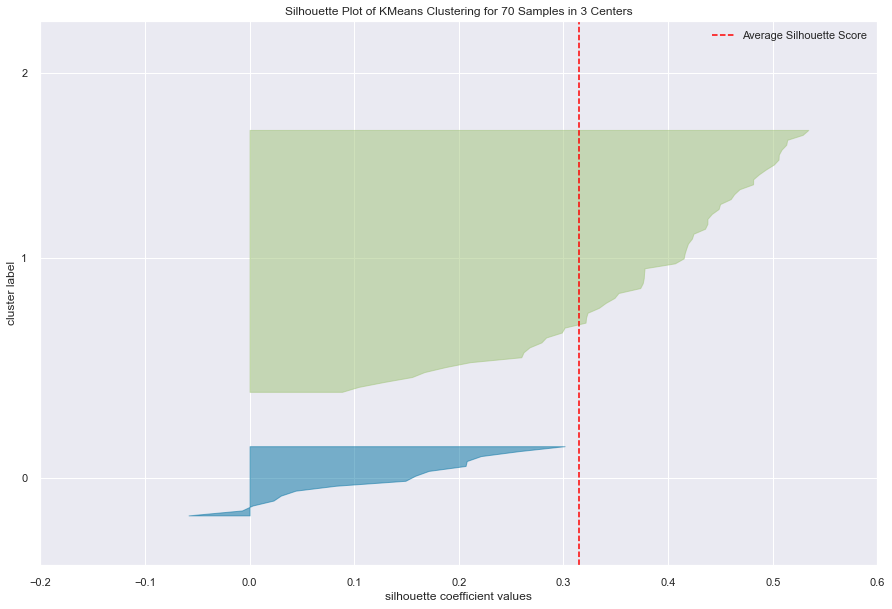

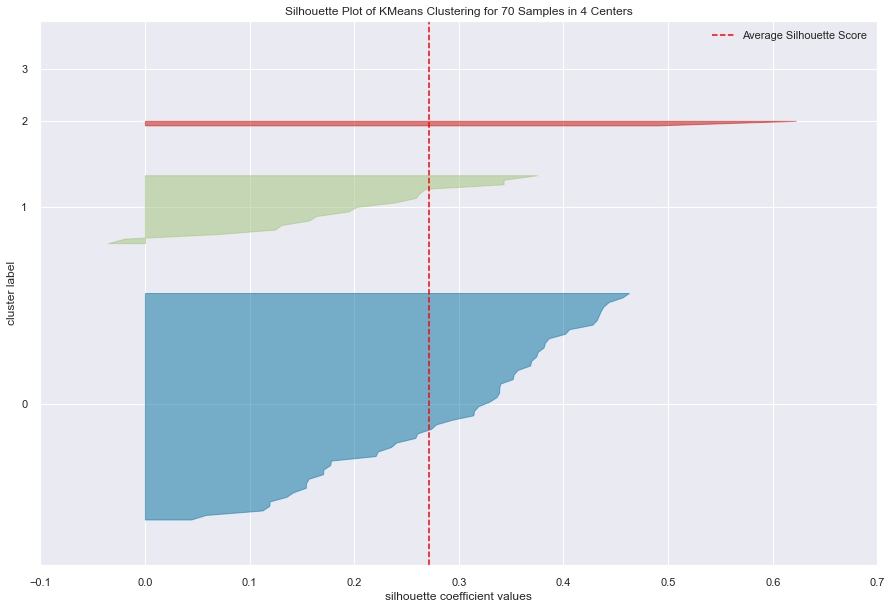

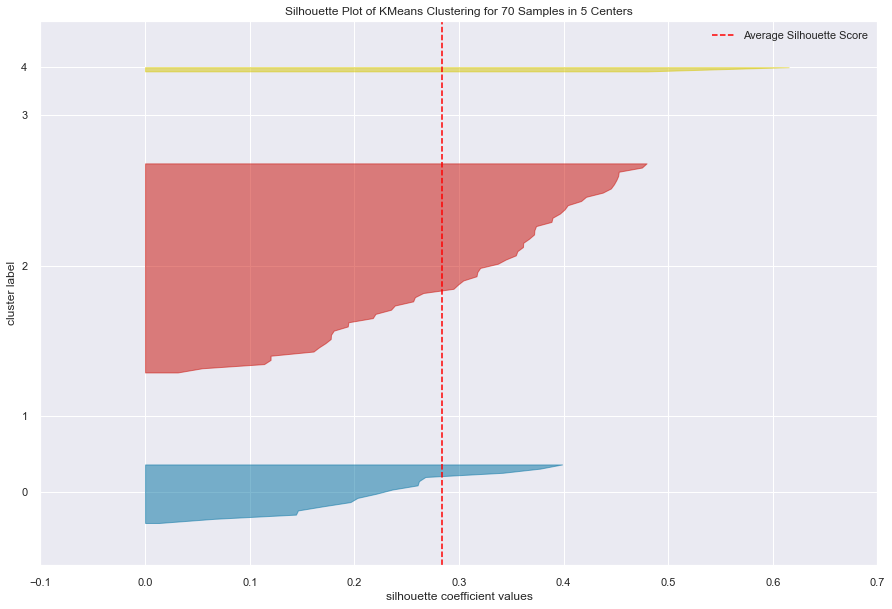

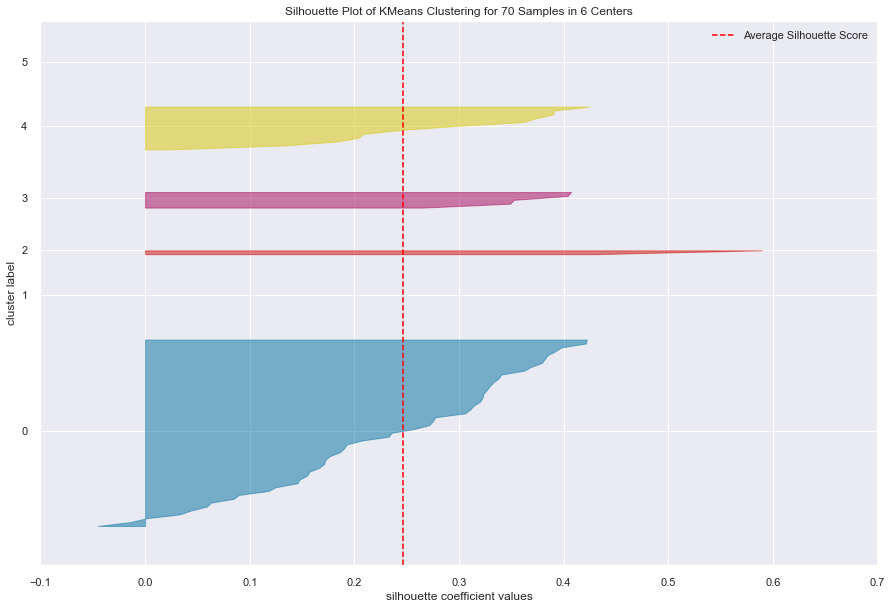

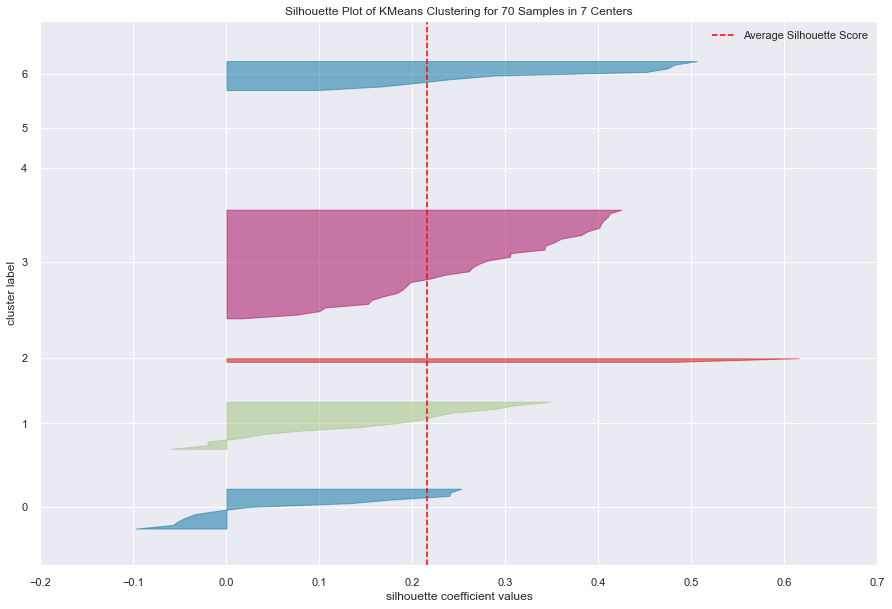

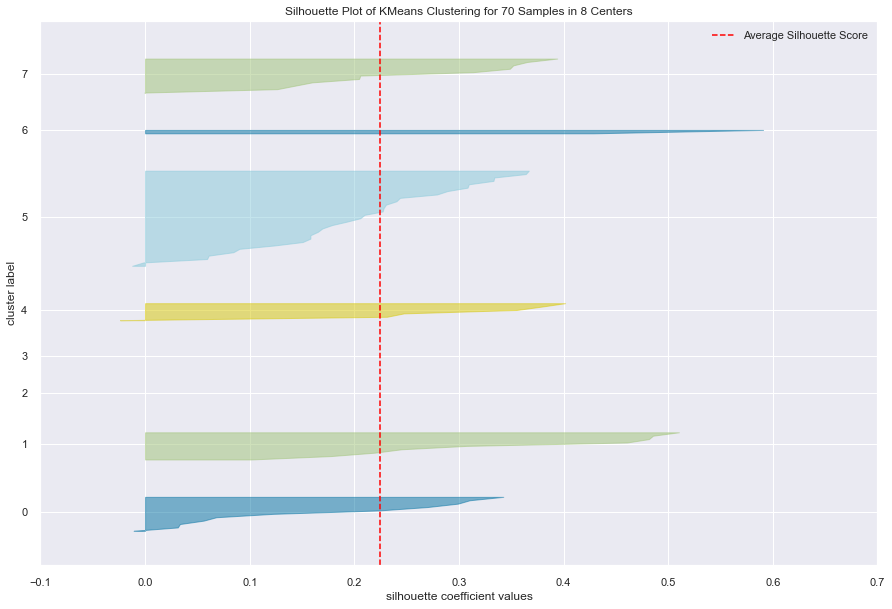

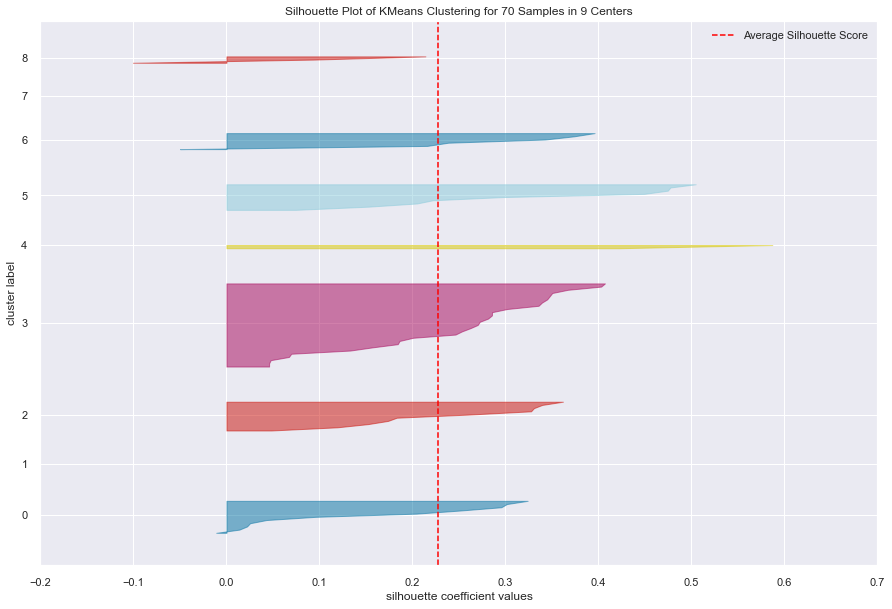

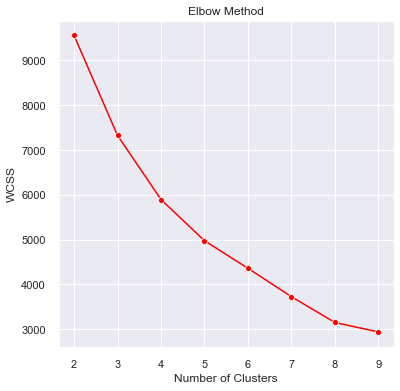

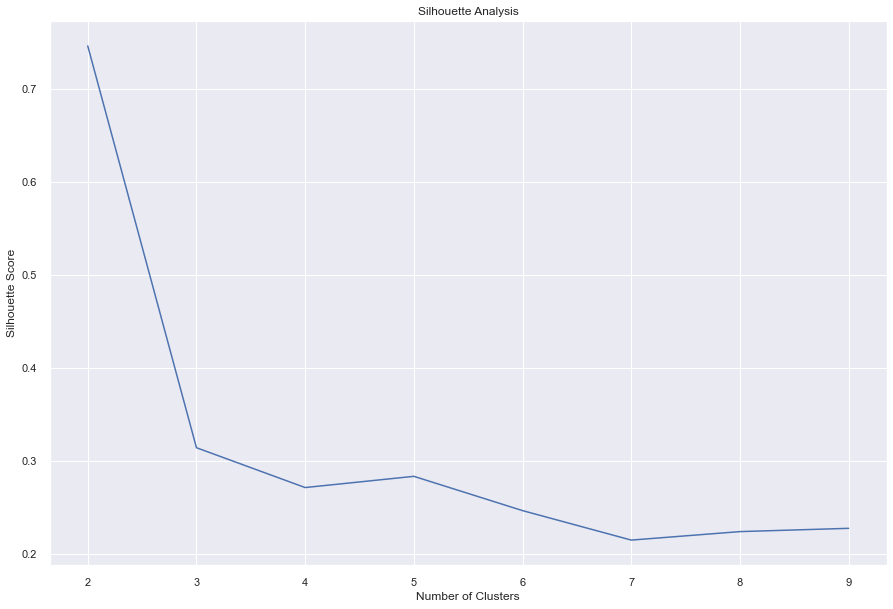

In [135]:
# for diabetes df
elbowAndSilhouette(df_d)

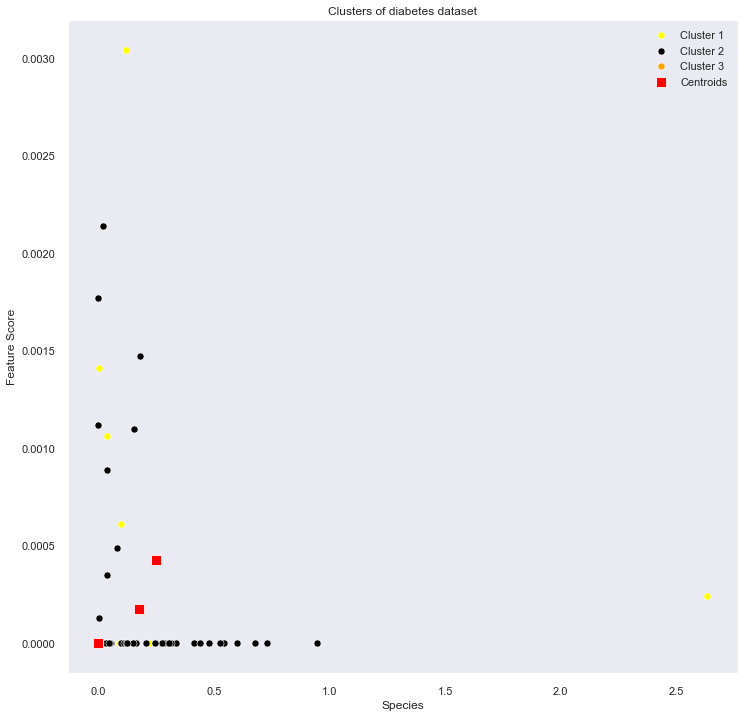

In [138]:
# applying k means = 3
X = df_d.to_numpy() # have to convert to numpy to plot graph
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X)

plt.figure(figsize=(12,12))
sns.scatterplot(X[y_kmeans == 0,0], X[y_kmeans == 0,1], color = 'yellow', label ='Cluster 1', s=50)
sns.scatterplot(X[y_kmeans == 1,0], X[y_kmeans == 1,1], color = 'black', label ='Cluster 2', s=50)
sns.scatterplot(X[y_kmeans == 2,0], X[y_kmeans == 2,1], color = 'orange', label ='Cluster 3', s=50)
#sns.scatterplot(X[y_kmeans == 3,0], X[y_kmeans == 3,1], color = 'blue', label ='Cluster 4', s=50)
#sns.scatterplot(X[y_kmeans == 4,0], X[y_kmeans == 4,1], color = 'green', label ='Cluster 5', s=50)
#sns.scatterplot(X[y_kmeans == 5,0], X[y_kmeans == 5,1], color = 'grey', label ='Cluster 6', s=50)
sns.scatterplot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], color ='red', label='Centroids', s=100, marker=',')
plt.grid(False)
plt.title('Clusters of diabetes dataset')
plt.xlabel('Species')
plt.ylabel('Feature Score')
plt.legend()
plt.show()

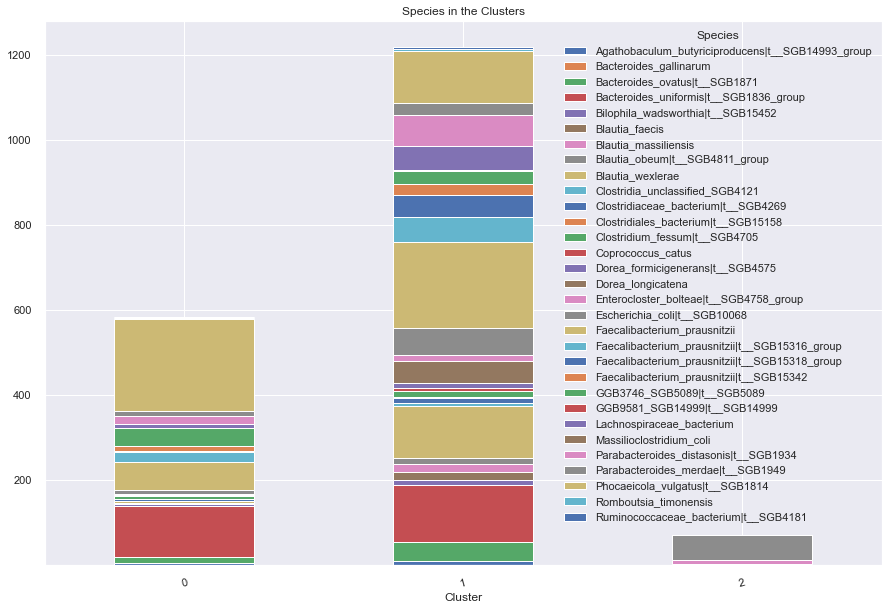

In [139]:
dict_cluster = stackedBar(df_d, y_kmeans, 3)

In [140]:
# species of cluster 1
print('Cluster 0 : ')
display(dict_cluster['df_0'])
print('Cluster 1 : ')
display(dict_cluster['df_1'])
print('Cluster 2 : ')
display(dict_cluster['df_2'])


Cluster 0 : 


0          1        2
Phocaeicola_vulgatus|t__SGB1814                 216.64275  123.69293  0.32949
Bacteroides_uniformis|t__SGB1836_group          120.39536  133.78625  0.01840
Faecalibacterium_prausnitzii                     66.20202  204.15321  0.00000
GGB3746_SGB5089|t__SGB5089                       41.80632   29.92763  0.00000
Faecalibacterium_prausnitzii|t__SGB15316_group   23.39889   58.20978  0.00000

Cluster 1 : 


0          1        2
Faecalibacterium_prausnitzii             66.20202  204.15321  0.00000
Bacteroides_uniformis|t__SGB1836_group  120.39536  133.78625  0.01840
Phocaeicola_vulgatus|t__SGB1814         216.64275  123.69293  0.32949
Blautia_wexlerae                          4.10928  122.77588  0.00000
Parabacteroides_distasonis|t__SGB1934    18.17882   72.27765  0.04813

Cluster 2 : 


0          1         2
Escherichia_coli|t__SGB10068              8.80949   62.50655  59.21869
Enterocloster_bolteae|t__SGB4758_group    1.20972   14.78130  10.02534
Phocaeicola_vulgatus|t__SGB1814         216.64275  123.69293   0.32949
Clostridia_unclassified_SGB4121           0.73142    5.30643   0.17028
Parabacteroides_distasonis|t__SGB1934    18.17882   72.27765   0.04813

Hierarchical Clustering

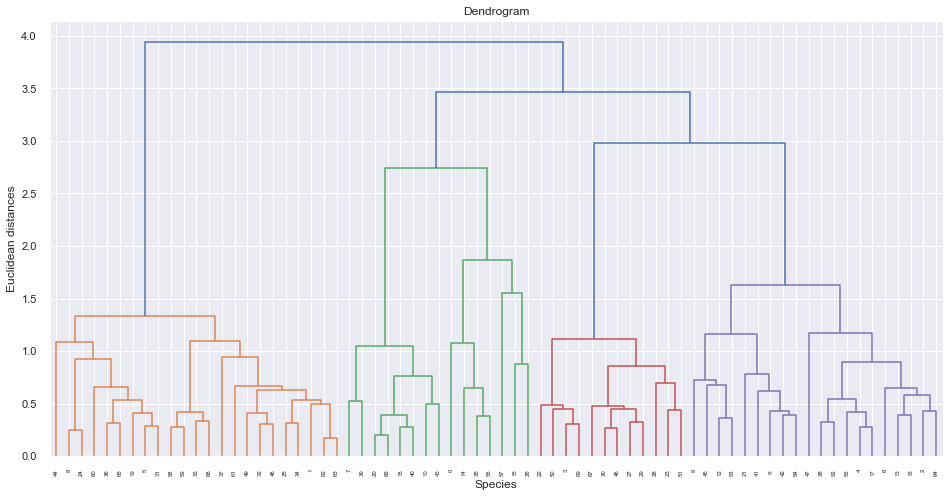

In [141]:
df_scaled_d = hierarchicalFirst(df_d)

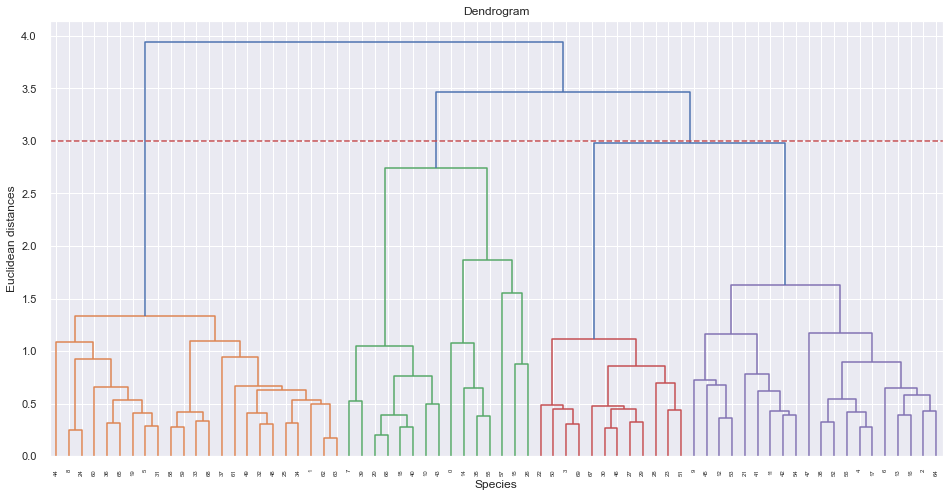

In [142]:
hierarchicalSecond(df_scaled_d,3.0)

In [143]:
y_hc, labels = agglomerative(df_scaled_d, 4)
y_hc

array([0, 1, 2, 3, 2, 1, 2, 0, 1, 2, 0, 2, 2, 2, 0, 0, 2, 2, 0, 1, 0, 2,
       3, 3, 1, 1, 0, 3, 3, 3, 3, 1, 1, 1, 1, 0, 1, 1, 2, 0, 0, 2, 2, 0,
       1, 2, 3, 2, 1, 1, 3, 3, 2, 2, 2, 0, 2, 0, 1, 1, 1, 1, 1, 1, 2, 1,
       0, 3, 1, 3], dtype=int64)

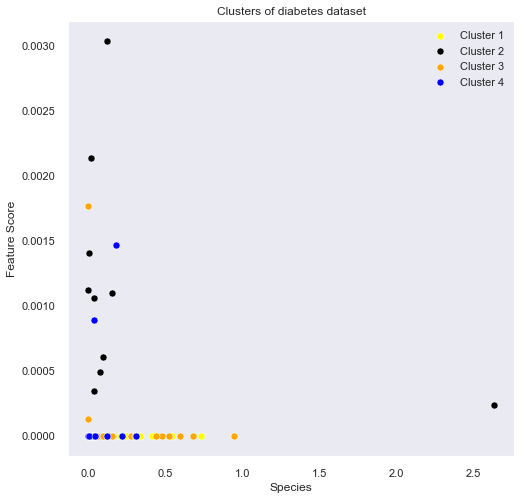

In [144]:
# agglomerative clustering = 4
X = df_d.to_numpy() # have to convert to numpy to plot graph

plt.figure(figsize=(8,8))
sns.scatterplot(X[y_hc == 0,0], X[y_hc == 0,1], color = 'yellow', label ='Cluster 1', s=50)
sns.scatterplot(X[y_hc == 1,0], X[y_hc == 1,1], color = 'black', label ='Cluster 2', s=50)
sns.scatterplot(X[y_hc == 2,0], X[y_hc == 2,1], color = 'orange', label ='Cluster 3', s=50)
sns.scatterplot(X[y_hc == 3,0], X[y_hc == 3,1], color = 'blue', label ='Cluster 4', s=50)
#sns.scatterplot(X[y_kmeans == 4,0], X[y_kmeans == 4,1], color = 'green', label ='Cluster 5', s=50)
#sns.scatterplot(X[y_kmeans == 5,0], X[y_kmeans == 5,1], color = 'grey', label ='Cluster 6', s=50)
#sns.scatterplot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], color ='red', label='Centroids', s=100, marker=',')
plt.grid(False)
plt.title('Clusters of diabetes dataset')
plt.xlabel('Species')
plt.ylabel('Feature Score')
plt.legend()
plt.show()

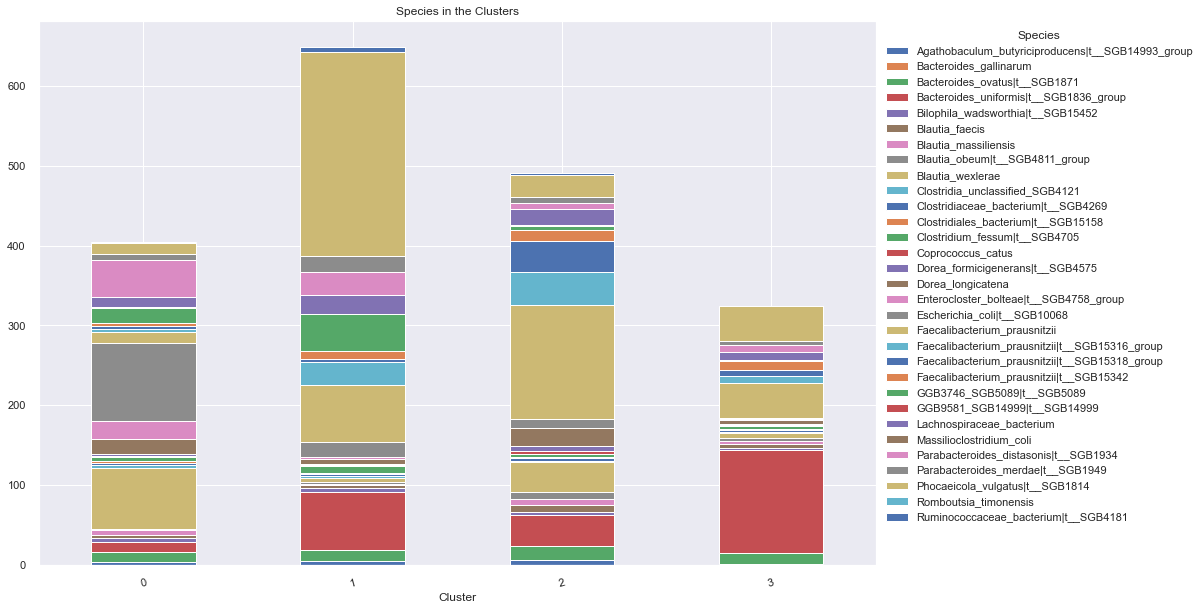

In [145]:
dict_cluster = stackedBar(df_d, y_hc, 4)

In [146]:
# species of cluster 1
print('Cluster 0 : ')
display(dict_cluster['df_0'])
print('Cluster 1 : ')
display(dict_cluster['df_1'])
print('Cluster 2 : ')
display(dict_cluster['df_2'])
print('Cluster 3 : ')
display(dict_cluster['df_3'])

Cluster 0 : 


0         1         2        3
Escherichia_coli|t__SGB10068            97.96874  19.35743  11.50154  1.70702
Blautia_wexlerae                        76.79297   6.07496  37.27825  6.73898
Parabacteroides_distasonis|t__SGB1934   46.68958  28.79254   7.21550  7.80698
Enterocloster_bolteae|t__SGB4758_group  22.13229   2.53708   0.54670  0.80029
Dorea_longicatena                       19.26936   6.03708  22.48236  5.45924

Cluster 1 : 


0          1          2  \
Phocaeicola_vulgatus|t__SGB1814         14.59761  255.97525   27.09931   
Bacteroides_uniformis|t__SGB1836_group  12.25983   72.57967   39.26030   
Faecalibacterium_prausnitzii            13.46926   70.69456  142.65247   
GGB3746_SGB5089|t__SGB5089              18.54302   46.94534    4.97242   
Parabacteroides_distasonis|t__SGB1934   46.68958   28.79254    7.21550   

                                                3  
Phocaeicola_vulgatus|t__SGB1814          42.99300  
Bacteroides_uniformis|t__SGB1836_group  130.10021  
Faecalibacterium_prausnitzii             43.53894  
GGB3746_SGB5089|t__SGB5089                1.27317  
Parabacteroides_distasonis|t__SGB1934     7.80698

Cluster 2 : 


0         1          2  \
Faecalibacterium_prausnitzii                    13.46926  70.69456  142.65247   
Faecalibacterium_prausnitzii|t__SGB15316_group   3.40621  28.77669   41.33720   
Bacteroides_uniformis|t__SGB1836_group          12.25983  72.57967   39.26030   
Faecalibacterium_prausnitzii|t__SGB15318_group   4.14624   3.81625   38.71210   
Blautia_wexlerae                                76.79297   6.07496   37.27825   

                                                        3  
Faecalibacterium_prausnitzii                     43.53894  
Faecalibacterium_prausnitzii|t__SGB15316_group    8.08857  
Bacteroides_uniformis|t__SGB1836_group          130.10021  
Faecalibacterium_prausnitzii|t__SGB15318_group    7.53086  
Blautia_wexlerae                                  6.73898

Cluster 3 : 


0          1          2  \
Bacteroides_uniformis|t__SGB1836_group    12.25983   72.57967   39.26030   
Faecalibacterium_prausnitzii              13.46926   70.69456  142.65247   
Phocaeicola_vulgatus|t__SGB1814           14.59761  255.97525   27.09931   
Bacteroides_ovatus|t__SGB1871             12.73583   14.78296   17.59813   
Faecalibacterium_prausnitzii|t__SGB15342   4.38060    9.77541   14.35186   

                                                  3  
Bacteroides_uniformis|t__SGB1836_group    130.10021  
Faecalibacterium_prausnitzii               43.53894  
Phocaeicola_vulgatus|t__SGB1814            42.99300  
Bacteroides_ovatus|t__SGB1871              13.03046  
Faecalibacterium_prausnitzii|t__SGB15342   11.71095

##### Healthy

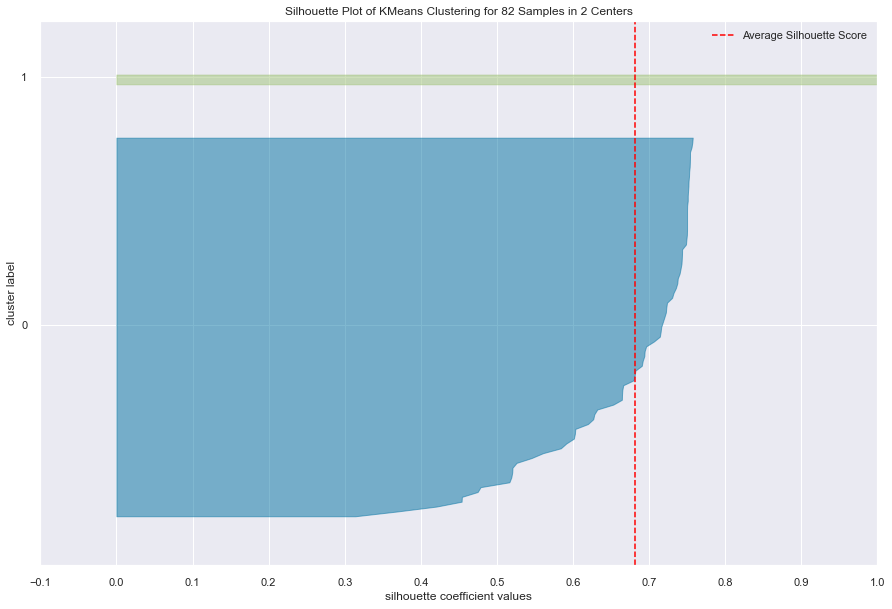

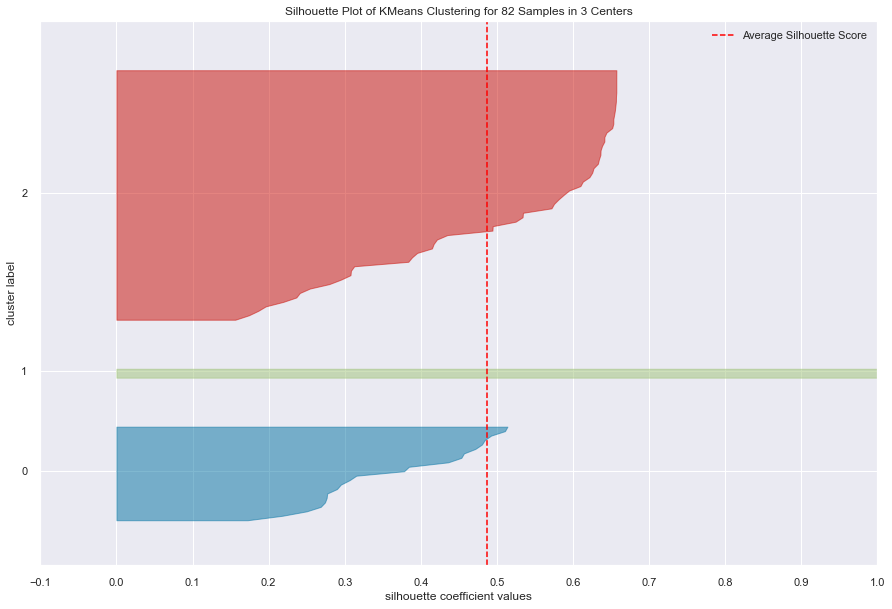

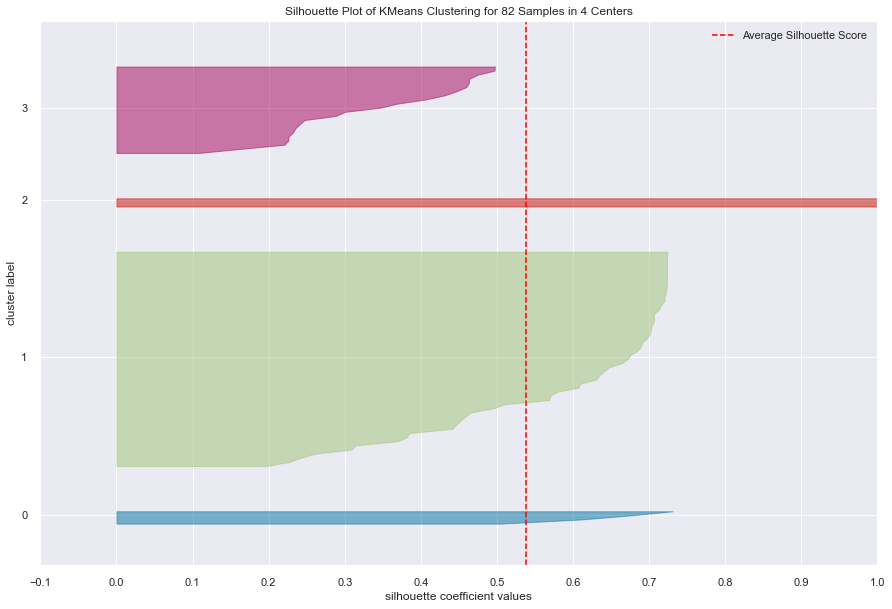

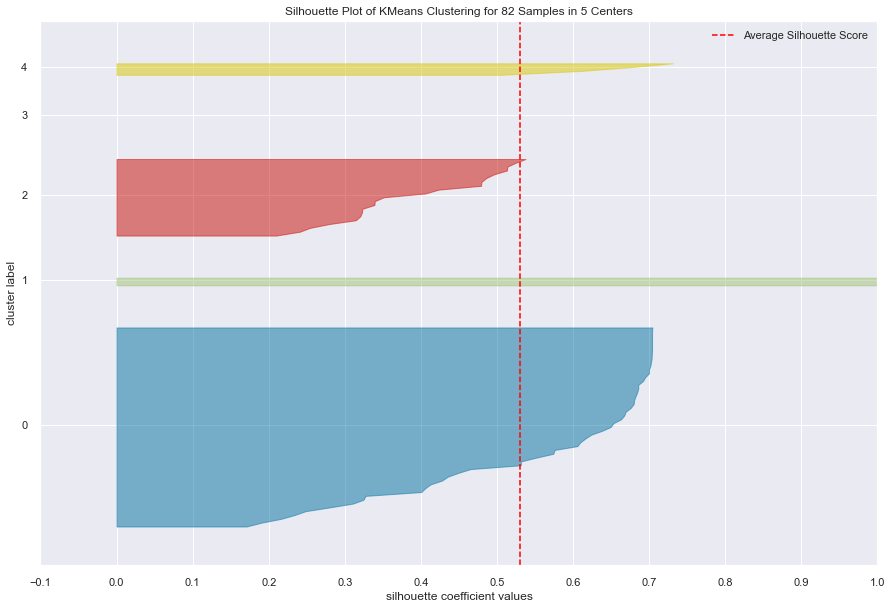

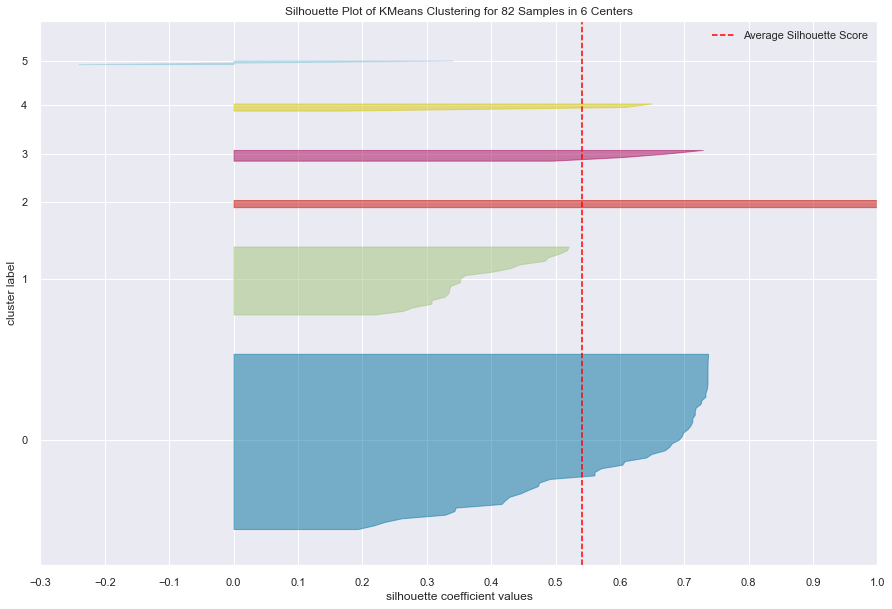

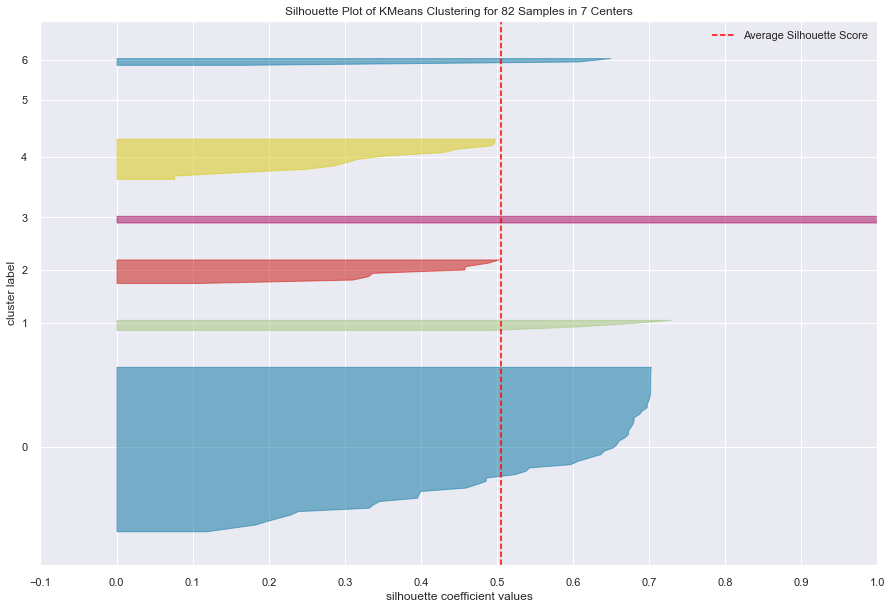

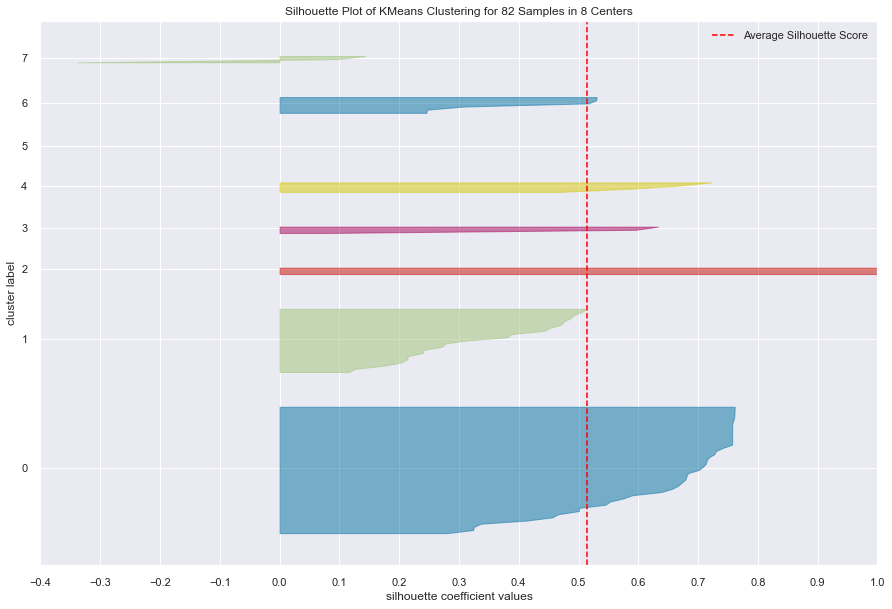

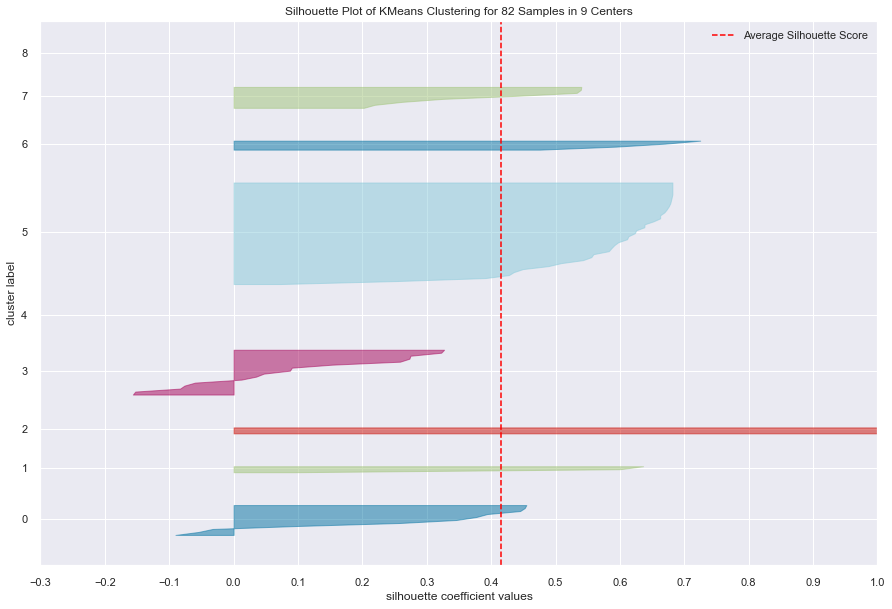

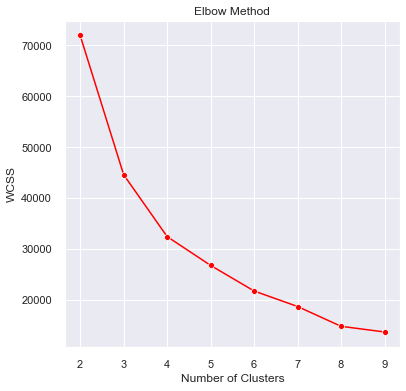

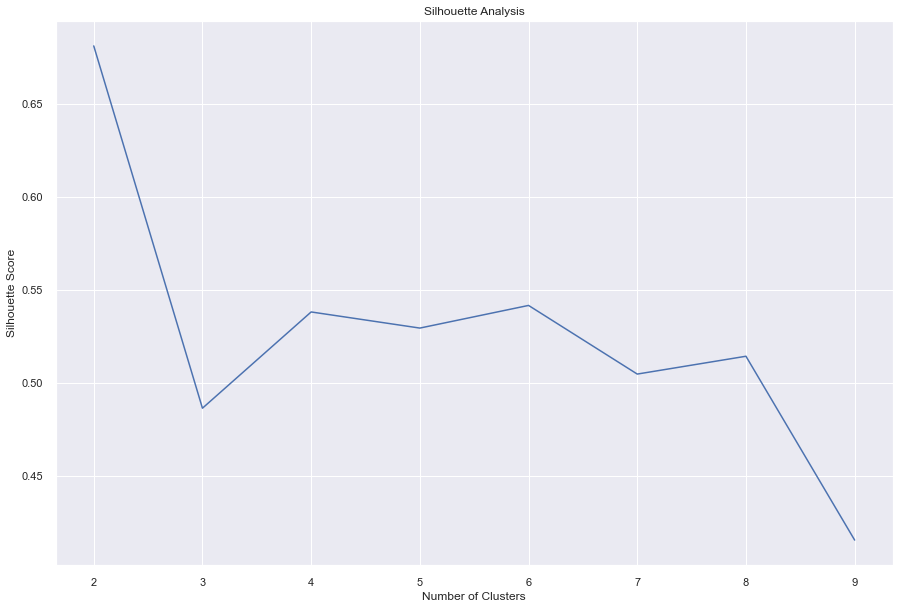

In [147]:
elbowAndSilhouette(df_h)

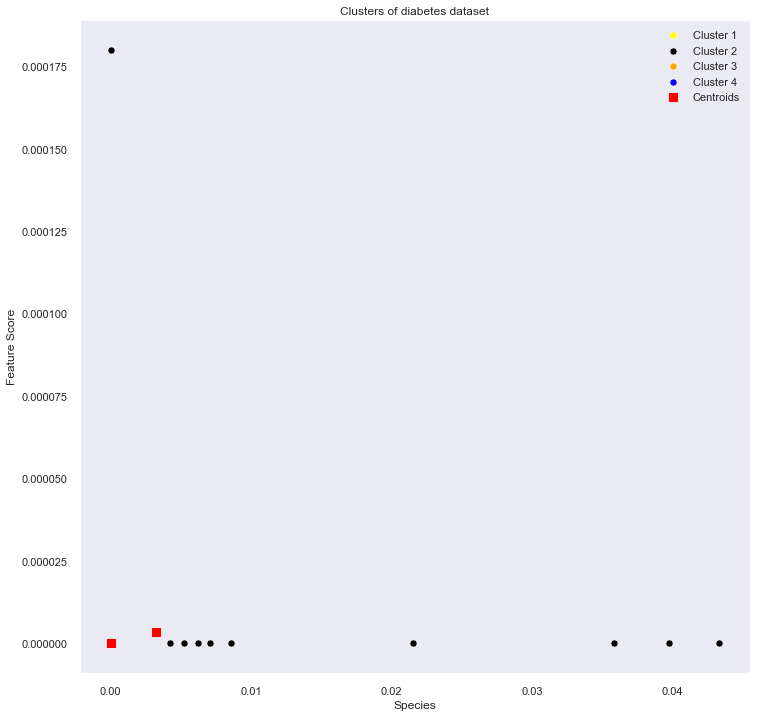

In [149]:
# applying k means = 4
X = df_h.to_numpy() # have to convert to numpy to plot graph
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X)

plt.figure(figsize=(12,12))
sns.scatterplot(X[y_kmeans == 0,0], X[y_kmeans == 0,1], color = 'yellow', label ='Cluster 1', s=50)
sns.scatterplot(X[y_kmeans == 1,0], X[y_kmeans == 1,1], color = 'black', label ='Cluster 2', s=50)
sns.scatterplot(X[y_kmeans == 2,0], X[y_kmeans == 2,1], color = 'orange', label ='Cluster 3', s=50)
sns.scatterplot(X[y_kmeans == 3,0], X[y_kmeans == 3,1], color = 'blue', label ='Cluster 4', s=50)
#sns.scatterplot(X[y_kmeans == 4,0], X[y_kmeans == 4,1], color = 'green', label ='Cluster 5', s=50)
#sns.scatterplot(X[y_kmeans == 5,0], X[y_kmeans == 5,1], color = 'grey', label ='Cluster 6', s=50)
sns.scatterplot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], color ='red', label='Centroids', s=100, marker=',')
plt.grid(False)
plt.title('Clusters of diabetes dataset')
plt.xlabel('Species')
plt.ylabel('Feature Score')
plt.legend()
plt.show()

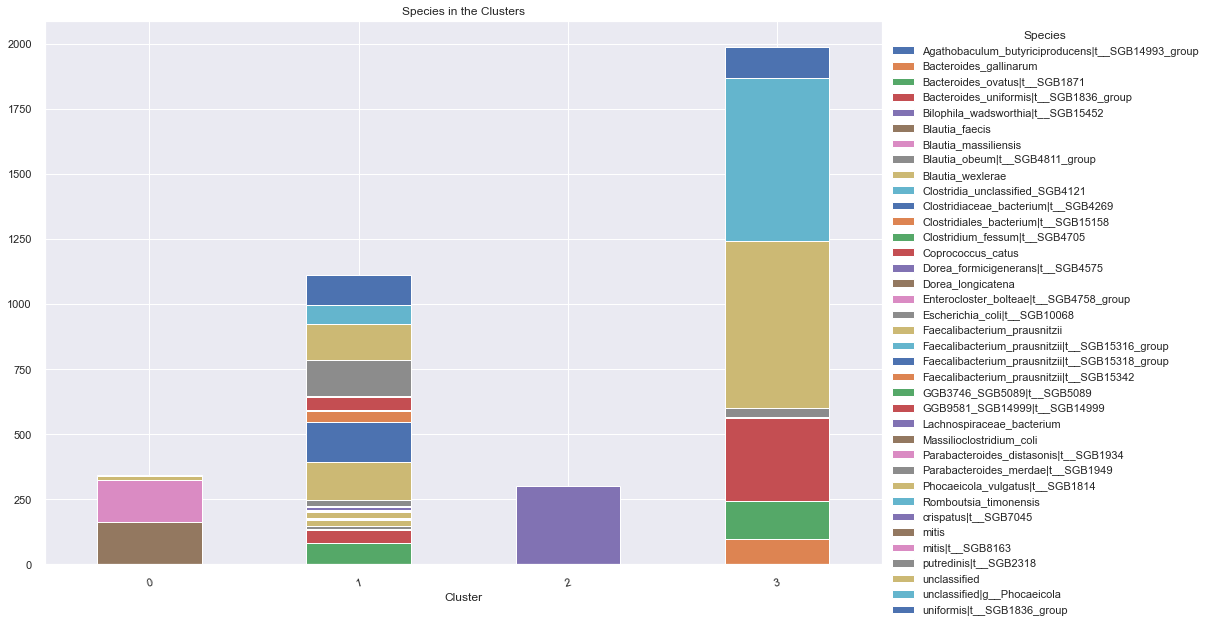

In [150]:
dict_cluster = stackedBar(df_h, y_kmeans, 4)

In [151]:
# species of clusters
print('Cluster 0 : ')
display(dict_cluster['df_0'])
print('Cluster 1 : ')
display(dict_cluster['df_1'])
print('Cluster 2 : ')
display(dict_cluster['df_2'])
print('Cluster 3 : ')
display(dict_cluster['df_3'])

Cluster 0 : 


0          1    2          3
mitis                             161.02318    2.52973  0.0    0.13840
mitis|t__SGB8163                  160.95197    2.47512  0.0    0.13792
unclassified                       18.42771  138.79869  0.0  639.03648
unclassified|g__Phocaeicola         0.35101   72.77903  0.0  627.05821
_Phocaeicola_vulgatus|t__SGB1814    0.33317   48.89158  0.0  321.06781

Cluster 1 : 


0          1    2          3
_Cutibacterium_acnes|t__SGB16955   0.09753  150.49463  0.0    0.00000
Phocaeicola_vulgatus|t__SGB1814    0.00000  147.92716  0.0    0.00000
unclassified                      18.42771  138.79869  0.0  639.03648
putredinis|t__SGB2318              0.11345  136.90104  0.0   37.32823
uniformis|t__SGB1836_group         0.04059  114.78892  0.0  120.86617

Cluster 2 : 


0         1          2  \
crispatus|t__SGB7045                               0.0   0.00000  299.97708   
Agathobaculum_butyriciproducens|t__SGB14993_group  0.0   0.17179    0.00000   
Bacteroides_gallinarum                             0.0   0.00018    0.00000   
Bacteroides_ovatus|t__SGB1871                      0.0  81.98701    0.00000   
Bacteroides_uniformis|t__SGB1836_group             0.0  48.97620    0.00000   

                                                         3  
crispatus|t__SGB7045                               0.15585  
Agathobaculum_butyriciproducens|t__SGB14993_group  0.00000  
Bacteroides_gallinarum                             0.00000  
Bacteroides_ovatus|t__SGB1871                      0.00000  
Bacteroides_uniformis|t__SGB1836_group             0.00000

Cluster 3 : 


0          1    2          3
unclassified                            18.42771  138.79869  0.0  639.03648
unclassified|g__Phocaeicola              0.35101   72.77903  0.0  627.05821
_Phocaeicola_vulgatus|t__SGB1814         0.33317   48.89158  0.0  321.06781
_Phocaeicola_plebeius|t__SGB1903_group   0.00000    4.32085  0.0  147.20963
uniformis|t__SGB1836_group               0.04059  114.78892  0.0  120.86617

Hierarchical Clustering

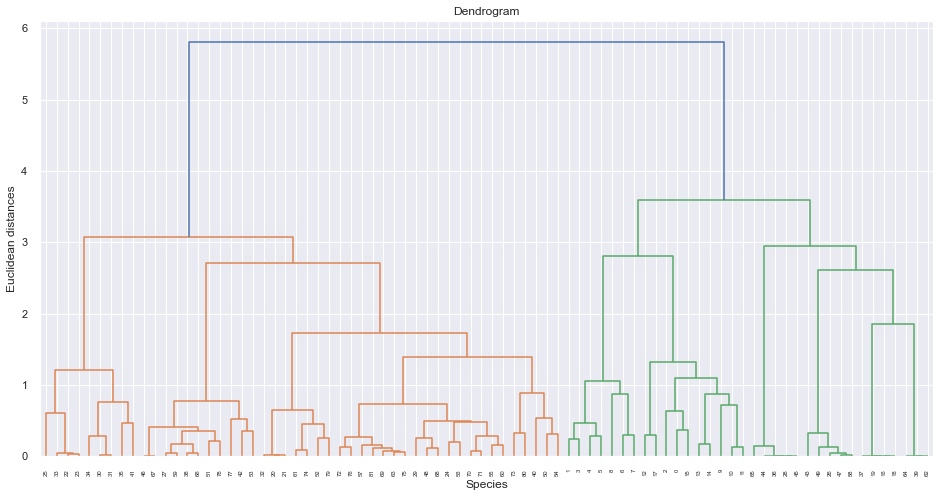

In [152]:
df_scaled_h = hierarchicalFirst(df_h)

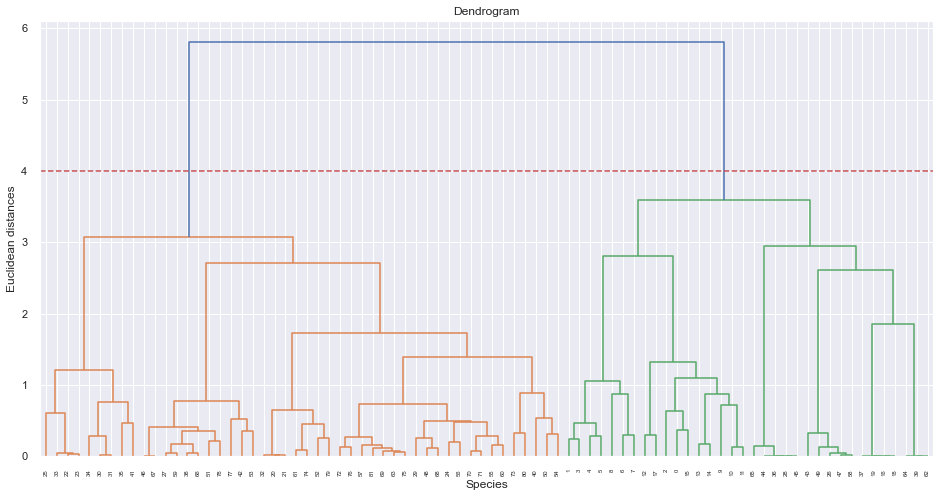

In [153]:
hierarchicalSecond(df_scaled_h,4)

In [154]:
y_hc, labels = agglomerative(df_scaled_h, 2)
y_hc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

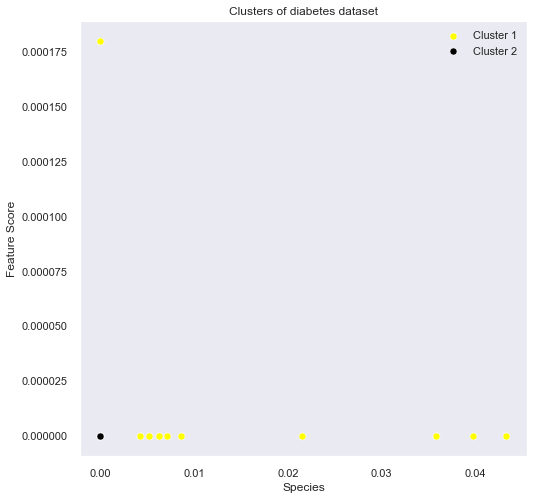

In [155]:
# agglomerative clustering = 2
X = df_h.to_numpy() # have to convert to numpy to plot graph

plt.figure(figsize=(8,8))
sns.scatterplot(X[y_hc == 0,0], X[y_hc == 0,1], color = 'yellow', label ='Cluster 1', s=50)
sns.scatterplot(X[y_hc == 1,0], X[y_hc == 1,1], color = 'black', label ='Cluster 2', s=50)
#sns.scatterplot(X[y_hc == 2,0], X[y_hc == 2,1], color = 'orange', label ='Cluster 3', s=50)
#sns.scatterplot(X[y_hc == 3,0], X[y_hc == 3,1], color = 'blue', label ='Cluster 4', s=50)
#sns.scatterplot(X[y_kmeans == 4,0], X[y_kmeans == 4,1], color = 'green', label ='Cluster 5', s=50)
#sns.scatterplot(X[y_kmeans == 5,0], X[y_kmeans == 5,1], color = 'grey', label ='Cluster 6', s=50)
#sns.scatterplot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], color ='red', label='Centroids', s=100, marker=',')
plt.grid(False)
plt.title('Clusters of diabetes dataset')
plt.xlabel('Species')
plt.ylabel('Feature Score')
plt.legend()
plt.show()

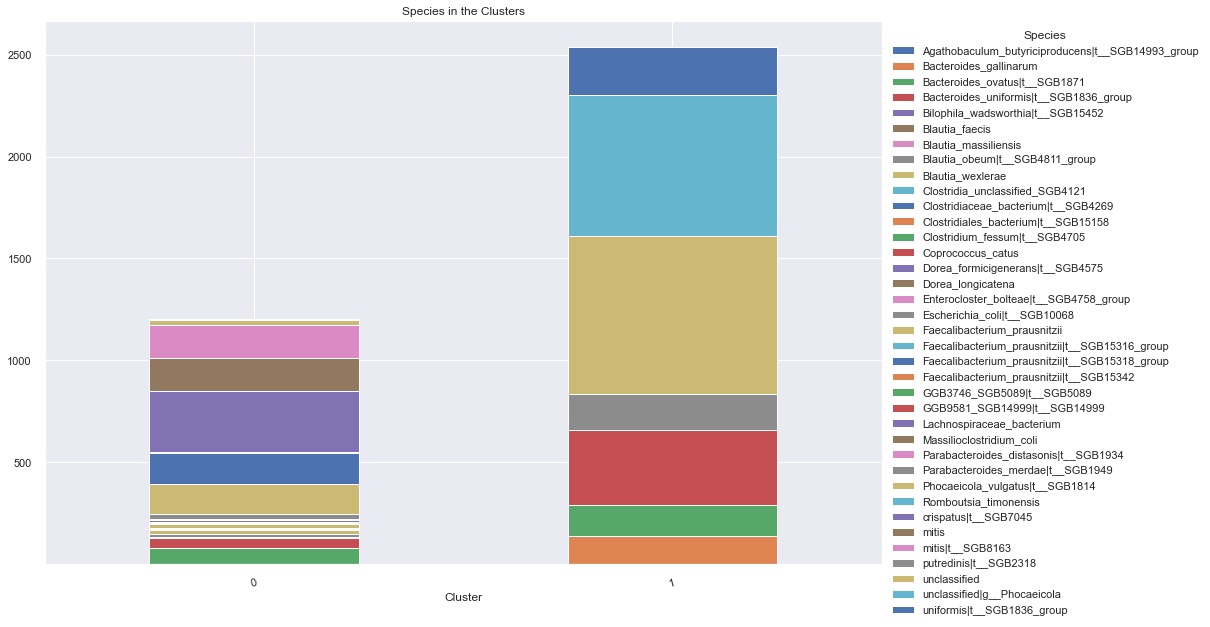

In [156]:
dict_cluster = stackedBar(df_h, y_hc, 2)

In [157]:
# species of cluster 1
print('Cluster 0 : ')
display(dict_cluster['df_0'])
print('Cluster 1 : ')
display(dict_cluster['df_1'])

Cluster 0 : 


0        1
crispatus|t__SGB7045              299.97708  0.15585
mitis                             162.34339  1.34792
mitis|t__SGB8163                  162.27107  1.29394
_Cutibacterium_acnes|t__SGB16955  150.59052  0.00164
Phocaeicola_vulgatus|t__SGB1814   147.92716  0.00000

Cluster 1 : 


0          1
unclassified                      23.06560  773.19728
unclassified|g__Phocaeicola        4.32643  695.86182
_Phocaeicola_vulgatus|t__SGB1814   4.30859  365.98397
uniformis|t__SGB1836_group         0.49209  235.20359
putredinis|t__SGB2318              0.13844  174.20428

#### Random Forest Features

In [181]:
getColNames(X_train_rf)
print('Total Number of Features :', len(singleList))

Total Number of Features : 15


In [182]:
singleList

['Agathobaculum_butyriciproducens|t__SGB14993_group',
 'Bacteroides_ovatus|t__SGB1871',
 'Bacteroides_uniformis|t__SGB1836_group',
 'Blautia_faecis',
 'Blautia_massiliensis',
 'Blautia_obeum|t__SGB4811_group',
 'Blautia_wexlerae',
 'Clostridiaceae_bacterium|t__SGB4269',
 'Clostridium_fessum|t__SGB4705',
 'Coprococcus_catus',
 'Dorea_longicatena',
 'Enterocloster_bolteae|t__SGB4758_group',
 'Escherichia_coli|t__SGB10068',
 'GGB9581_SGB14999|t__SGB14999',
 'Parabacteroides_merdae|t__SGB1949']

In [31]:
df_d, df_h = dropCol(singleList)

Diabetes df shape : (70, 15)
Healthy df shape : (82, 15)


Kmeans

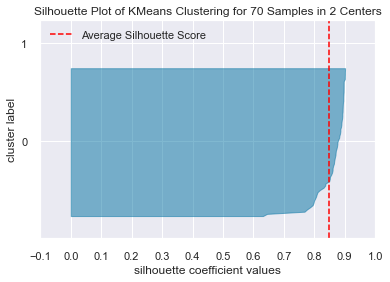

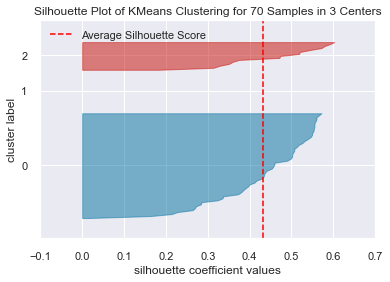

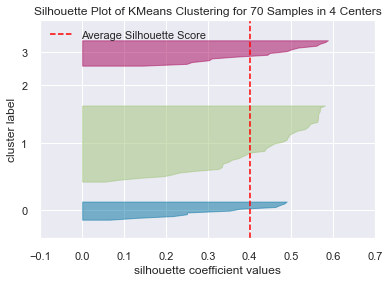

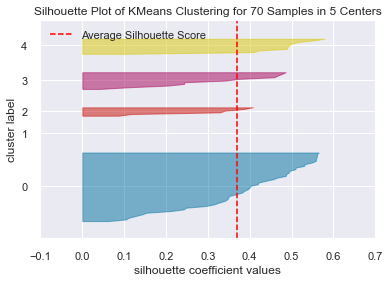

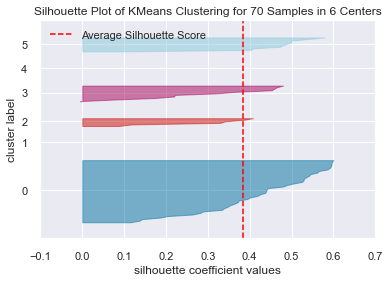

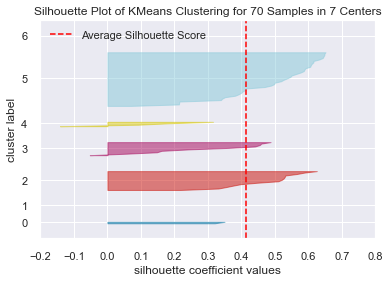

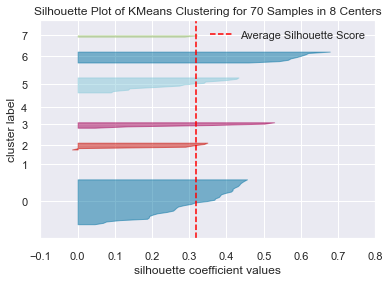

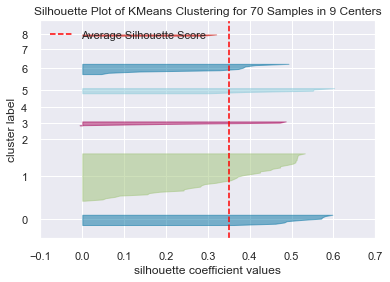

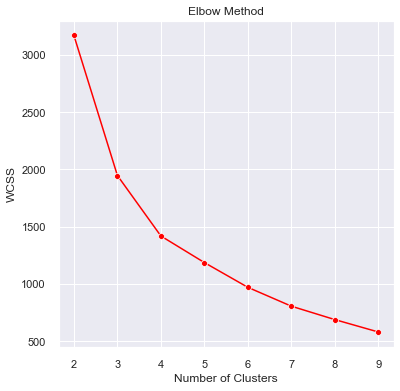

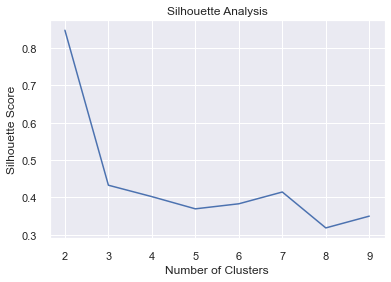

In [33]:
# for diabetes df
elbowAndSilhouette(df_d)

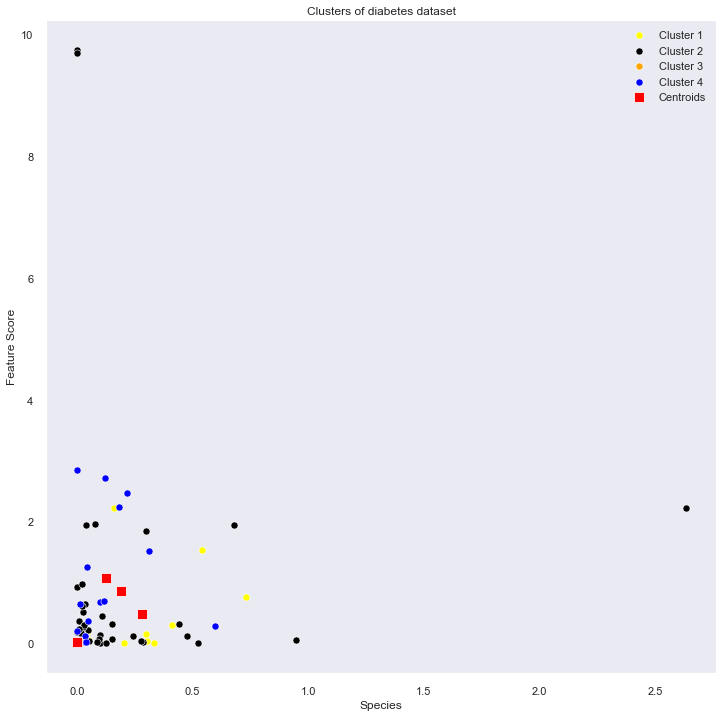

In [34]:
# applying k means = 4
X = df_d.to_numpy() # have to convert to numpy to plot graph
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X)

plt.figure(figsize=(12,12))
sns.scatterplot(X[y_kmeans == 0,0], X[y_kmeans == 0,1], color = 'yellow', label ='Cluster 1', s=50)
sns.scatterplot(X[y_kmeans == 1,0], X[y_kmeans == 1,1], color = 'black', label ='Cluster 2', s=50)
sns.scatterplot(X[y_kmeans == 2,0], X[y_kmeans == 2,1], color = 'orange', label ='Cluster 3', s=50)
sns.scatterplot(X[y_kmeans == 3,0], X[y_kmeans == 3,1], color = 'blue', label ='Cluster 4', s=50)
#sns.scatterplot(X[y_kmeans == 4,0], X[y_kmeans == 4,1], color = 'green', label ='Cluster 5', s=50)
#sns.scatterplot(X[y_kmeans == 5,0], X[y_kmeans == 5,1], color = 'grey', label ='Cluster 6', s=50)
sns.scatterplot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], color ='red', label='Centroids', s=100, marker=',')
plt.grid(False)
plt.title('Clusters of diabetes dataset')
plt.xlabel('Species')
plt.ylabel('Feature Score')
plt.legend()
plt.show()

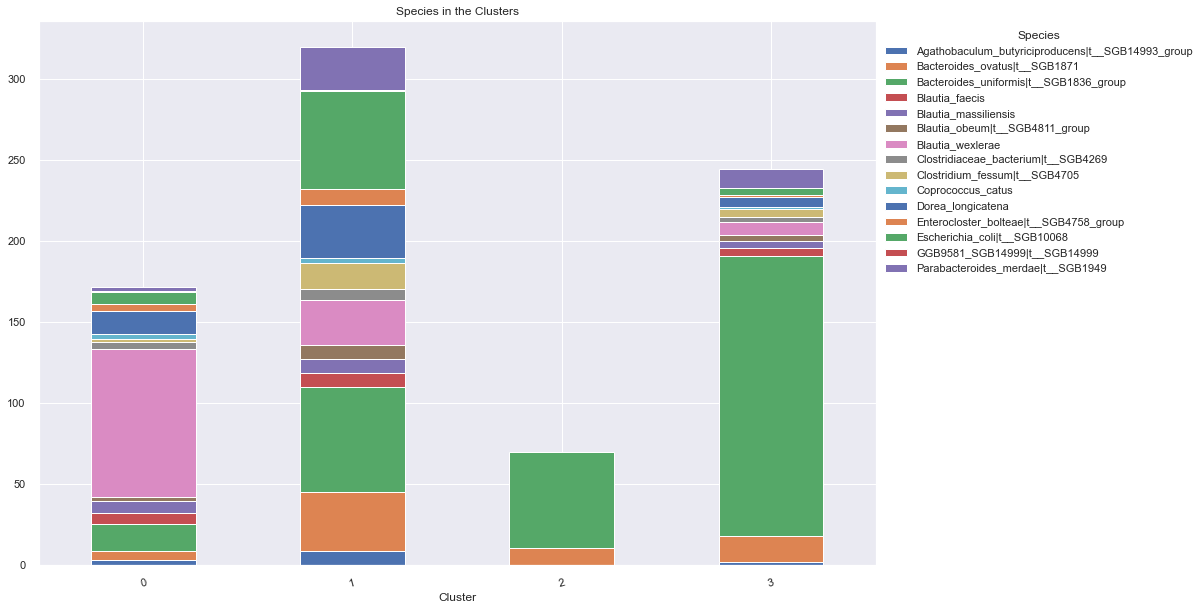

In [35]:
dict_cluster = stackedBar(df_d, y_kmeans, 4)

In [36]:
# species of cluster 1
print('Cluster 0 : ')
display(dict_cluster['df_0'])
print('Cluster 1 : ')
display(dict_cluster['df_1'])
print('Cluster 2 : ')
display(dict_cluster['df_2'])
print('Cluster 3 : ')
display(dict_cluster['df_3'])

Cluster 0 : 


0         1         2  \
Blautia_wexlerae                        91.31328  27.84403   0.00000   
Bacteroides_uniformis|t__SGB1836_group  16.87588  64.68839   0.01840   
Dorea_longicatena                       14.49021  32.50996   0.00000   
Blautia_massiliensis                     7.46091   8.47302   0.00000   
Escherichia_coli|t__SGB10068             7.32992  60.14498  59.21869   

                                                3  
Blautia_wexlerae                          7.72785  
Bacteroides_uniformis|t__SGB1836_group  172.61734  
Dorea_longicatena                         6.24787  
Blautia_massiliensis                      4.12261  
Escherichia_coli|t__SGB10068              3.84114

Cluster 1 : 


0         1         2  \
Bacteroides_uniformis|t__SGB1836_group  16.87588  64.68839   0.01840   
Escherichia_coli|t__SGB10068             7.32992  60.14498  59.21869   
Bacteroides_ovatus|t__SGB1871            5.23802  36.86200   0.01087   
Dorea_longicatena                       14.49021  32.50996   0.00000   
Blautia_wexlerae                        91.31328  27.84403   0.00000   

                                                3  
Bacteroides_uniformis|t__SGB1836_group  172.61734  
Escherichia_coli|t__SGB10068              3.84114  
Bacteroides_ovatus|t__SGB1871            16.03649  
Dorea_longicatena                         6.24787  
Blautia_wexlerae                          7.72785

Cluster 2 : 


0         1  \
Escherichia_coli|t__SGB10068                        7.32992  60.14498   
Enterocloster_bolteae|t__SGB4758_group              4.48485  10.00185   
Bacteroides_uniformis|t__SGB1836_group             16.87588  64.68839   
Bacteroides_ovatus|t__SGB1871                       5.23802  36.86200   
Agathobaculum_butyriciproducens|t__SGB14993_group   3.08906   8.24751   

                                                          2          3  
Escherichia_coli|t__SGB10068                       59.21869    3.84114  
Enterocloster_bolteae|t__SGB4758_group             10.02534    1.50432  
Bacteroides_uniformis|t__SGB1836_group              0.01840  172.61734  
Bacteroides_ovatus|t__SGB1871                       0.01087   16.03649  
Agathobaculum_butyriciproducens|t__SGB14993_group   0.00000    1.86477

Cluster 3 : 


0         1        2          3
Bacteroides_uniformis|t__SGB1836_group  16.87588  64.68839  0.01840  172.61734
Bacteroides_ovatus|t__SGB1871            5.23802  36.86200  0.01087   16.03649
Parabacteroides_merdae|t__SGB1949        2.52550  26.48026  0.00000   11.62363
Blautia_wexlerae                        91.31328  27.84403  0.00000    7.72785
Dorea_longicatena                       14.49021  32.50996  0.00000    6.24787

Hierarchical Clustering

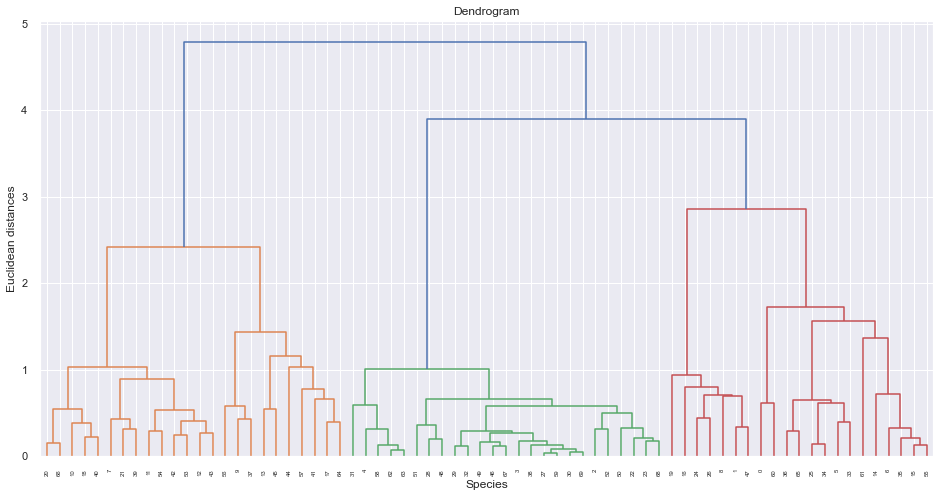

In [38]:
df_scaled_d = hierarchicalFirst(df_d)

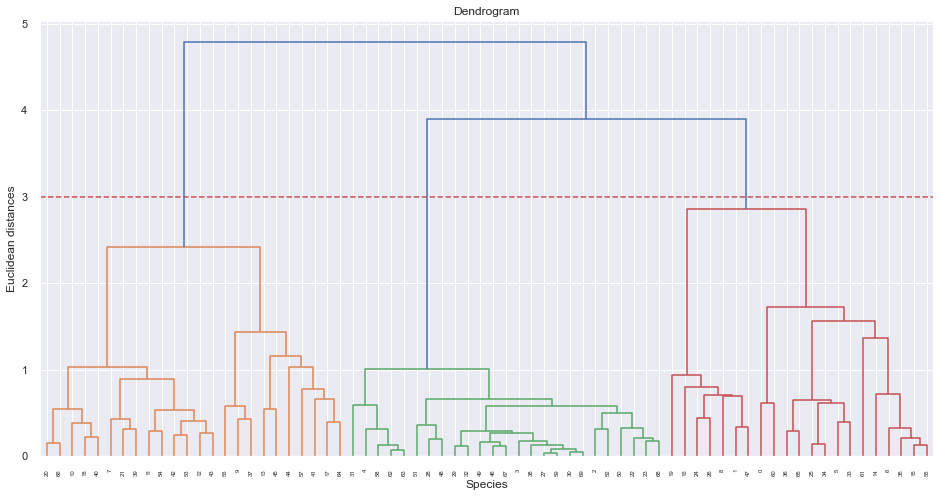

In [67]:
hierarchicalSecond(df_scaled_d,3.0)

In [68]:
y_hc,labels  = agglomerative(df_scaled_d, 3)
y_hc

array([0, 0, 2, 2, 2, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 2, 0, 2, 2, 2, 2, 2, 1, 1, 0, 1, 1, 2, 2, 0, 0, 2, 2, 1, 0,
       1, 2, 2, 2], dtype=int64)

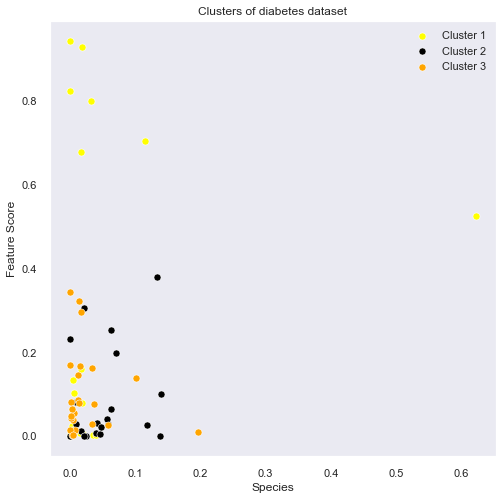

In [69]:
# agglomerative clustering = 3
X = df_scaled_d.to_numpy() # have to convert to numpy to plot graph

plt.figure(figsize=(8,8))
sns.scatterplot(X[y_hc == 0,0], X[y_hc == 0,1], color = 'yellow', label ='Cluster 1', s=50)
sns.scatterplot(X[y_hc == 1,0], X[y_hc == 1,1], color = 'black', label ='Cluster 2', s=50)
sns.scatterplot(X[y_hc == 2,0], X[y_hc == 2,1], color = 'orange', label ='Cluster 3', s=50)
#sns.scatterplot(X[y_hc == 3,0], X[y_hc == 3,1], color = 'blue', label ='Cluster 4', s=50)
#sns.scatterplot(X[y_kmeans == 4,0], X[y_kmeans == 4,1], color = 'green', label ='Cluster 5', s=50)
#sns.scatterplot(X[y_kmeans == 5,0], X[y_kmeans == 5,1], color = 'grey', label ='Cluster 6', s=50)
#sns.scatterplot(labels[:,0], labels[:,1], color ='red', label='Centroids', s=100, marker=',', c=labels)
plt.grid(False)
plt.title('Clusters of diabetes dataset')
plt.xlabel('Species')
plt.ylabel('Feature Score')
plt.legend()
plt.show()

Healthy

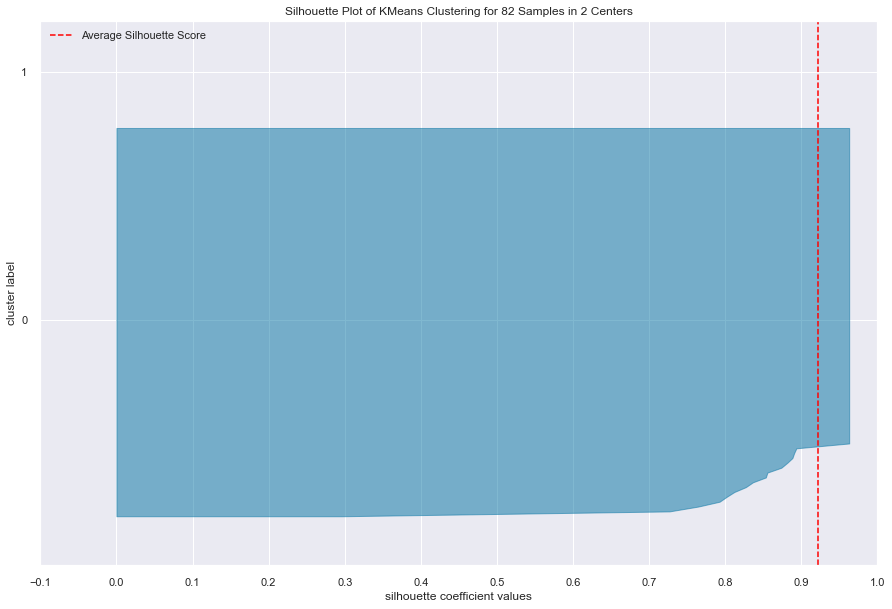

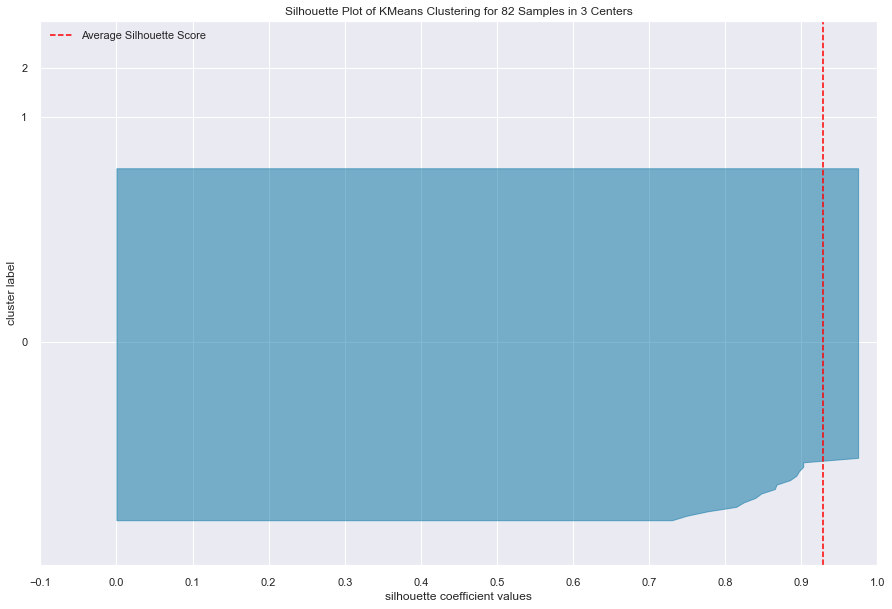

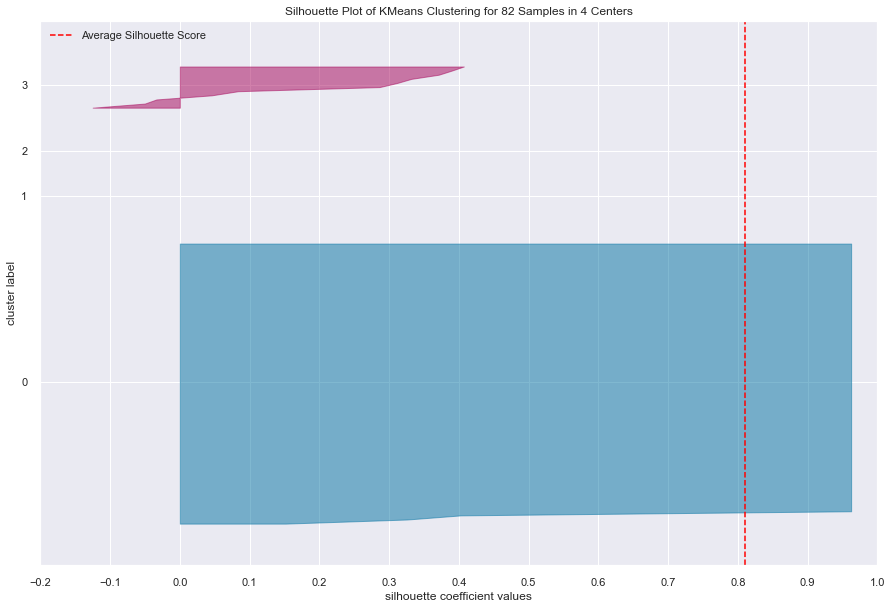

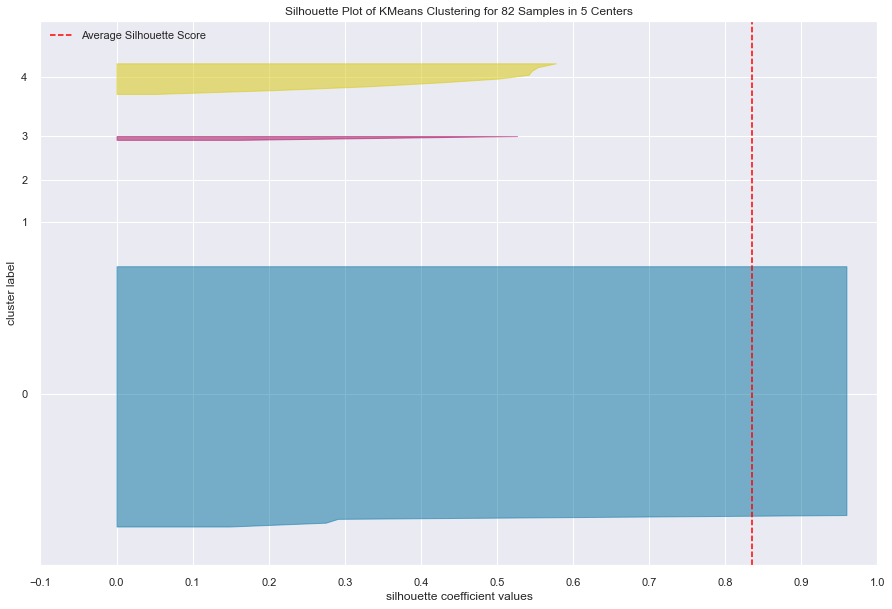

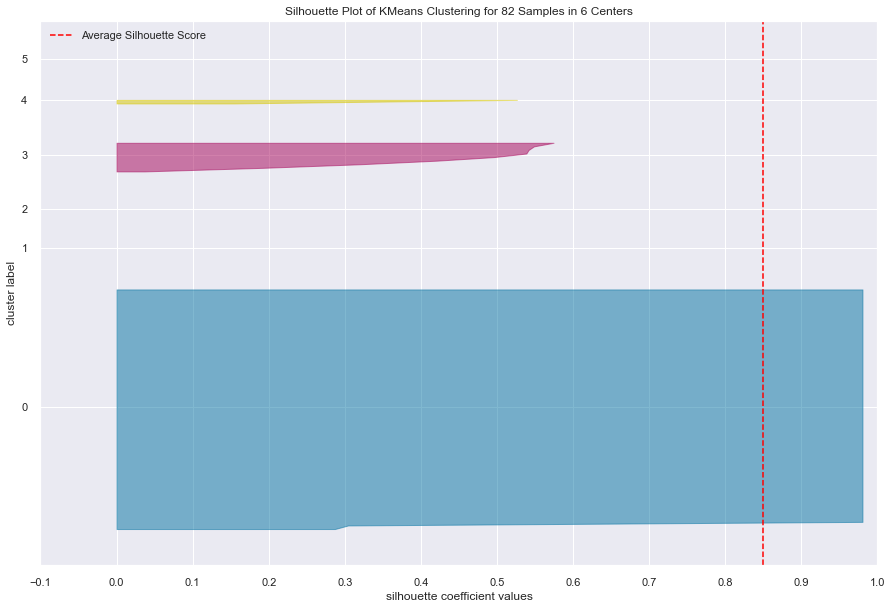

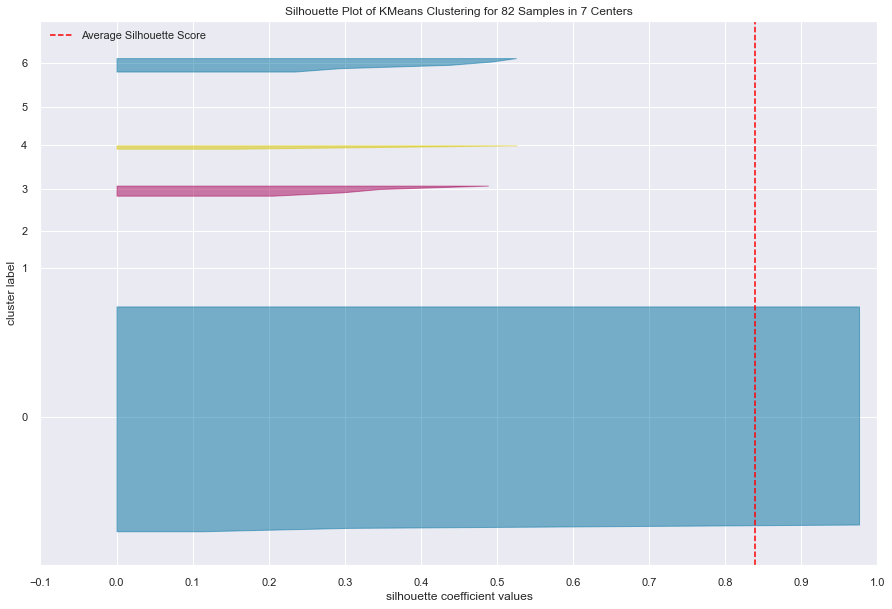

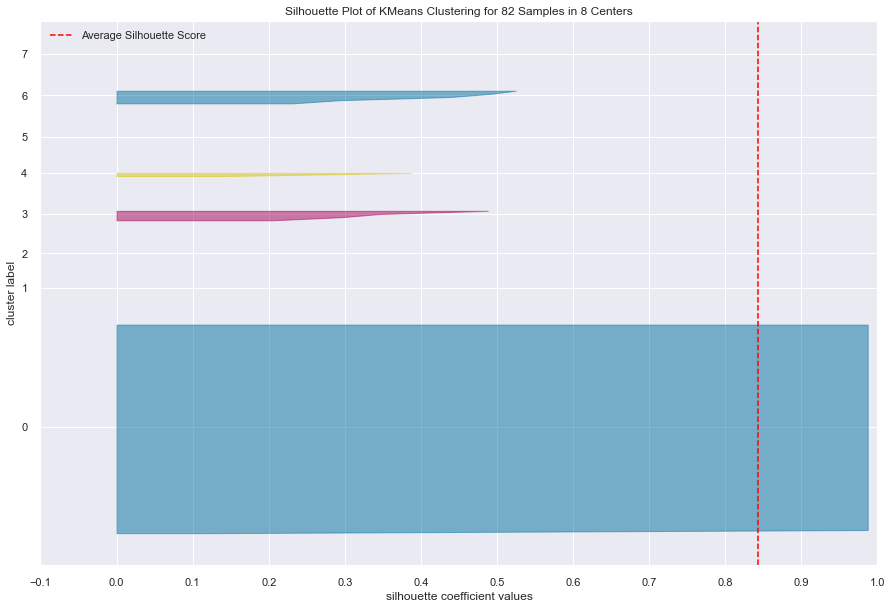

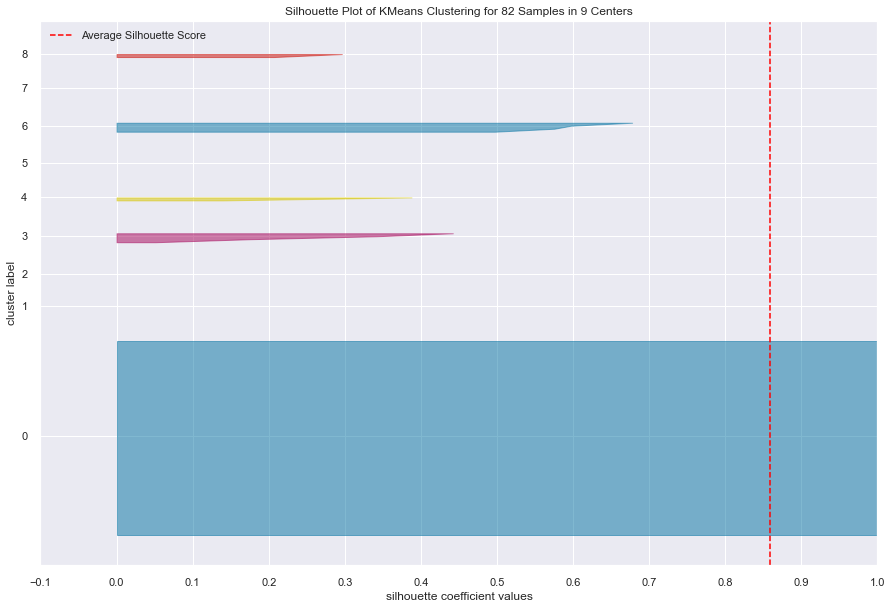

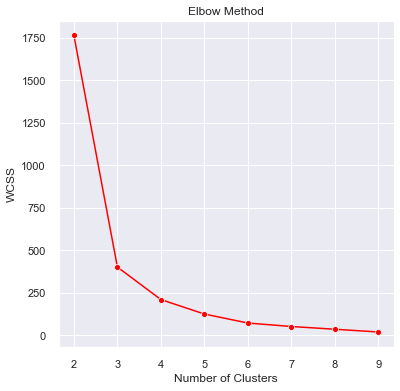

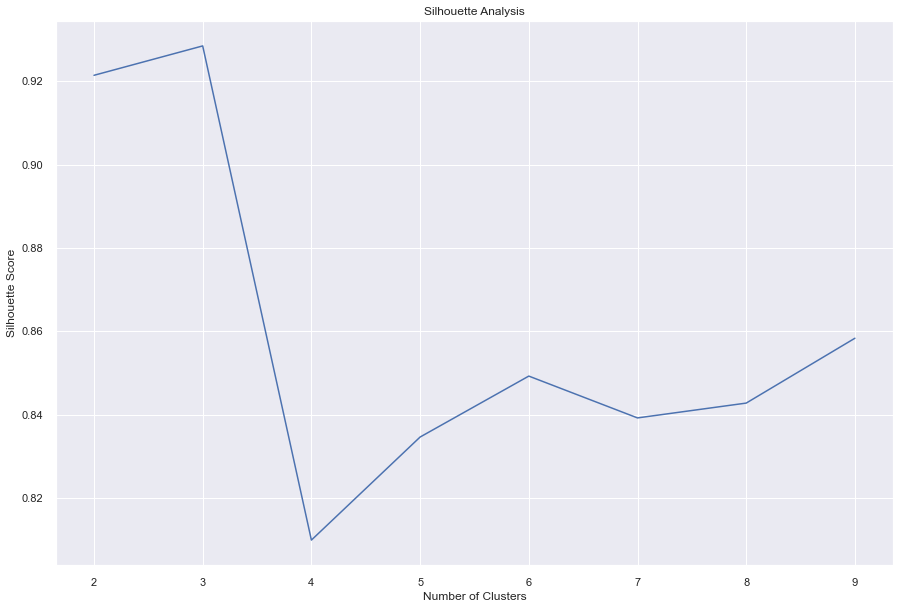

In [71]:
elbowAndSilhouette(df_h)

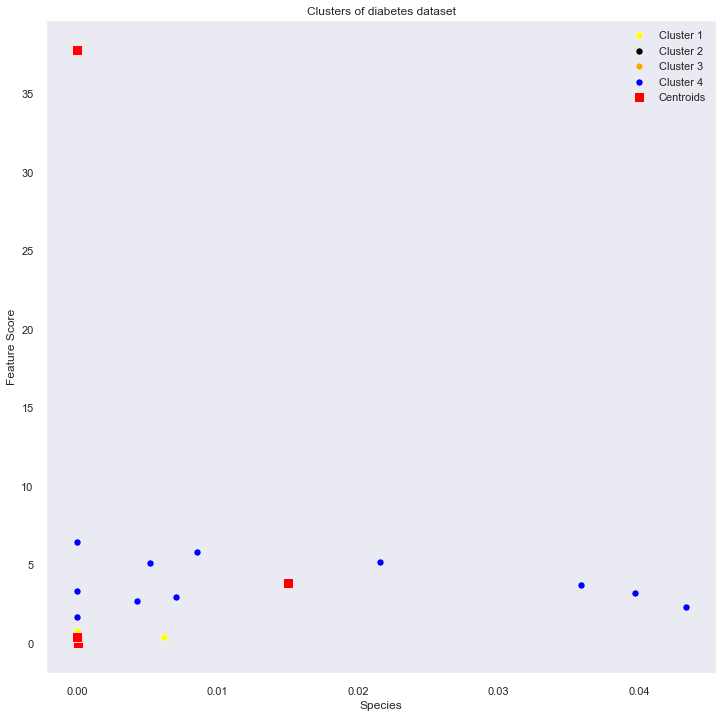

In [72]:
# applying k means = 4
X = df_h.to_numpy() # have to convert to numpy to plot graph
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X)

plt.figure(figsize=(12,12))
sns.scatterplot(X[y_kmeans == 0,0], X[y_kmeans == 0,1], color = 'yellow', label ='Cluster 1', s=50)
sns.scatterplot(X[y_kmeans == 1,0], X[y_kmeans == 1,1], color = 'black', label ='Cluster 2', s=50)
sns.scatterplot(X[y_kmeans == 2,0], X[y_kmeans == 2,1], color = 'orange', label ='Cluster 3', s=50)
sns.scatterplot(X[y_kmeans == 3,0], X[y_kmeans == 3,1], color = 'blue', label ='Cluster 4', s=50)
#sns.scatterplot(X[y_kmeans == 4,0], X[y_kmeans == 4,1], color = 'green', label ='Cluster 5', s=50)
#sns.scatterplot(X[y_kmeans == 5,0], X[y_kmeans == 5,1], color = 'grey', label ='Cluster 6', s=50)
sns.scatterplot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], color ='red', label='Centroids', s=100, marker=',')
plt.grid(False)
plt.title('Clusters of diabetes dataset')
plt.xlabel('Species')
plt.ylabel('Feature Score')
plt.legend()
plt.show()

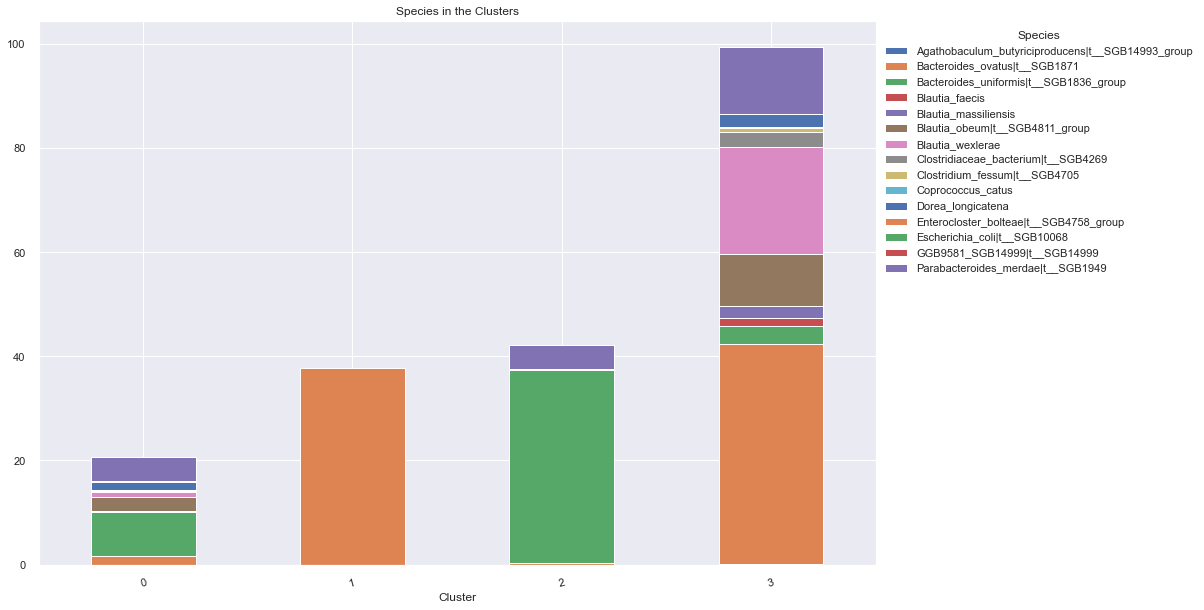

In [73]:
dict_cluster = stackedBar(df_h, y_kmeans, 4)

In [74]:
# species of clusters
print('Cluster 0 : ')
display(dict_cluster['df_0'])
print('Cluster 1 : ')
display(dict_cluster['df_1'])
print('Cluster 2 : ')
display(dict_cluster['df_2'])
print('Cluster 3 : ')
display(dict_cluster['df_3'])

Cluster 0 : 


0         1         2         3
Bacteroides_uniformis|t__SGB1836_group  8.38941   0.00000  37.03960   3.54719
Parabacteroides_merdae|t__SGB1949       4.66971   0.00000   4.55445  12.89180
Blautia_obeum|t__SGB4811_group          2.59517   0.00000   0.00000   9.92836
Bacteroides_ovatus|t__SGB1871           1.65099  37.75104   0.38324  42.20174
Dorea_longicatena                       1.56789   0.00000   0.00487   2.50362

Cluster 1 : 


0         1        2         3
Bacteroides_ovatus|t__SGB1871           1.65099  37.75104  0.38324  42.20174
Escherichia_coli|t__SGB10068            0.02157   0.05144  0.03230   0.00000
Blautia_wexlerae                        0.93257   0.01649  0.08423  20.58973
Enterocloster_bolteae|t__SGB4758_group  0.00000   0.00308  0.00000   0.00150
Blautia_massiliensis                    0.00092   0.00208  0.00246   2.31406

Cluster 2 : 


0         1         2         3
Bacteroides_uniformis|t__SGB1836_group  8.38941   0.00000  37.03960   3.54719
Parabacteroides_merdae|t__SGB1949       4.66971   0.00000   4.55445  12.89180
Bacteroides_ovatus|t__SGB1871           1.65099  37.75104   0.38324  42.20174
Blautia_wexlerae                        0.93257   0.01649   0.08423  20.58973
Escherichia_coli|t__SGB10068            0.02157   0.05144   0.03230   0.00000

Cluster 3 : 


0         1         2         3
Bacteroides_ovatus|t__SGB1871           1.65099  37.75104   0.38324  42.20174
Blautia_wexlerae                        0.93257   0.01649   0.08423  20.58973
Parabacteroides_merdae|t__SGB1949       4.66971   0.00000   4.55445  12.89180
Blautia_obeum|t__SGB4811_group          2.59517   0.00000   0.00000   9.92836
Bacteroides_uniformis|t__SGB1836_group  8.38941   0.00000  37.03960   3.54719

In [75]:
########### HIERARCHICAL CLUSTERING

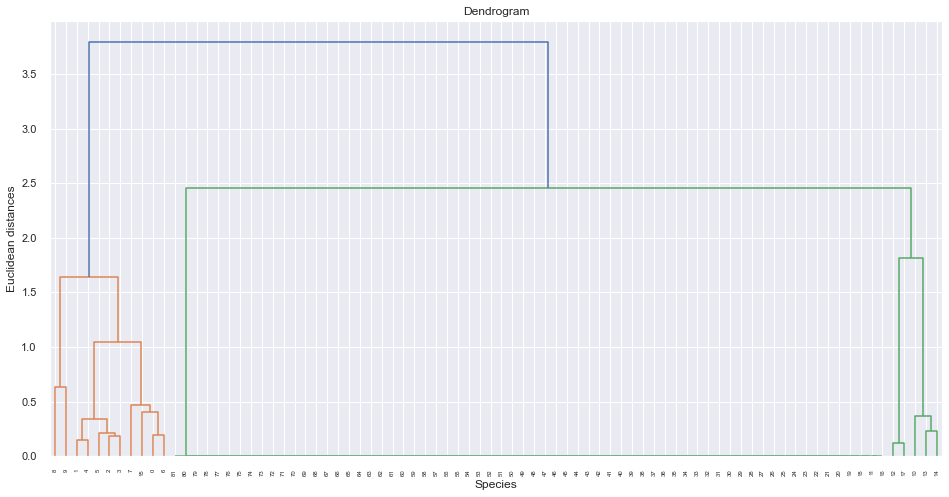

In [76]:
df_scaled_h = hierarchicalFirst(df_h)

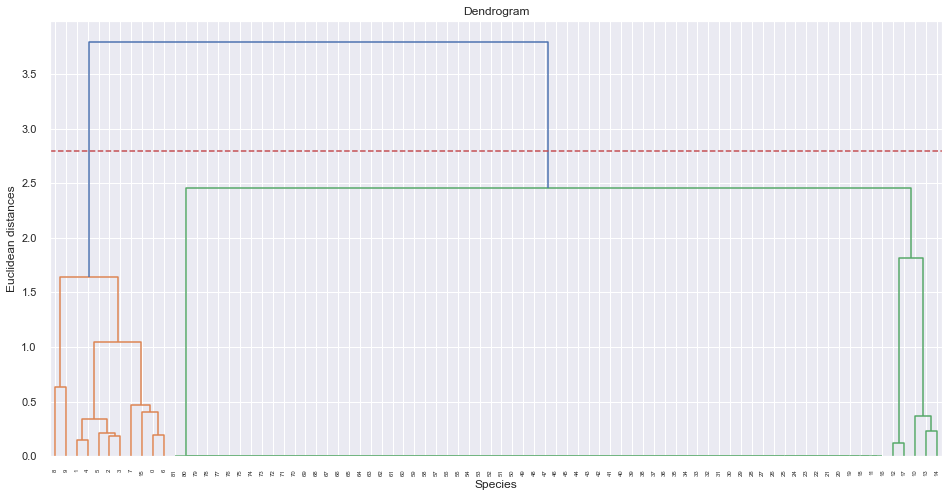

In [77]:
hierarchicalSecond(df_scaled_h,2.8)

In [78]:
y_hc, labels = agglomerative(df_scaled_h, 2)
y_hc

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

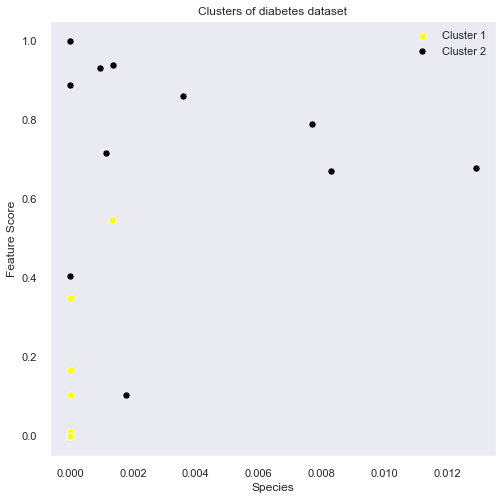

In [79]:
# agglomerative clustering = 2
X = df_scaled_h.to_numpy() # have to convert to numpy to plot graph

plt.figure(figsize=(8,8))
sns.scatterplot(X[y_hc == 0,0], X[y_hc == 0,1], color = 'yellow', label ='Cluster 1', s=50)
sns.scatterplot(X[y_hc == 1,0], X[y_hc == 1,1], color = 'black', label ='Cluster 2', s=50)
#sns.scatterplot(X[y_hc == 2,0], X[y_hc == 2,1], color = 'orange', label ='Cluster 3', s=50)
#sns.scatterplot(X[y_hc == 3,0], X[y_hc == 3,1], color = 'blue', label ='Cluster 4', s=50)
#sns.scatterplot(X[y_kmeans == 4,0], X[y_kmeans == 4,1], color = 'green', label ='Cluster 5', s=50)
#sns.scatterplot(X[y_kmeans == 5,0], X[y_kmeans == 5,1], color = 'grey', label ='Cluster 6', s=50)
#sns.scatterplot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], color ='red', label='Centroids', s=100, marker=',')
plt.grid(False)
plt.title('Clusters of diabetes dataset')
plt.xlabel('Species')
plt.ylabel('Feature Score')
plt.legend()
plt.show()

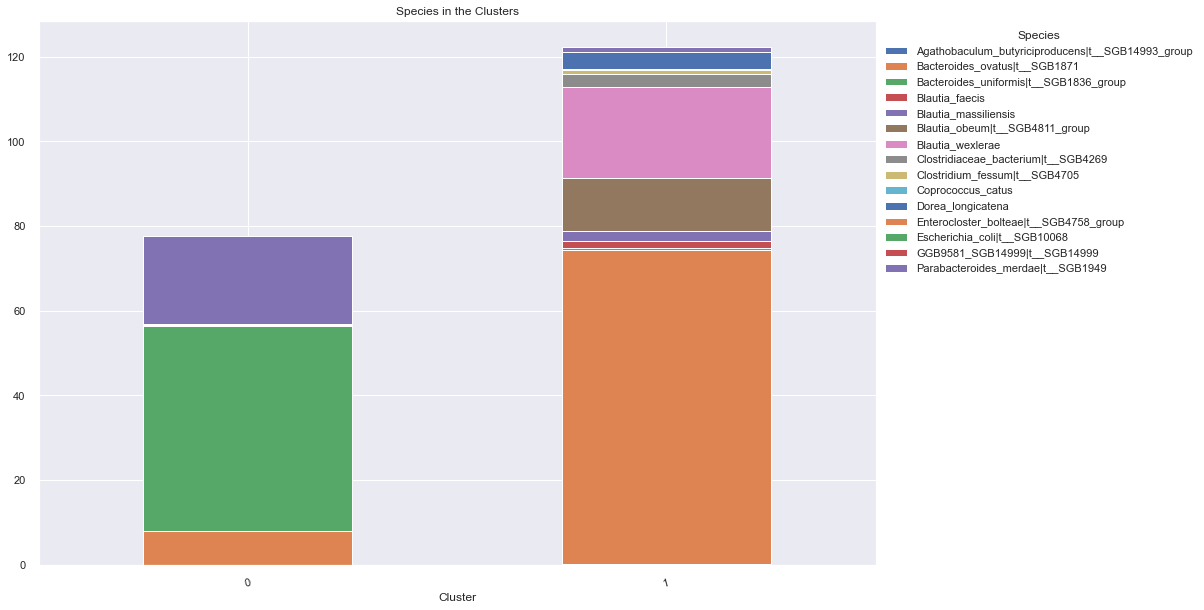

In [80]:
dict_cluster = stackedBar(df_h, y_hc, 2)

In [81]:
# species of cluster 1
print('Cluster 0 : ')
display(dict_cluster['df_0'])
print('Cluster 1 : ')
display(dict_cluster['df_1'])

Cluster 0 : 


0         1
Bacteroides_uniformis|t__SGB1836_group  48.37095   0.60525
Parabacteroides_merdae|t__SGB1949       20.88378   1.23218
Bacteroides_ovatus|t__SGB1871            7.90709  74.07992
Blautia_wexlerae                         0.19864  21.42438
Dorea_longicatena                        0.07648   3.99990

Cluster 1 : 


0         1
Bacteroides_ovatus|t__SGB1871        7.90709  74.07992
Blautia_wexlerae                     0.19864  21.42438
Blautia_obeum|t__SGB4811_group       0.00668  12.51685
Dorea_longicatena                    0.07648   3.99990
Clostridiaceae_bacterium|t__SGB4269  0.04364   3.12014

#### mRMR features

In [185]:
getColNames(X_train_mRMR)
print('Total Number of Features :', len(singleList))

Total Number of Features : 16


In [186]:
singleList

['Bacteroides_gallinarum',
 'Bilophila_wadsworthia|t__SGB15452',
 'Clostridia_unclassified_SGB4121',
 'Clostridiales_bacterium|t__SGB15158',
 'Clostridium_fessum|t__SGB4705',
 'Dorea_formicigenerans|t__SGB4575',
 'Faecalibacterium_prausnitzii',
 'Faecalibacterium_prausnitzii|t__SGB15316_group',
 'Faecalibacterium_prausnitzii|t__SGB15318_group',
 'Faecalibacterium_prausnitzii|t__SGB15342',
 'Lachnospiraceae_bacterium',
 'Massilioclostridium_coli',
 'Parabacteroides_distasonis|t__SGB1934',
 'Romboutsia_timonensis',
 'Ruminococcaceae_bacterium|t__SGB4181',
 'unclassified']

In [187]:
df_d, df_h = dropCol(singleList)

Diabetes df shape : (70, 15)
Healthy df shape : (82, 15)


KMeans

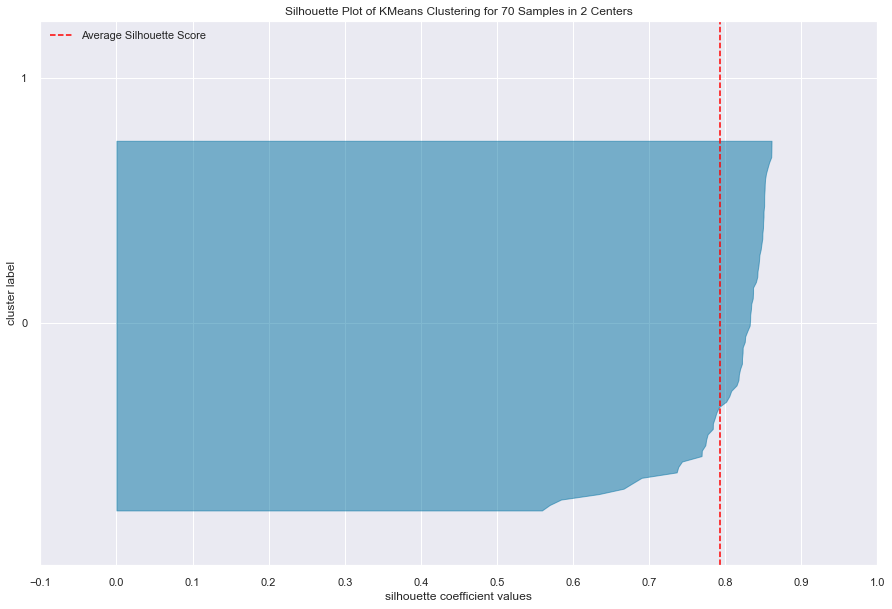

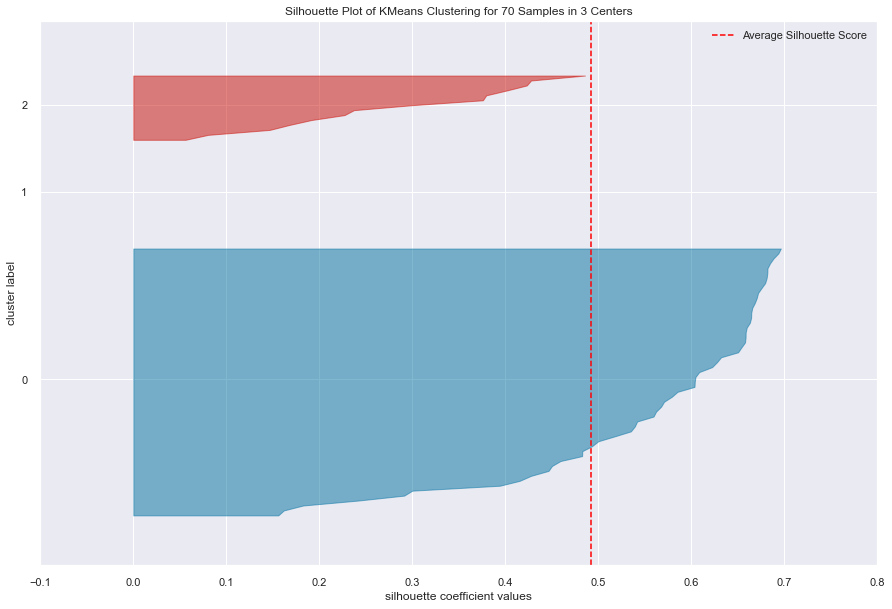

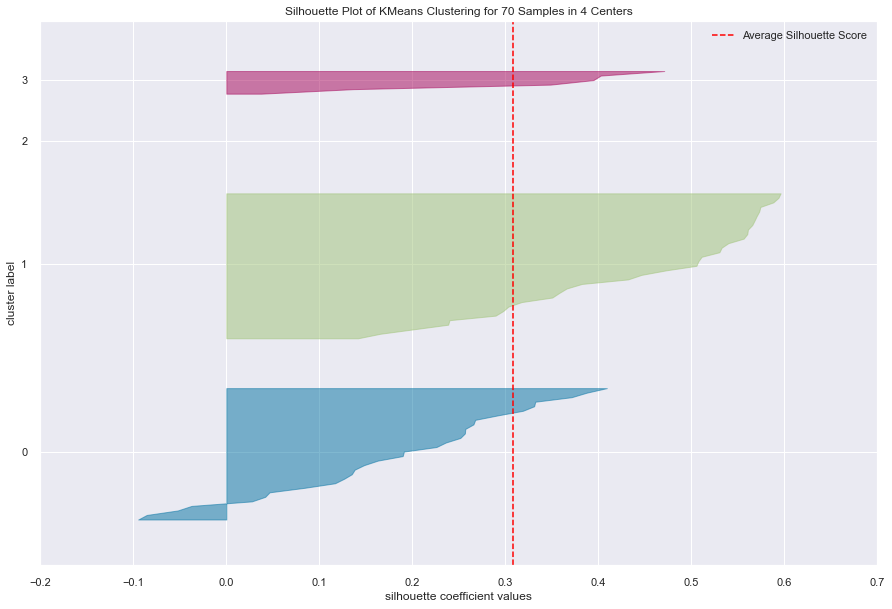

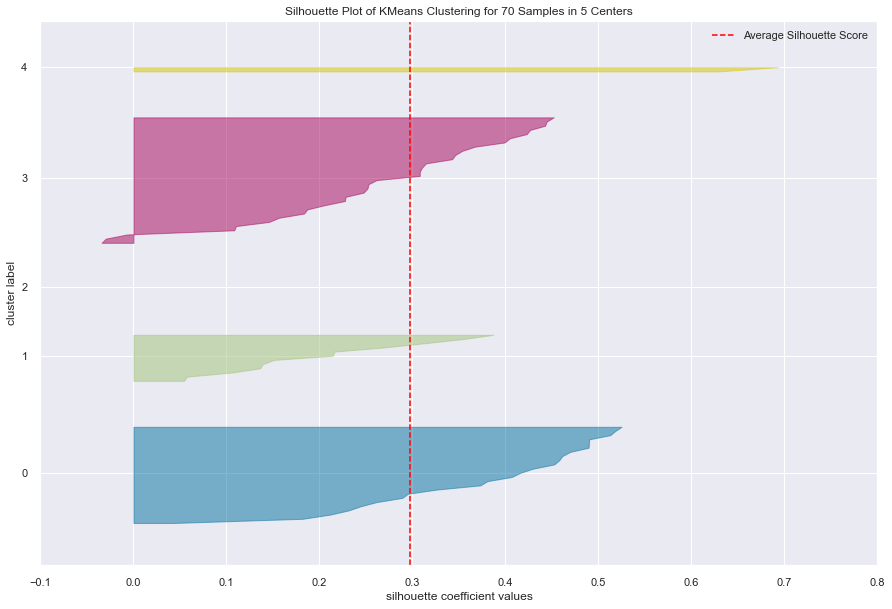

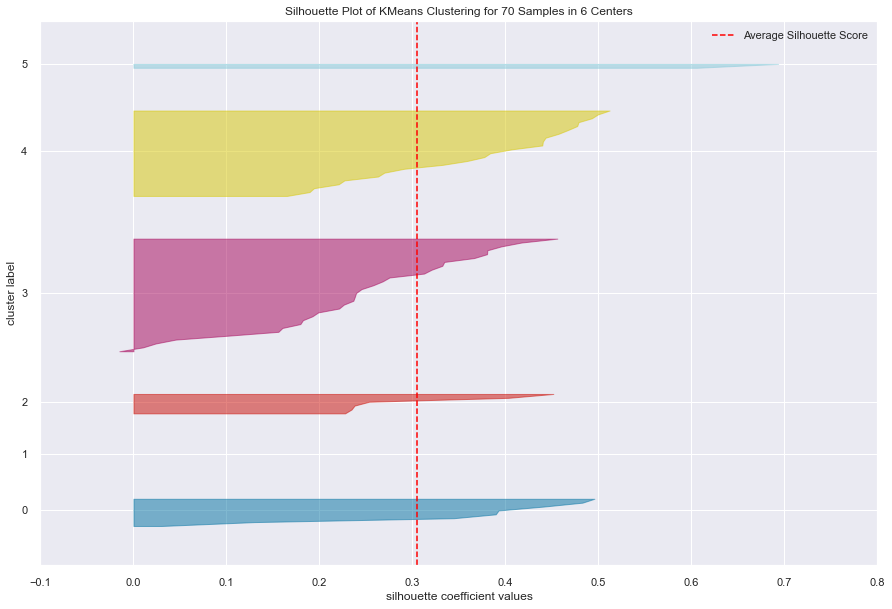

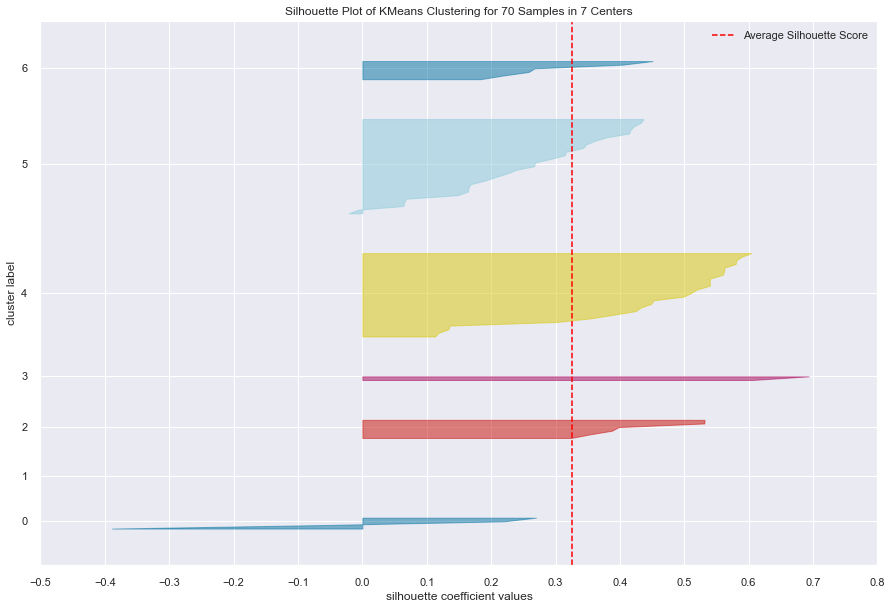

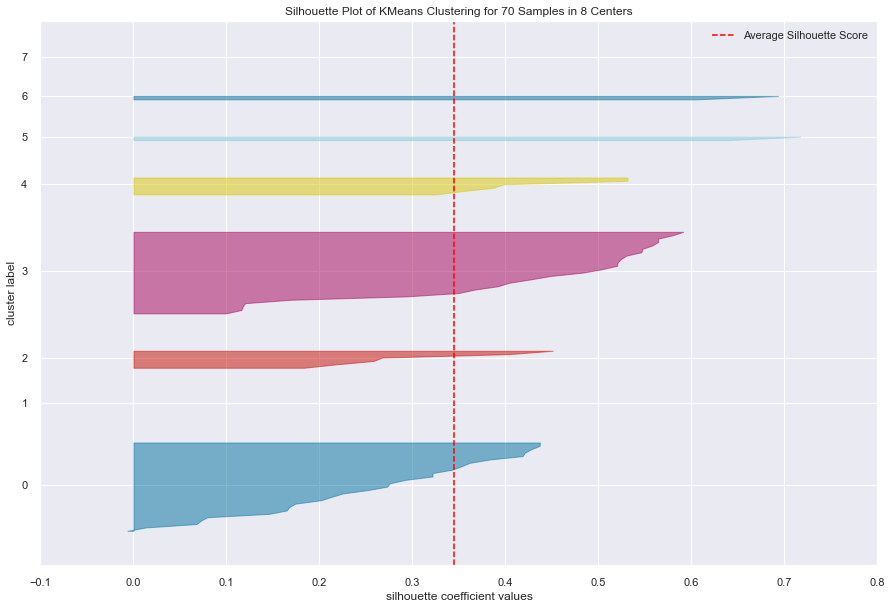

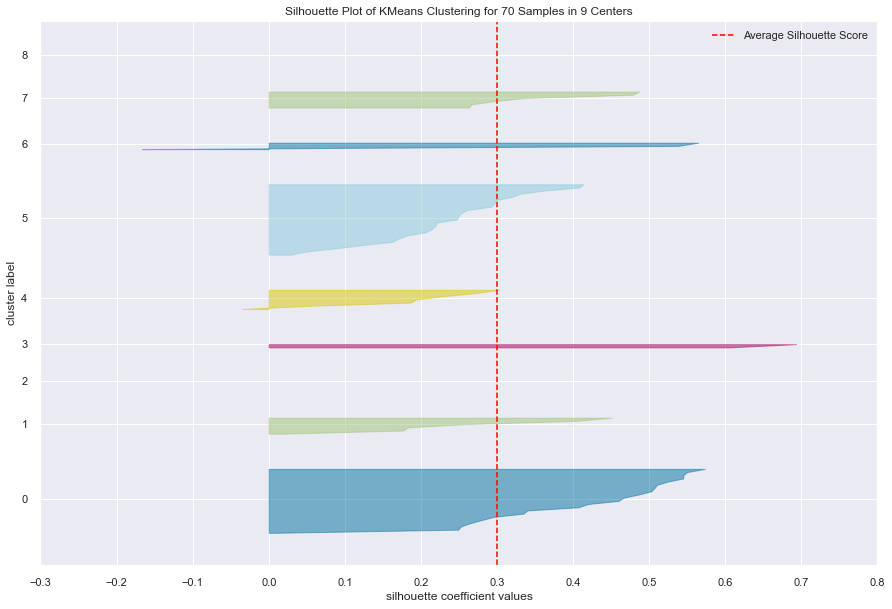

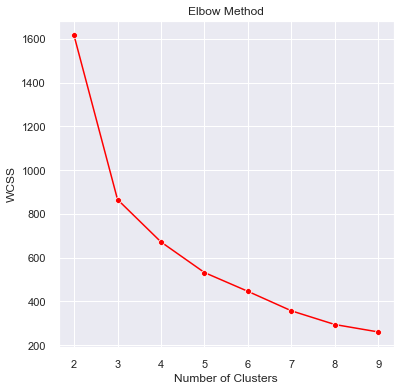

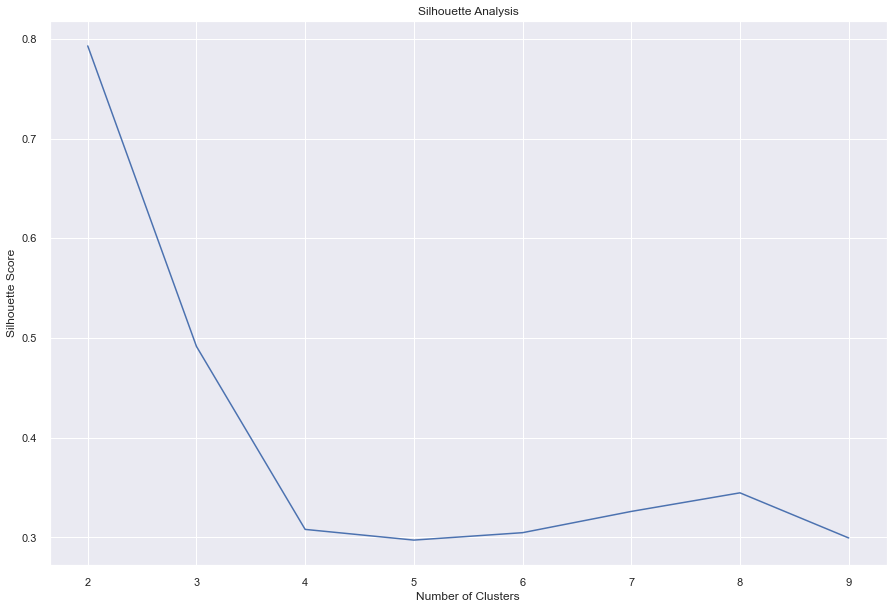

In [188]:
# for diabetes df
elbowAndSilhouette(df_d)

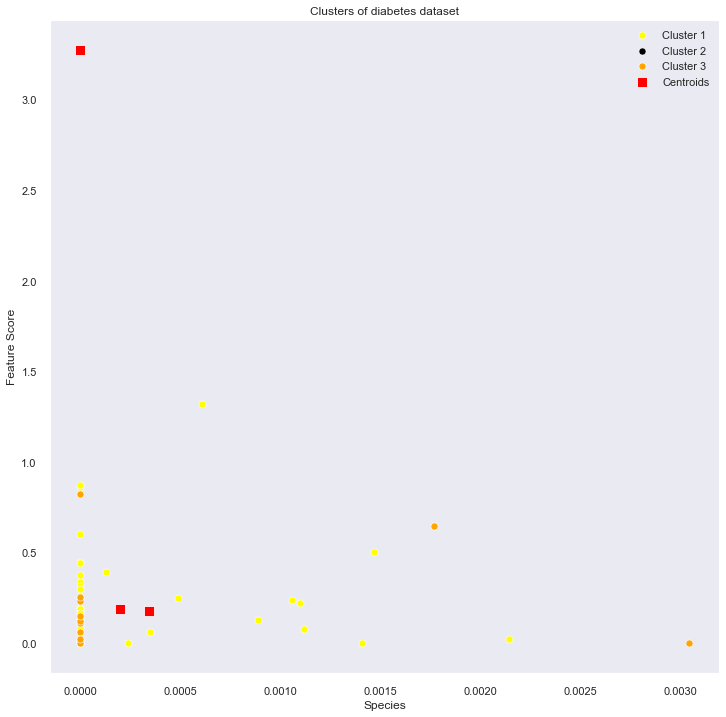

In [190]:
# applying k means = 3
X = df_d.to_numpy() # have to convert to numpy to plot graph
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X)

plt.figure(figsize=(12,12))
sns.scatterplot(X[y_kmeans == 0,0], X[y_kmeans == 0,1], color = 'yellow', label ='Cluster 1', s=50)
sns.scatterplot(X[y_kmeans == 1,0], X[y_kmeans == 1,1], color = 'black', label ='Cluster 2', s=50)
sns.scatterplot(X[y_kmeans == 2,0], X[y_kmeans == 2,1], color = 'orange', label ='Cluster 3', s=50)
#sns.scatterplot(X[y_kmeans == 3,0], X[y_kmeans == 3,1], color = 'blue', label ='Cluster 4', s=50)
#sns.scatterplot(X[y_kmeans == 4,0], X[y_kmeans == 4,1], color = 'green', label ='Cluster 5', s=50)
#sns.scatterplot(X[y_kmeans == 5,0], X[y_kmeans == 5,1], color = 'grey', label ='Cluster 6', s=50)
sns.scatterplot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], color ='red', label='Centroids', s=100, marker=',')
plt.grid(False)
plt.title('Clusters of diabetes dataset')
plt.xlabel('Species')
plt.ylabel('Feature Score')
plt.legend()
plt.show()

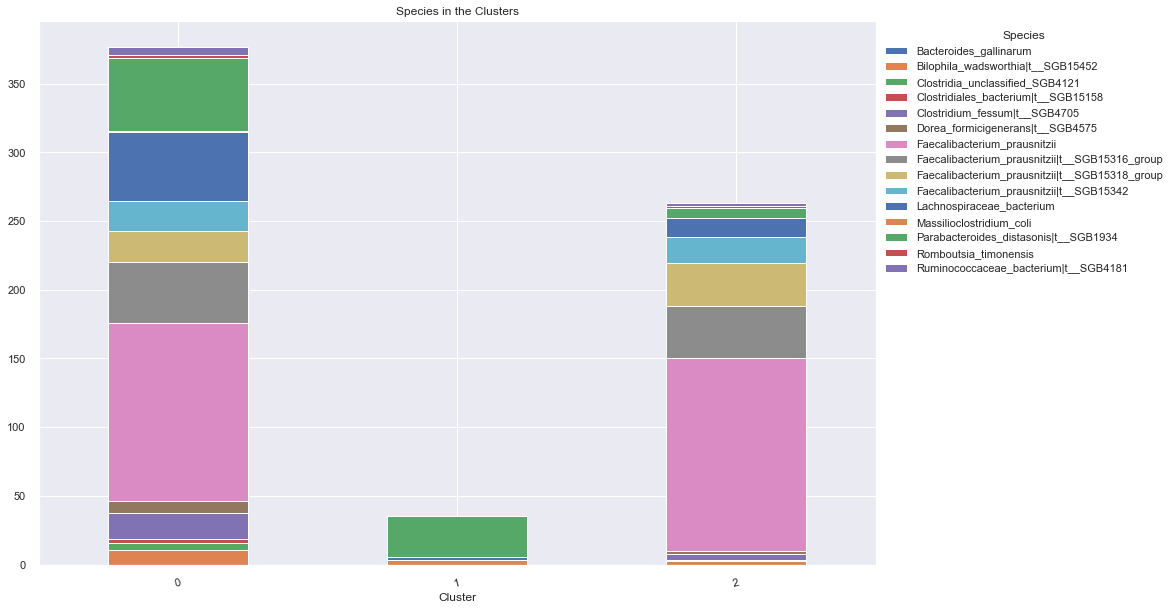

In [191]:
dict_cluster = stackedBar(df_d, y_kmeans, 3)

In [192]:
# species of cluster 1
print('Cluster 0 : ')
display(dict_cluster['df_0'])
print('Cluster 1 : ')
display(dict_cluster['df_1'])
print('Cluster 2 : ')
display(dict_cluster['df_2'])


Cluster 0 : 


0         1          2
Faecalibacterium_prausnitzii                    129.63281   0.00000  140.72242
Parabacteroides_distasonis|t__SGB1934            53.22871  29.97349    7.30240
Lachnospiraceae_bacterium                        50.50660   1.84639   14.26041
Faecalibacterium_prausnitzii|t__SGB15316_group   44.35292   0.00000   37.25575
Faecalibacterium_prausnitzii|t__SGB15318_group   22.59150   0.00000   31.61395

Cluster 1 : 


0         1         2
Parabacteroides_distasonis|t__SGB1934  53.22871  29.97349   7.30240
Bilophila_wadsworthia|t__SGB15452      10.23097   3.27380   2.45747
Lachnospiraceae_bacterium              50.50660   1.84639  14.26041
Clostridia_unclassified_SGB4121         5.13260   0.31024   0.76529
Bacteroides_gallinarum                  0.01101   0.00000   0.00481

Cluster 2 : 


0        1          2
Faecalibacterium_prausnitzii                    129.63281  0.00000  140.72242
Faecalibacterium_prausnitzii|t__SGB15316_group   44.35292  0.00000   37.25575
Faecalibacterium_prausnitzii|t__SGB15318_group   22.59150  0.00000   31.61395
Faecalibacterium_prausnitzii|t__SGB15342         21.44359  0.00000   18.77523
Lachnospiraceae_bacterium                        50.50660  1.84639   14.26041

Hierarchical Clustering

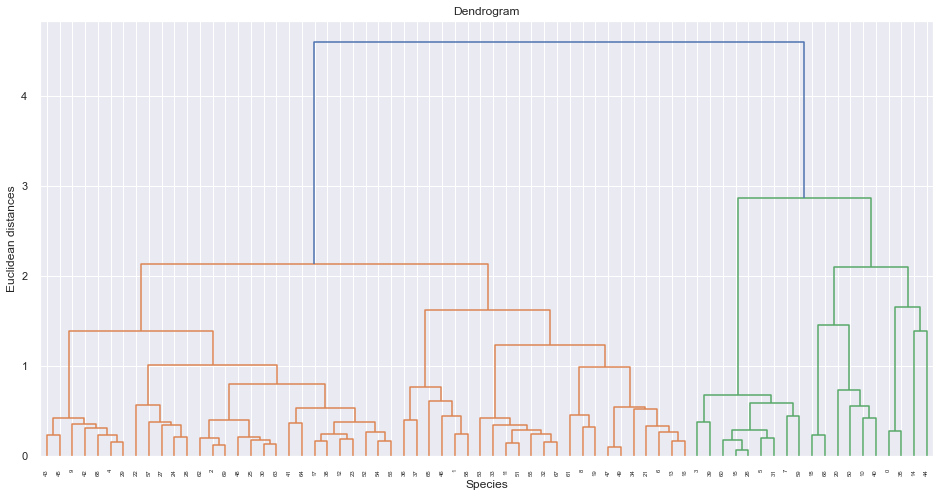

In [193]:
df_scaled_d = hierarchicalFirst(df_d)

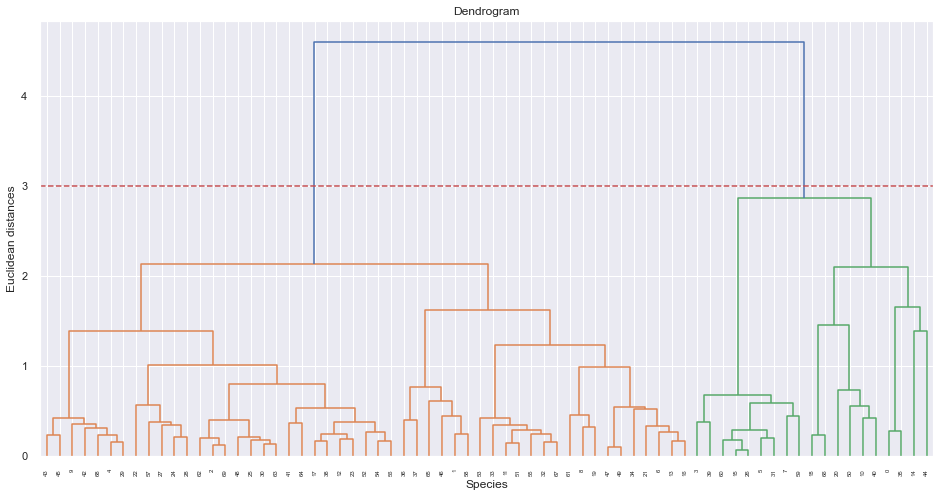

In [194]:
hierarchicalSecond(df_scaled_d,3.0)

In [195]:
y_hc,labels  = agglomerative(df_scaled_d, 3)
y_hc

array([1, 0, 0, 2, 0, 2, 0, 2, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0,
       1, 0, 0, 0], dtype=int64)

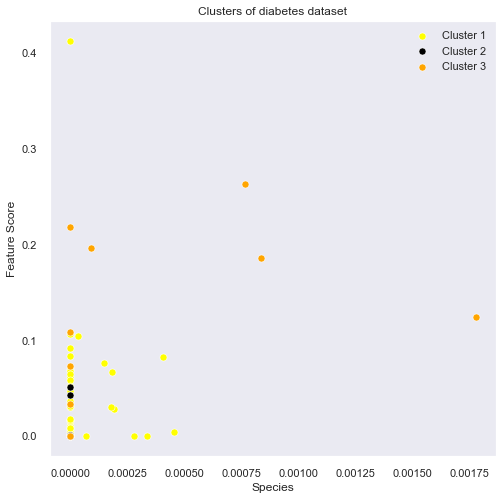

In [196]:
# agglomerative clustering = 3
X = df_scaled_d.to_numpy() # have to convert to numpy to plot graph

plt.figure(figsize=(8,8))
sns.scatterplot(X[y_hc == 0,0], X[y_hc == 0,1], color = 'yellow', label ='Cluster 1', s=50)
sns.scatterplot(X[y_hc == 1,0], X[y_hc == 1,1], color = 'black', label ='Cluster 2', s=50)
sns.scatterplot(X[y_hc == 2,0], X[y_hc == 2,1], color = 'orange', label ='Cluster 3', s=50)
#sns.scatterplot(X[y_hc == 3,0], X[y_hc == 3,1], color = 'blue', label ='Cluster 4', s=50)
#sns.scatterplot(X[y_kmeans == 4,0], X[y_kmeans == 4,1], color = 'green', label ='Cluster 5', s=50)
#sns.scatterplot(X[y_kmeans == 5,0], X[y_kmeans == 5,1], color = 'grey', label ='Cluster 6', s=50)
#sns.scatterplot(labels[:,0], labels[:,1], color ='red', label='Centroids', s=100, marker=',', c=labels)
plt.grid(False)
plt.title('Clusters of diabetes dataset')
plt.xlabel('Species')
plt.ylabel('Feature Score')
plt.legend()
plt.show()

Healthy

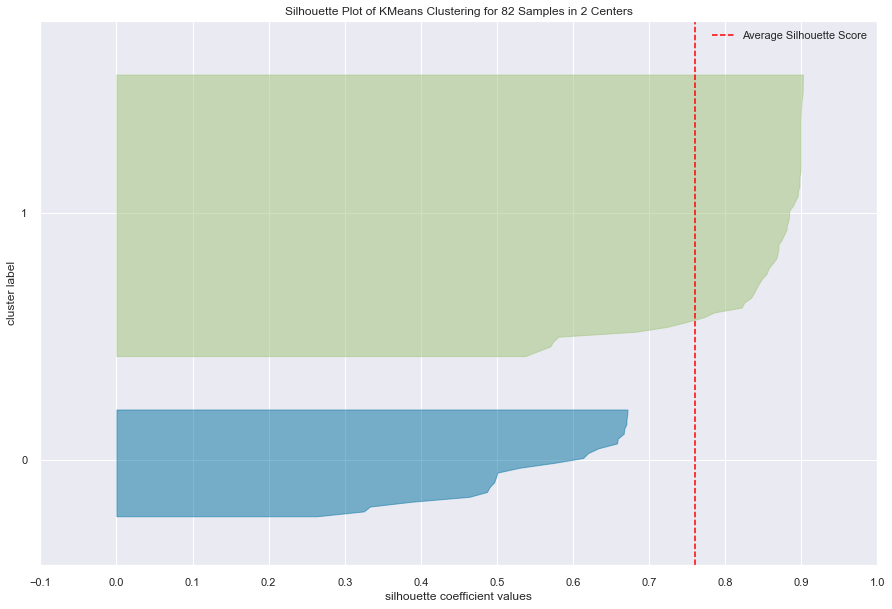

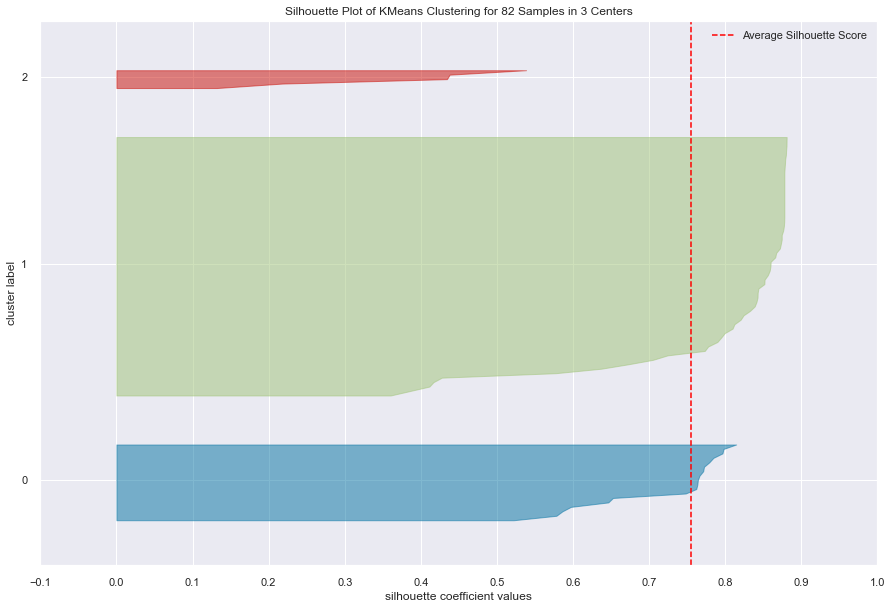

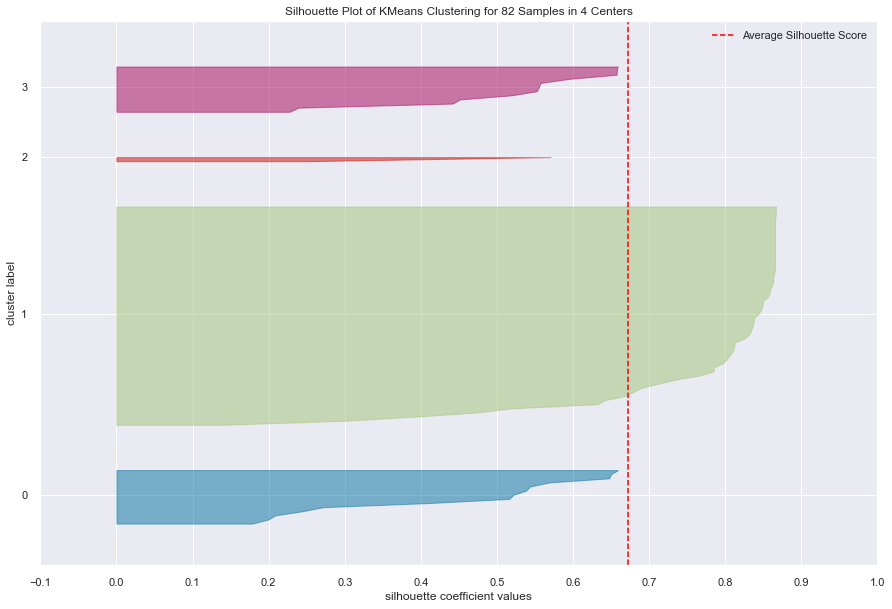

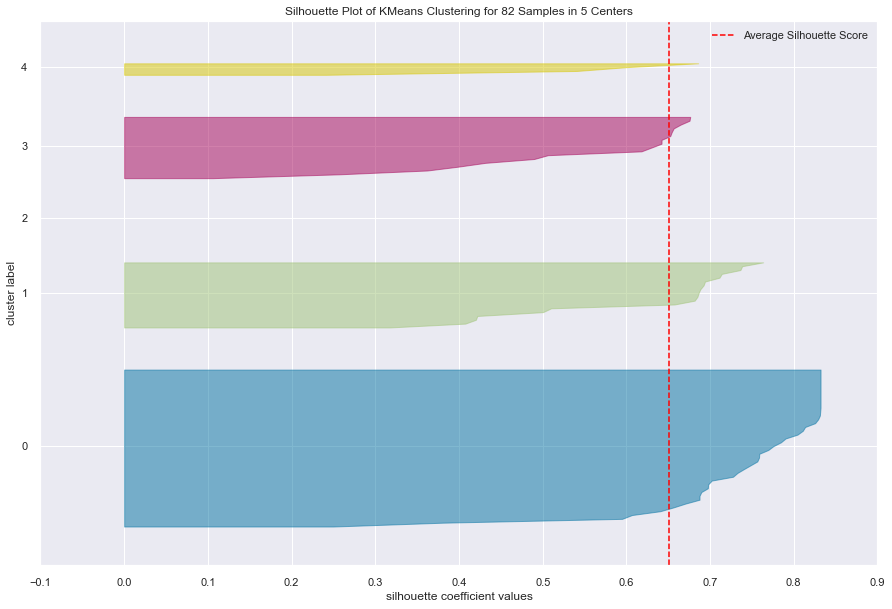

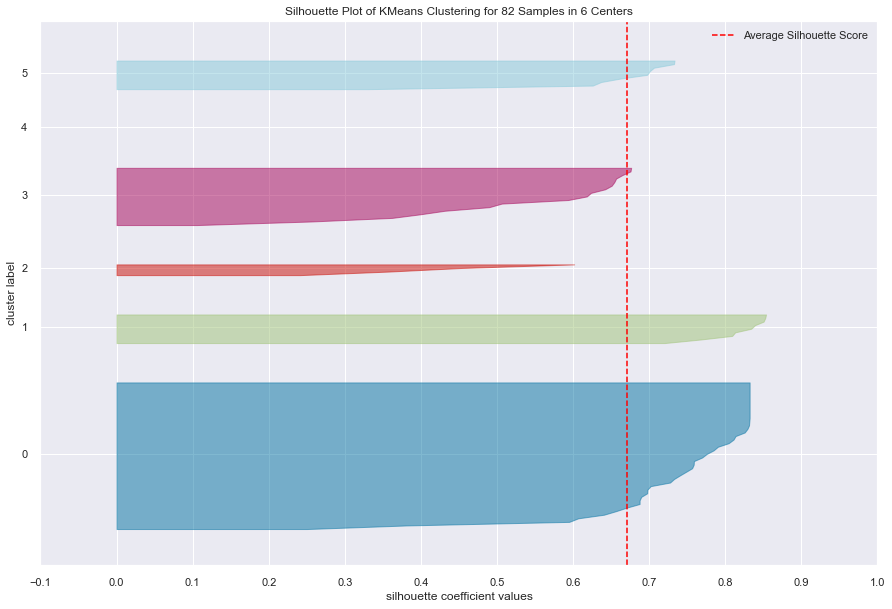

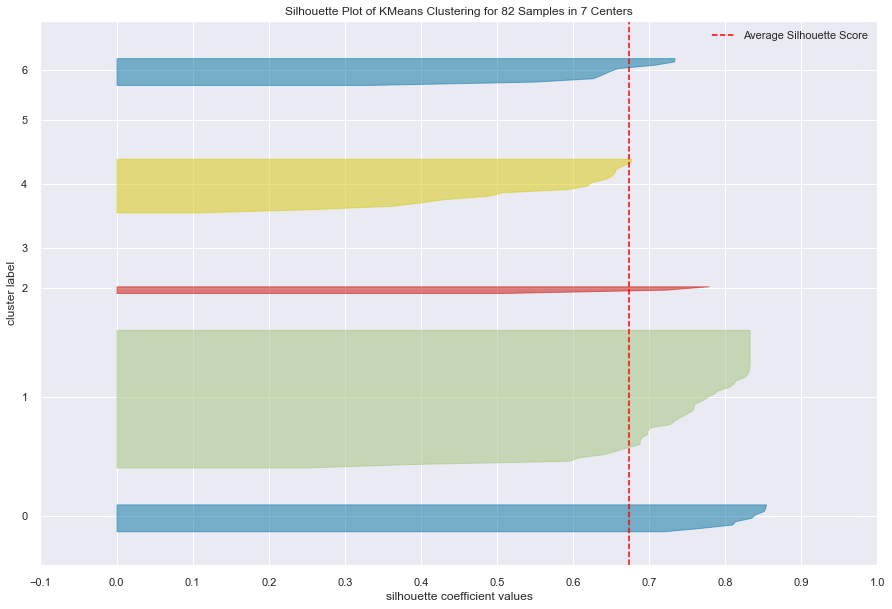

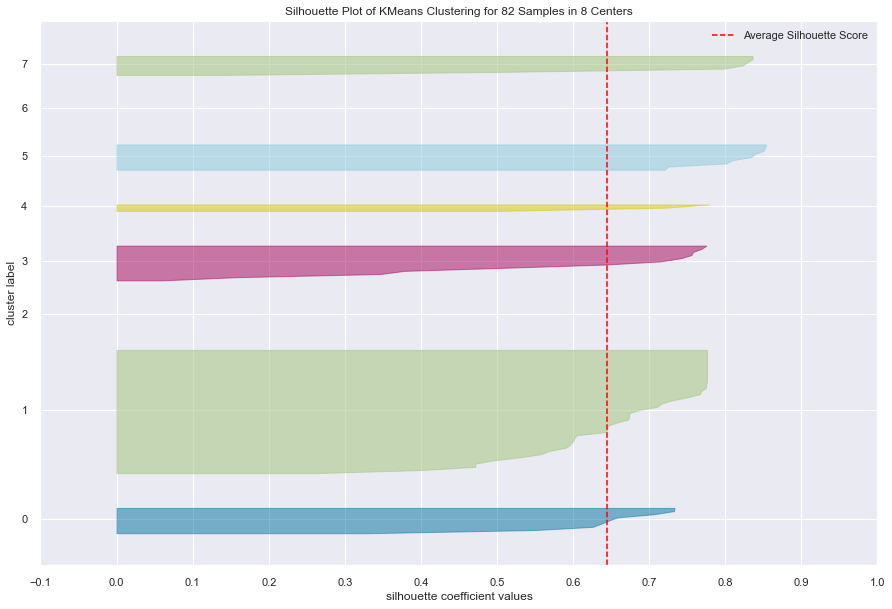

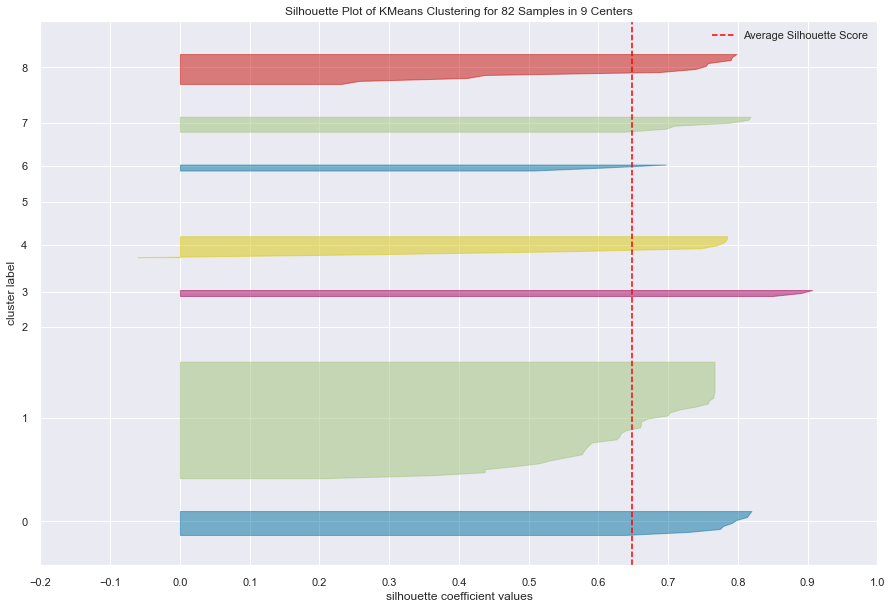

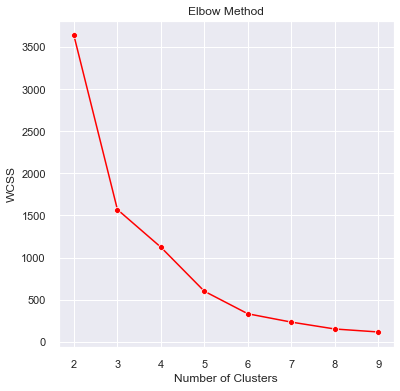

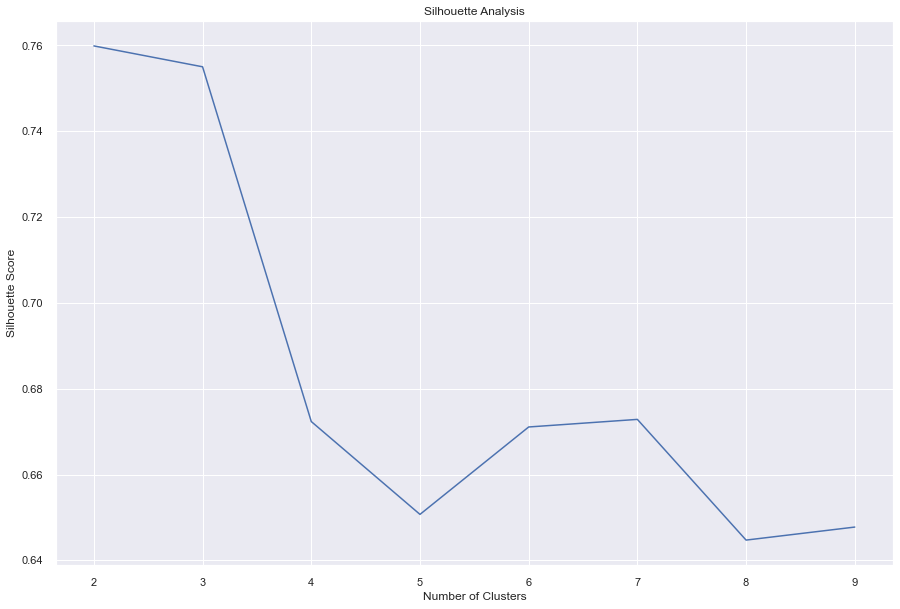

In [197]:
elbowAndSilhouette(df_h)

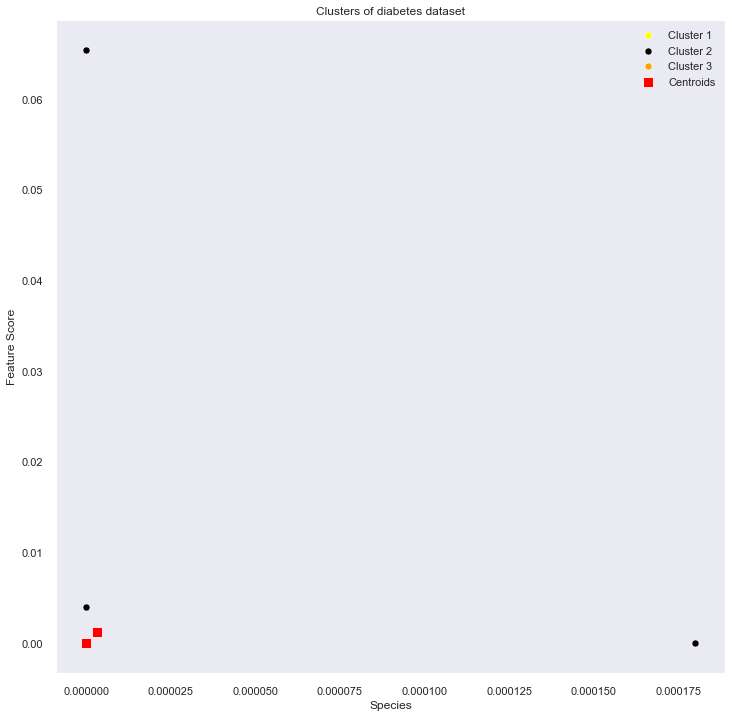

In [203]:
# applying k means = 3
X = df_h.to_numpy() # have to convert to numpy to plot graph
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X)

plt.figure(figsize=(12,12))
sns.scatterplot(X[y_kmeans == 0,0], X[y_kmeans == 0,1], color = 'yellow', label ='Cluster 1', s=50)
sns.scatterplot(X[y_kmeans == 1,0], X[y_kmeans == 1,1], color = 'black', label ='Cluster 2', s=50)
sns.scatterplot(X[y_kmeans == 2,0], X[y_kmeans == 2,1], color = 'orange', label ='Cluster 3', s=50)
#sns.scatterplot(X[y_kmeans == 3,0], X[y_kmeans == 3,1], color = 'blue', label ='Cluster 4', s=50)
#sns.scatterplot(X[y_kmeans == 4,0], X[y_kmeans == 4,1], color = 'green', label ='Cluster 5', s=50)
#sns.scatterplot(X[y_kmeans == 5,0], X[y_kmeans == 5,1], color = 'grey', label ='Cluster 6', s=50)
sns.scatterplot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], color ='red', label='Centroids', s=100, marker=',')
plt.grid(False)
plt.title('Clusters of diabetes dataset')
plt.xlabel('Species')
plt.ylabel('Feature Score')
plt.legend()
plt.show()

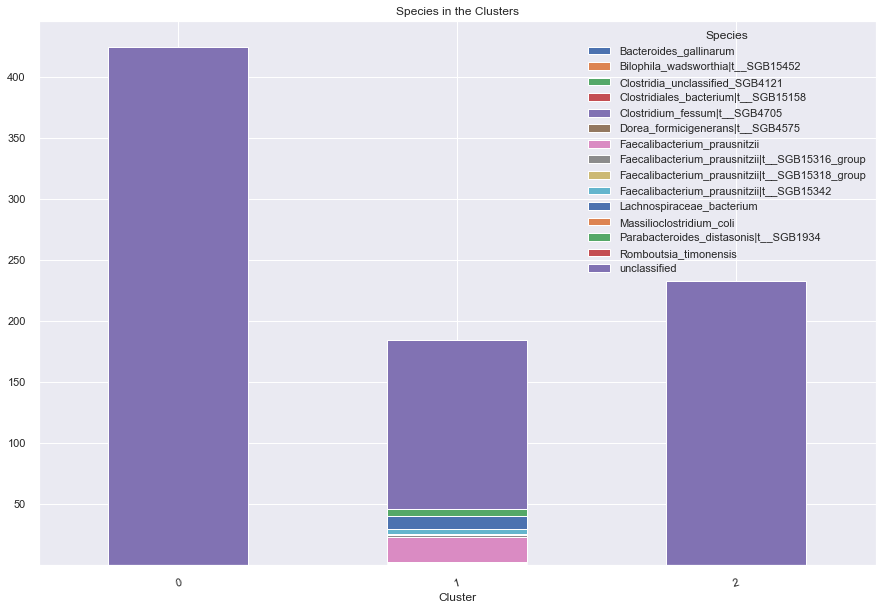

In [204]:
dict_cluster = stackedBar(df_h, y_kmeans, 3)

In [205]:
# species of clusters
print('Cluster 0 : ')
display(dict_cluster['df_0'])
print('Cluster 1 : ')
display(dict_cluster['df_1'])
print('Cluster 2 : ')
display(dict_cluster['df_2'])


Cluster 0 : 


0          1          2
unclassified                         424.54644  138.91429  232.80215
Bacteroides_gallinarum                 0.00000    0.00018    0.00000
Bilophila_wadsworthia|t__SGB15452      0.00000    0.06949    0.00000
Clostridia_unclassified_SGB4121        0.00000    0.31288    0.00000
Clostridiales_bacterium|t__SGB15158    0.00000    0.03130    0.00000

Cluster 1 : 


0          1          2
unclassified                              424.54644  138.91429  232.80215
Faecalibacterium_prausnitzii                0.00000   20.68803    0.00000
Lachnospiraceae_bacterium                   0.00000   10.61984    0.00000
Parabacteroides_distasonis|t__SGB1934       0.00000    5.12730    0.00000
Faecalibacterium_prausnitzii|t__SGB15342    0.00000    4.62396    0.00000

Cluster 2 : 


0          1          2
unclassified                         424.54644  138.91429  232.80215
Bacteroides_gallinarum                 0.00000    0.00018    0.00000
Bilophila_wadsworthia|t__SGB15452      0.00000    0.06949    0.00000
Clostridia_unclassified_SGB4121        0.00000    0.31288    0.00000
Clostridiales_bacterium|t__SGB15158    0.00000    0.03130    0.00000